# PAT Pretraining Notebook


Trained with Google TPU v2

#Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Importing

#Installs
!pip install pyarrow fastparquet

# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import clear_output

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.7 MB/s eta 0:00:00


In [ ]:
#@title Random Seeds
import random
## SEEDS

# Hard Code Random Seeds.
r1 = 0
r2 = 1

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

In [ ]:
#@title Connect to TPU
print("TensorFlow version:", tf.__version__)

# Connect to the TPU cluster or fall back to CPU/GPU
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Tries to connect to the TPU
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  devices = tf.config.list_logical_devices('TPU')
  print('TPU devices:', devices)
except ValueError:
  print("Could not connect to TPU; using CPU/GPU strategy instead.")
  strategy = tf.distribute.get_strategy()

# Example computation using the strategy
with strategy.scope():
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

  @tf.function
  def matmul_fn(x, y):
    return tf.matmul(x, y)

  z = strategy.run(matmul_fn, args=(a, b))

print(z)

TensorFlow version: 2.15.0
TPU devices: [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
PerReplica:{
  0: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  1: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  2: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  3: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  4: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  5: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  6: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  7: tf.

# Hyperparameters & Settings (Fill out)


In [ ]:
# write where you want to save all your files
root = "/content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/PAT Experiments /PAT Pretraining/Encoders"

In [ ]:
"""
Please Fill out Parameters Below
"""
## Model size
# eg. ["small", "medium", "large", "huge"]
size = "medium"

## Mask ratio
# eg. [.25, .50, .75]
mask_ratio = 0.50

## Smoothing
# eg. [True, False]
smoothing = False

## Loss Function
# eg. [True, False], meaning MSE on only the masked portion or everything in the reconstruction
mse_only_masked = True

In [ ]:
# Model naming
mask_name = int(mask_ratio*100)

name = f"/encoder_{size}_{mask_name}"

if smoothing == True:
  name = f"{name}_smoothed"
else:
  name = f"{name}_unsmoothed"

if mse_only_masked == True:
  name = f"{name}_mse_only_masked.h5"
else:
  name = f"{name}_mse_all.h5"

In [ ]:
print(name)

/encoder_medium_50_unsmoothed_mse_only_masked.h5


# Hyperparameter Additional Info

In [ ]:
"""
Model Size
"""
## Model Size
if size == "small":

  patch_size = 18
  embed_dim = 96
  # encoder
  encoder_num_heads = 6
  encoder_ff_dim = 256
  encoder_num_layers = 1
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 6
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

if size == "medium":

  patch_size = 18
  embed_dim = 96
  # encoder
  encoder_num_heads = 12
  encoder_ff_dim = 256
  encoder_num_layers = 2
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 12
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

if size == "large":

  patch_size = 9
  embed_dim = 96
  # encoder
  encoder_num_heads = 12
  encoder_ff_dim = 256
  encoder_num_layers = 4
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 12
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

if size == "huge":

  patch_size = 5
  embed_dim = 96
  # encoder
  encoder_num_heads = 12
  encoder_ff_dim = 256
  encoder_num_layers = 8
  encoder_rate = 0.1
  # decoder
  decoder_num_heads = 12
  decoder_ff_dim = 256
  decoder_num_layers = 1
  decoder_rate = 0.1

In [ ]:
"""
For Pretraining
"""

## Model Size
if size == "small":

  learning_rate = 0.001
  early_stopping_patience = 250
  reduce_lr_patience = 75
  min_lr = 1e-4

if size == "medium":

  learning_rate = 0.001
  early_stopping_patience = 250
  reduce_lr_patience = 75
  min_lr = 1e-4

if size == "large":

  learning_rate = 0.0001
  early_stopping_patience = 500
  reduce_lr_patience = 100
  min_lr = 1e-5


if size == "huge":

  learning_rate = 0.00001
  early_stopping_patience = 500
  reduce_lr_patience = 100
  min_lr = 1e-6

In [ ]:
"""
Smoothing
"""
if smoothing == True:
  data = pd.read_parquet('/content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/Data Preprocessing/SelfSupervised Datasets/Smooth/[SelfSupervised][Smooth]WideSeqnActi_AndMeds_2013.parq')

else:
  data = pd.read_parquet('/content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/Data Preprocessing/SelfSupervised Datasets/Raw/[SelfSupervised][Raw]WideSeqnActi_AndMeds_2013.parq')

# Process Data

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into train and temp (this temp will be split into validation and test)
X_train, X_test = train_test_split(np.array(data), test_size=0.005, random_state=19, shuffle=True)


# Reshape Train and Test
n_participants_train = X_train.shape[0]
n_participants_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = 1

# Reshape data
X_train = X_train.reshape((n_participants_train, n_timesteps, n_features))
X_test = X_test.reshape((n_participants_test, n_timesteps, n_features))

In [ ]:
X_train.shape

(21430, 10080, 1)

In [ ]:
X_test.shape

(108, 10080, 1)

# Autoencoder


#MAE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Modified Transformer Block to output attention weights with explicit layer names
def TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1, name_prefix="encoder"):
    # Input
    input_layer = layers.Input(shape=(None, embed_dim), name=f"{name_prefix}_input")
    #Attention
    attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{name_prefix}_attention")
    attention_output, attention_weights = attention_layer(input_layer, input_layer, return_attention_scores=True)
    attention_output = layers.Dropout(rate, name=f"{name_prefix}_dropout")(attention_output)
    # Add + Norm
    out1 = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_norm1")(input_layer + attention_output)
    # FF Network
    ff_output = layers.Dense(ff_dim, activation="relu", name=f"{name_prefix}_ff1")(out1)
    ff_output = layers.Dense(embed_dim, name=f"{name_prefix}_ff2")(ff_output)
    ff_output = layers.Dropout(rate, name=f"{name_prefix}_dropout2")(ff_output)
    # Add + Norm
    final_output = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_norm2")(out1 + ff_output)
    return models.Model(inputs=input_layer, outputs=[final_output, attention_weights], name=f"{name_prefix}_transformer")

# Custom Layer to create and apply the mask for MAE
class MaskLayer(layers.Layer):
    def __init__(self, mask_ratio, embed_dim, **kwargs):
        super(MaskLayer, self).__init__(**kwargs)
        self.mask_ratio = mask_ratio
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.mask_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer='random_normal',
            trainable=True,
            name='mask_token'
        )

    def call(self, patch_embeddings, positional_embeddings):
        batch_size = tf.shape(patch_embeddings)[0]
        num_patches = tf.shape(patch_embeddings)[1]

        shuffled_indices = tf.random.shuffle(tf.range(num_patches))
        num_masked = tf.cast(tf.math.round(self.mask_ratio * tf.cast(num_patches, tf.float32)), tf.int32)

        masked_indices = shuffled_indices[:num_masked]
        visible_indices = shuffled_indices[num_masked:]

        visible_patches = tf.gather(patch_embeddings, indices=visible_indices, axis=1)
        masked_patches = tf.gather(patch_embeddings, indices=masked_indices, axis=1)
        visible_positional_embeddings = tf.gather(positional_embeddings, indices=visible_indices, axis=0)

        return visible_patches, masked_patches, visible_positional_embeddings, shuffled_indices, masked_indices

# Custom Layer to create mask tokens for the decoder
class MaskTokenLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MaskTokenLayer, self).__init__(**kwargs)

    def call(self, mask_token, masked_patches):
        tiled_mask_tokens = tf.tile(mask_token, [tf.shape(masked_patches)[0], tf.shape(masked_patches)[1], 1])
        return tiled_mask_tokens

# Custom Layer to concatenate tensors
class ConcatLayer(layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ConcatLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.concat(inputs, axis=self.axis)

# Unshuffling Layer to revert the shuffle applied during masking
class UnshuffleLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(UnshuffleLayer, self).__init__(**kwargs)

    def call(self, patches, shuffle_indices):
        num_patches = tf.shape(shuffle_indices)[0]

        reverse_indices = tf.scatter_nd(
            tf.expand_dims(shuffle_indices, axis=-1),
            tf.range(num_patches),
            [num_patches]
        )

        unshuffled_patches = tf.gather(patches, indices=reverse_indices, axis=1)

        return unshuffled_patches

# Sine/Cosine positional embeddings
def get_positional_embeddings(num_patches, embed_dim):
    position = tf.range(num_patches, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, embed_dim, 2, dtype=tf.float32) * (-tf.math.log(10000.0) / embed_dim))
    pos_embeddings = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)
    return pos_embeddings

# Custom Layer to calculate MSE only on masked portions
class MaskedMSELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MaskedMSELayer, self).__init__(**kwargs)

    def call(self, y_true, y_pred, masked_indices, mse_only_masked):

        if mse_only_masked:
            y_true_flat = tf.reshape(y_true, [-1])
            y_pred_flat = tf.reshape(y_pred, [-1])

            y_true_masked = tf.gather(y_true_flat, masked_indices)
            y_pred_masked = tf.gather(y_pred_flat, masked_indices)

            mse_loss = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))
        else:
            mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        return mse_loss

# Model creation function
def create_model(input_size=10080, patch_size=patch_size, embed_dim=embed_dim,
                 encoder_num_heads=encoder_num_heads, encoder_ff_dim=encoder_ff_dim, encoder_num_layers=encoder_num_layers, encoder_rate=encoder_rate,
                 decoder_num_heads=decoder_num_heads, decoder_ff_dim=decoder_ff_dim, decoder_num_layers=decoder_num_layers, decoder_rate=decoder_rate,
                 mask_ratio=mask_ratio, mse_only_masked=mse_only_masked, return_attention=False):

    num_patches = input_size // patch_size
    inputs = layers.Input(shape=(input_size,), name="inputs")
    reshaped = layers.Reshape((num_patches, patch_size), name="reshape")(inputs)


    patch_embeddings = layers.Dense(embed_dim, name="dense")(reshaped)


    positional_embeddings = get_positional_embeddings(num_patches, embed_dim)

    mask_layer = MaskLayer(mask_ratio, embed_dim, name="mask_layer")
    visible_patches, masked_patches, visible_positional_embeddings, shuffle_indices, masked_indices = mask_layer(patch_embeddings, positional_embeddings)

    x = visible_patches + visible_positional_embeddings
    attention_weights = []

    for i in range(encoder_num_layers):
        x, weights = TransformerBlock(embed_dim, encoder_num_heads, encoder_ff_dim, encoder_rate, name_prefix=f"encoder_layer_{i+1}")(x)
        if return_attention:
            attention_weights.append(weights)

    mask_token_layer = MaskTokenLayer(name="mask_token_layer")
    mask_tokens = mask_token_layer(mask_layer.mask_token, masked_patches)

    decoder_input = ConcatLayer(axis=1, name="concat_layer")([x, mask_tokens])

    unshuffle_layer = UnshuffleLayer(name="unshuffle_layer")
    decoder_input_unshuffled = unshuffle_layer(decoder_input, shuffle_indices)

    decoder_input_with_pos = decoder_input_unshuffled + positional_embeddings

    y = decoder_input_with_pos
    for i in range(decoder_num_layers):
        y, _ = TransformerBlock(embed_dim, decoder_num_heads, encoder_ff_dim, decoder_rate, name_prefix=f"decoder_layer_{i+1}")(y)

    outputs = layers.Dense(patch_size, activation='tanh', name="decoder_dense")(y)
    outputs = 2 * outputs #nothing above 2 standard deviations we'll just categorize as the same
    outputs = layers.Reshape((input_size,), name="decoder_reshape")(outputs)

    masked_mse_layer = MaskedMSELayer(name="masked_mse_layer")
    loss = masked_mse_layer(inputs, outputs, masked_indices, mse_only_masked)

    model = models.Model(inputs=inputs, outputs=outputs, name="MAE_model")
    model.add_loss(loss)

    if return_attention:
        return models.Model(inputs=inputs, outputs=[outputs] + attention_weights, name="MAE_with_attention")
    else:
        return model


with strategy.scope():
    model = create_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False))

model.summary()

Model: "MAE_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 10080)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 560, 18)              0         ['inputs[0][0]']              
                                                                                                  
 dense (Dense)               (None, 560, 96)              1824      ['reshape[0][0]']             
                                                                                                  
 mask_layer (MaskLayer)      ((None, 280, 96),            96        ['dense[0][0]']               
                              (None, 280, 96),                                            

# Train Model

Epoch 1/10000
151/151 [==============================] - 45s 147ms/step - loss: 1.7138 - val_loss: 0.3649 - lr: 0.0010
Epoch 2/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4510 - val_loss: 0.3615 - lr: 0.0010
Epoch 3/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3949 - val_loss: 0.3398 - lr: 0.0010
Epoch 4/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.5958 - val_loss: 0.3380 - lr: 0.0010
Epoch 5/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3446 - val_loss: 0.3483 - lr: 0.0010
Epoch 6/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6051 - val_loss: 0.3450 - lr: 0.0010
Epoch 7/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.8314 - val_loss: 0.3343 - lr: 0.0010
Epoch 8/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7529 - val_loss: 0.3430 - lr: 0.0010
Epoch 9/10000
151/151 [==============================] - 7s 48

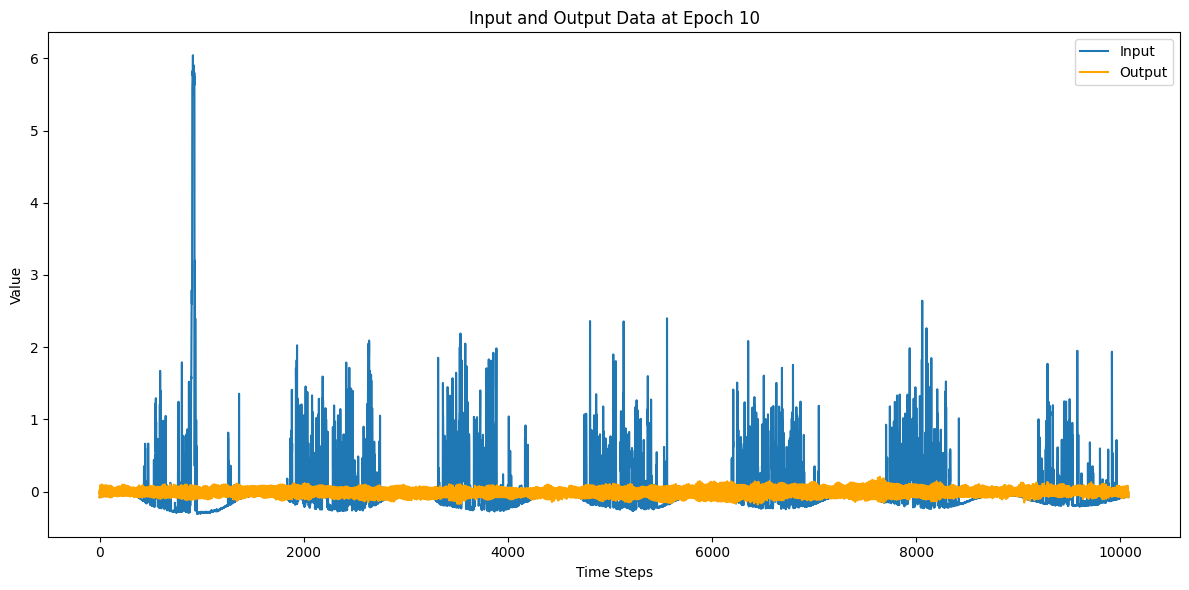

151/151 [==============================] - 12s 78ms/step - loss: 0.3749 - val_loss: 0.3391 - lr: 0.0010
Epoch 11/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6316 - val_loss: 0.3551 - lr: 0.0010
Epoch 12/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5885 - val_loss: 0.3514 - lr: 0.0010
Epoch 13/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6419 - val_loss: 0.3547 - lr: 0.0010
Epoch 14/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4199 - val_loss: 0.3348 - lr: 0.0010
Epoch 15/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1745 - val_loss: 0.4988 - lr: 0.0010
Epoch 16/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4075 - val_loss: 0.3276 - lr: 0.0010
Epoch 17/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3452 - val_loss: 0.3448 - lr: 0.0010
Epoch 18/10000
151/151 [==============================] - 7s 48ms/step

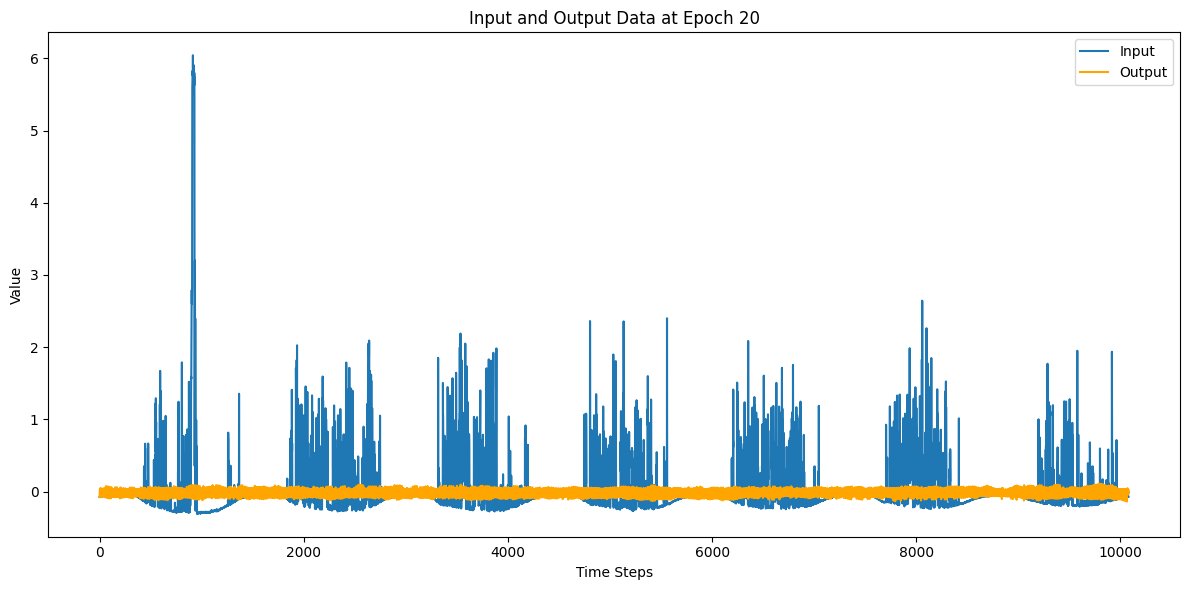

151/151 [==============================] - 8s 55ms/step - loss: 0.9855 - val_loss: 0.3312 - lr: 0.0010
Epoch 21/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7587 - val_loss: 0.3561 - lr: 0.0010
Epoch 22/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8582 - val_loss: 0.3478 - lr: 0.0010
Epoch 23/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8128 - val_loss: 0.3556 - lr: 0.0010
Epoch 24/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5952 - val_loss: 0.3408 - lr: 0.0010
Epoch 25/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3403 - val_loss: 0.3665 - lr: 0.0010
Epoch 26/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3538 - val_loss: 0.3399 - lr: 0.0010
Epoch 27/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1098 - val_loss: 0.3493 - lr: 0.0010
Epoch 28/10000
151/151 [==============================] - 7s 50ms/step 

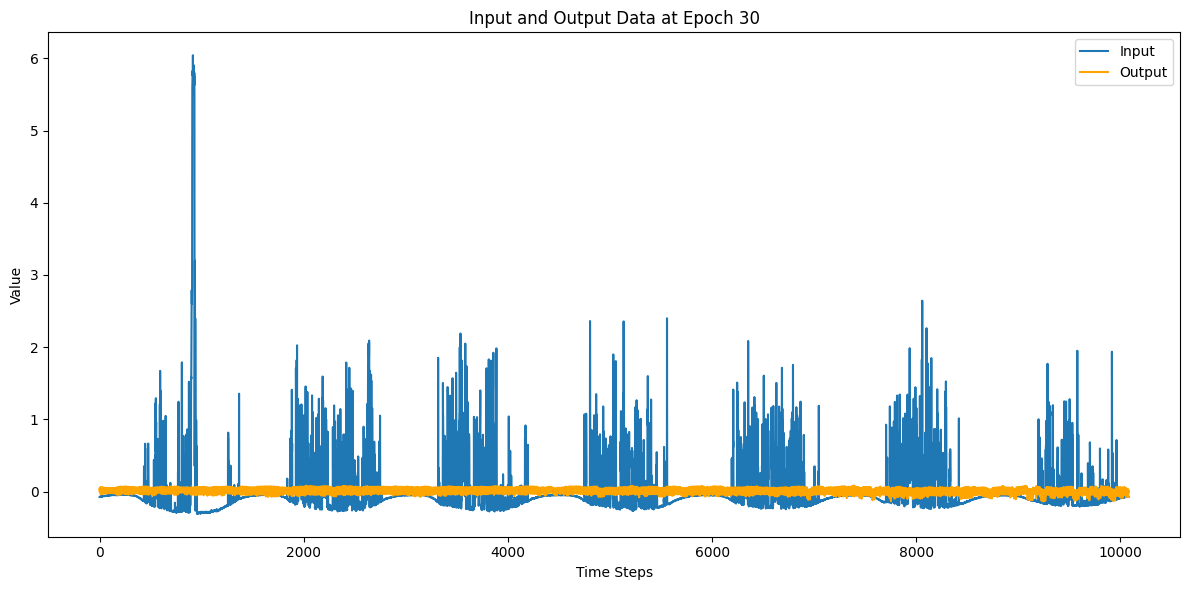

151/151 [==============================] - 8s 56ms/step - loss: 0.5716 - val_loss: 0.3475 - lr: 0.0010
Epoch 31/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5980 - val_loss: 0.3425 - lr: 0.0010
Epoch 32/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6579 - val_loss: 0.3583 - lr: 0.0010
Epoch 33/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0912 - val_loss: 0.3389 - lr: 0.0010
Epoch 34/10000
151/151 [==============================] - 8s 53ms/step - loss: 1.6180 - val_loss: 0.3363 - lr: 0.0010
Epoch 35/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7017 - val_loss: 0.3383 - lr: 0.0010
Epoch 36/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7578 - val_loss: 0.3587 - lr: 0.0010
Epoch 37/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7139 - val_loss: 0.3422 - lr: 0.0010
Epoch 38/10000
151/151 [==============================] - 7s 49ms/step 

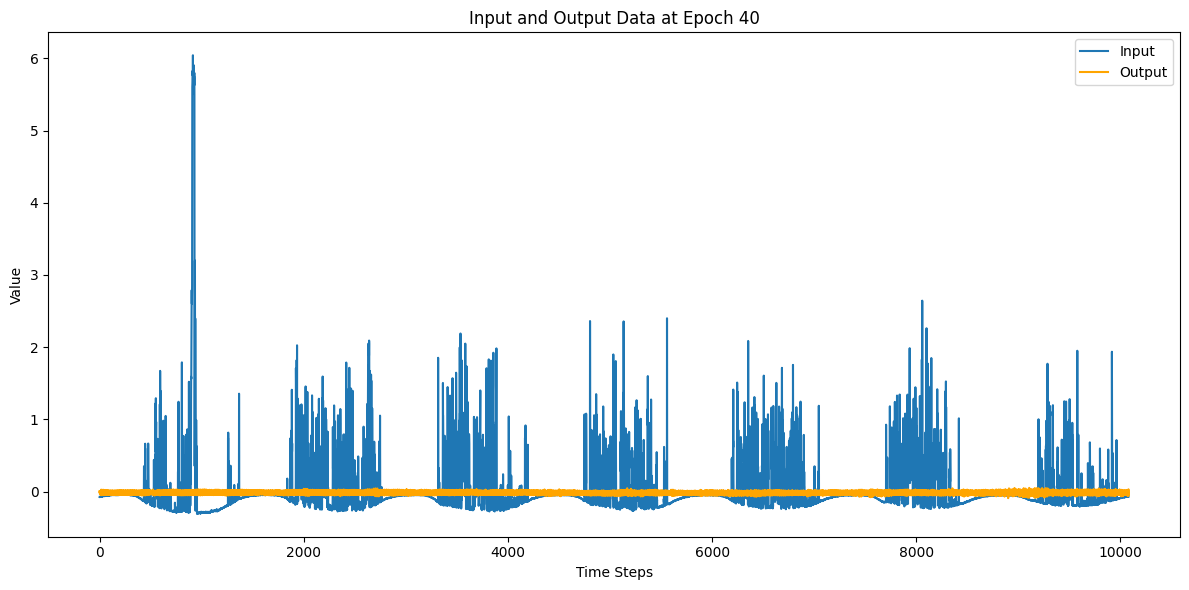

151/151 [==============================] - 8s 56ms/step - loss: 0.5562 - val_loss: 0.3375 - lr: 0.0010
Epoch 41/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.9188 - val_loss: 0.3333 - lr: 0.0010
Epoch 42/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5811 - val_loss: 0.3331 - lr: 0.0010
Epoch 43/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1846 - val_loss: 0.3570 - lr: 0.0010
Epoch 44/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4595 - val_loss: 0.3472 - lr: 0.0010
Epoch 45/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3465 - val_loss: 0.3316 - lr: 0.0010
Epoch 46/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8688 - val_loss: 0.3510 - lr: 0.0010
Epoch 47/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5396 - val_loss: 0.3299 - lr: 0.0010
Epoch 48/10000
151/151 [==============================] - 7s 49ms/step 

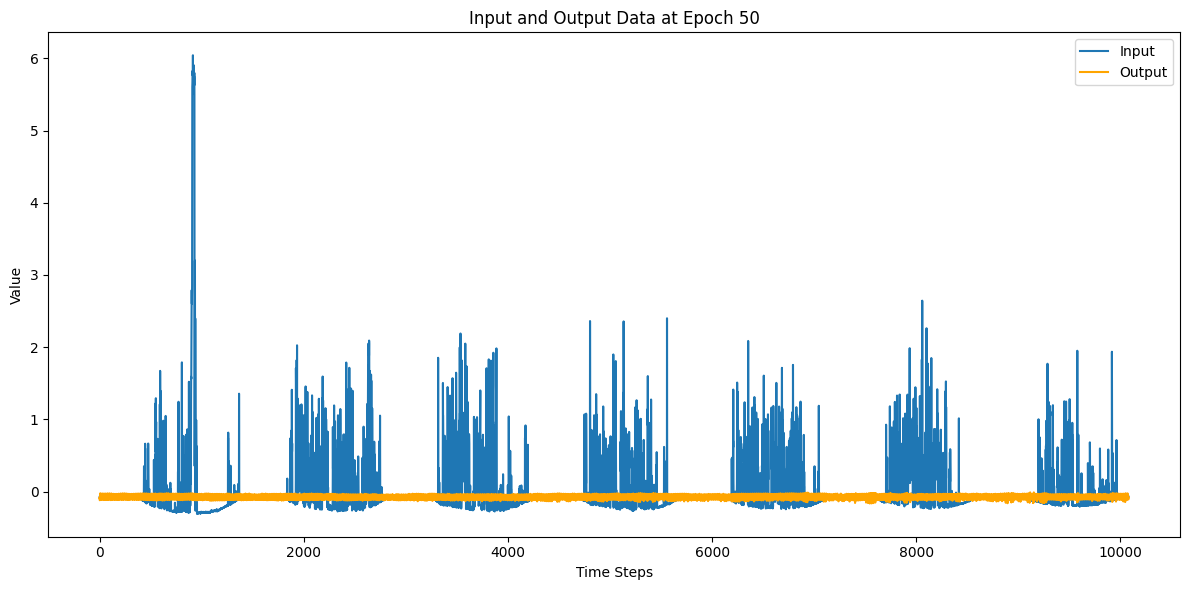

151/151 [==============================] - 9s 57ms/step - loss: 0.3234 - val_loss: 0.3446 - lr: 0.0010
Epoch 51/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7096 - val_loss: 0.3397 - lr: 0.0010
Epoch 52/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7595 - val_loss: 0.3489 - lr: 0.0010
Epoch 53/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7777 - val_loss: 0.3479 - lr: 0.0010
Epoch 54/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5471 - val_loss: 0.3480 - lr: 0.0010
Epoch 55/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6285 - val_loss: 0.3540 - lr: 0.0010
Epoch 56/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6640 - val_loss: 0.3590 - lr: 0.0010
Epoch 57/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.2643 - val_loss: 0.3459 - lr: 0.0010
Epoch 58/10000
151/151 [==============================] - 7s 49ms/step 

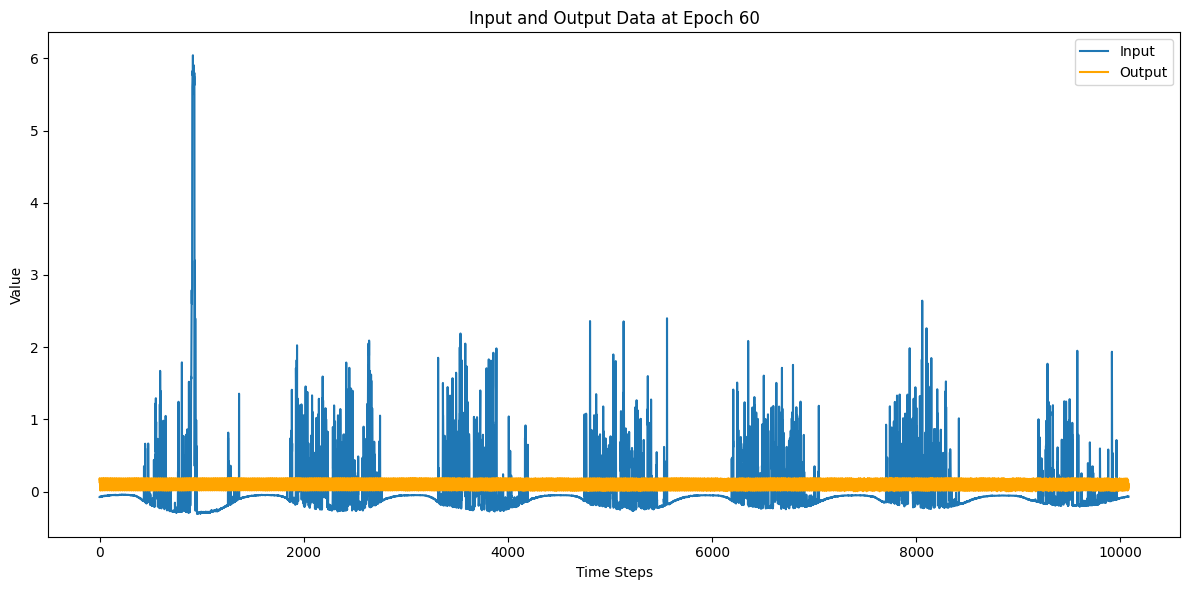

151/151 [==============================] - 8s 56ms/step - loss: 2.2332 - val_loss: 0.3568 - lr: 0.0010
Epoch 61/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8808 - val_loss: 0.3363 - lr: 0.0010
Epoch 62/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.6132 - val_loss: 0.3290 - lr: 0.0010
Epoch 63/10000
151/151 [==============================] - 8s 53ms/step - loss: 1.4464 - val_loss: 0.3368 - lr: 0.0010
Epoch 64/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3658 - val_loss: 0.3397 - lr: 0.0010
Epoch 65/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5918 - val_loss: 0.3411 - lr: 0.0010
Epoch 66/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6015 - val_loss: 0.3379 - lr: 0.0010
Epoch 67/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6126 - val_loss: 0.3614 - lr: 0.0010
Epoch 68/10000
151/151 [==============================] - 7s 49ms/step 

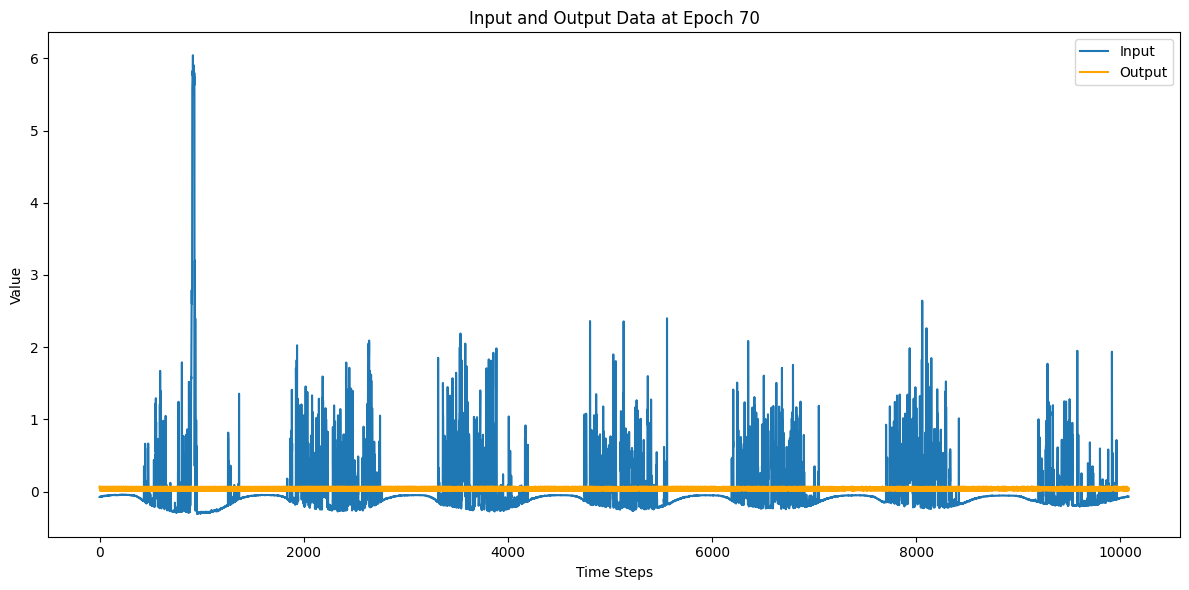

151/151 [==============================] - 9s 57ms/step - loss: 0.7991 - val_loss: 0.3526 - lr: 0.0010
Epoch 71/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6117 - val_loss: 0.3516 - lr: 0.0010
Epoch 72/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4079 - val_loss: 0.3394 - lr: 0.0010
Epoch 73/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.2253 - val_loss: 0.3403 - lr: 0.0010
Epoch 74/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5981 - val_loss: 0.3461 - lr: 0.0010
Epoch 75/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6229 - val_loss: 0.3288 - lr: 0.0010
Epoch 76/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3499 - val_loss: 0.3322 - lr: 0.0010
Epoch 77/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6863 - val_loss: 0.3445 - lr: 0.0010
Epoch 78/10000
151/151 [==============================] - 7s 50ms/step 

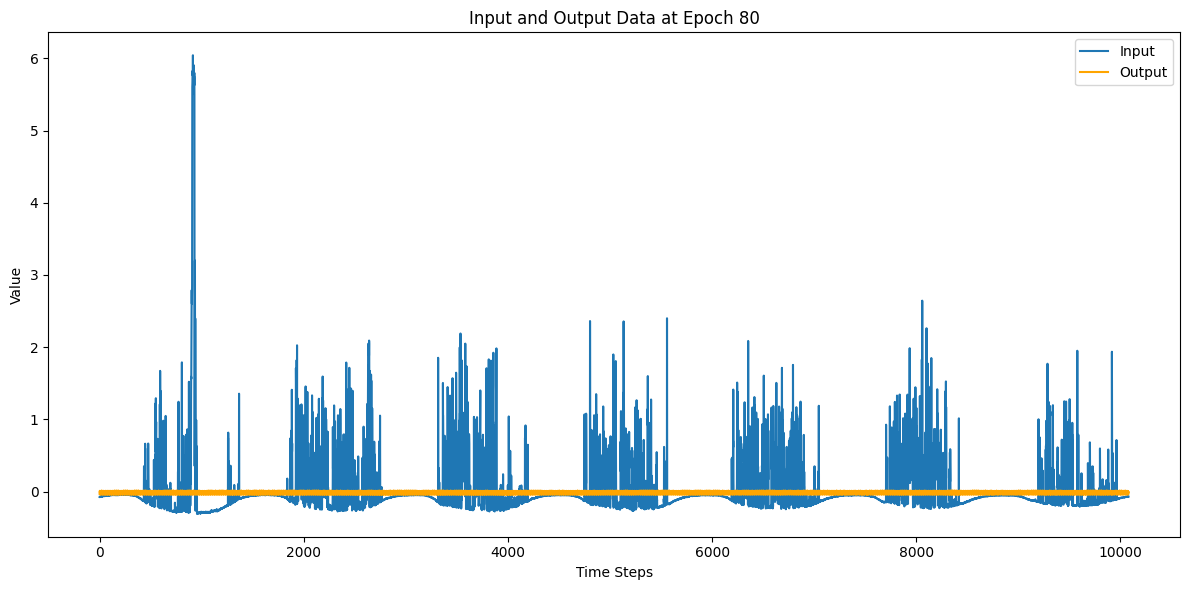

151/151 [==============================] - 8s 56ms/step - loss: 0.4096 - val_loss: 0.3494 - lr: 0.0010
Epoch 81/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6353 - val_loss: 0.3540 - lr: 0.0010
Epoch 82/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.5992 - val_loss: 0.3456 - lr: 0.0010
Epoch 83/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5514 - val_loss: 0.3332 - lr: 0.0010
Epoch 84/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5270 - val_loss: 0.3445 - lr: 0.0010
Epoch 85/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7615 - val_loss: 0.3408 - lr: 0.0010
Epoch 86/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0078 - val_loss: 0.3486 - lr: 0.0010
Epoch 87/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6646 - val_loss: 0.3434 - lr: 0.0010
Epoch 88/10000
151/151 [==============================] - 7s 49ms/step 

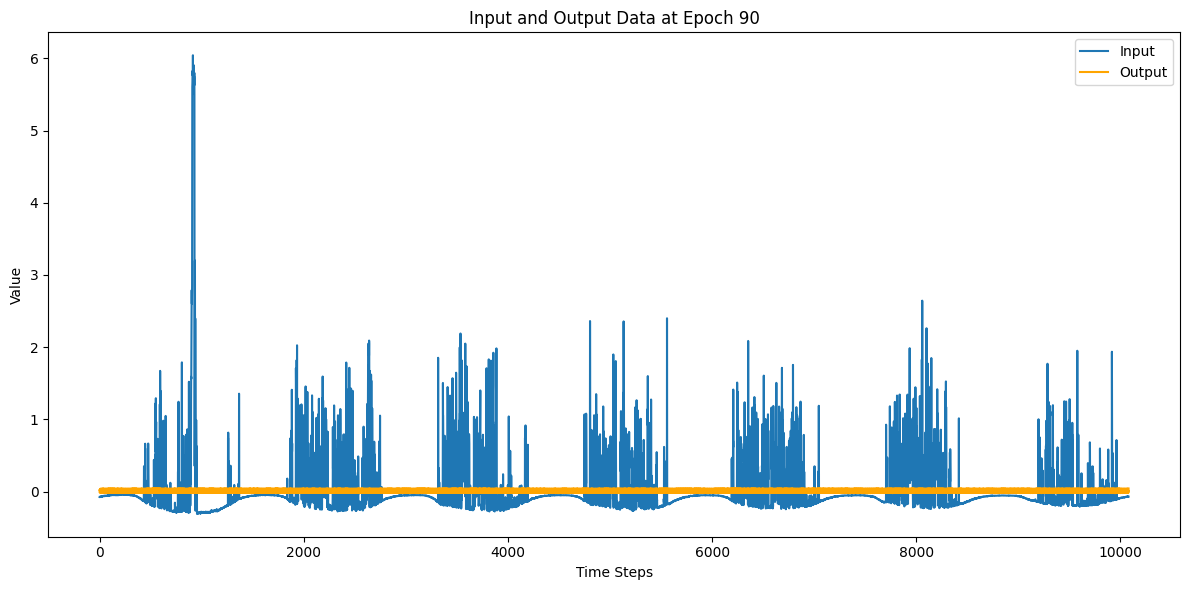

151/151 [==============================] - 8s 55ms/step - loss: 0.8537 - val_loss: 0.3419 - lr: 0.0010
Epoch 91/10000
150/151 [============================>.] - ETA: 0s - loss: 0.3352
Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
151/151 [==============================] - 8s 53ms/step - loss: 0.3337 - val_loss: 0.3475 - lr: 0.0010
Epoch 92/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3902 - val_loss: 0.3509 - lr: 5.0000e-04
Epoch 93/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5657 - val_loss: 0.3551 - lr: 5.0000e-04
Epoch 94/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8282 - val_loss: 0.3514 - lr: 5.0000e-04
Epoch 95/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5759 - val_loss: 0.3317 - lr: 5.0000e-04
Epoch 96/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.8522 - val_loss: 0.3344 - lr: 5.0000e-04
Epoch 97/10000
151/151 [==

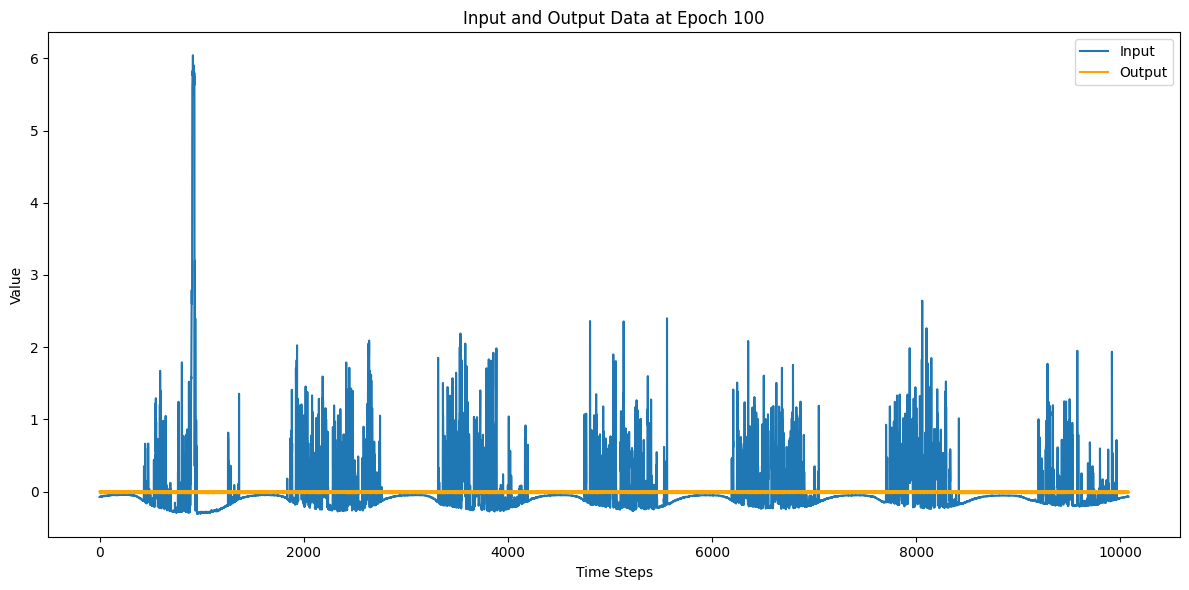

151/151 [==============================] - 8s 55ms/step - loss: 0.8146 - val_loss: 0.3445 - lr: 5.0000e-04
Epoch 101/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.4750 - val_loss: 0.3529 - lr: 5.0000e-04
Epoch 102/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3862 - val_loss: 0.3444 - lr: 5.0000e-04
Epoch 103/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8230 - val_loss: 0.3417 - lr: 5.0000e-04
Epoch 104/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.8976 - val_loss: 0.3354 - lr: 5.0000e-04
Epoch 105/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2597 - val_loss: 0.3544 - lr: 5.0000e-04
Epoch 106/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3186 - val_loss: 0.3175 - lr: 5.0000e-04
Epoch 107/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5956 - val_loss: 0.3378 - lr: 5.0000e-04
Epoch 108/10000
151/151 [=======

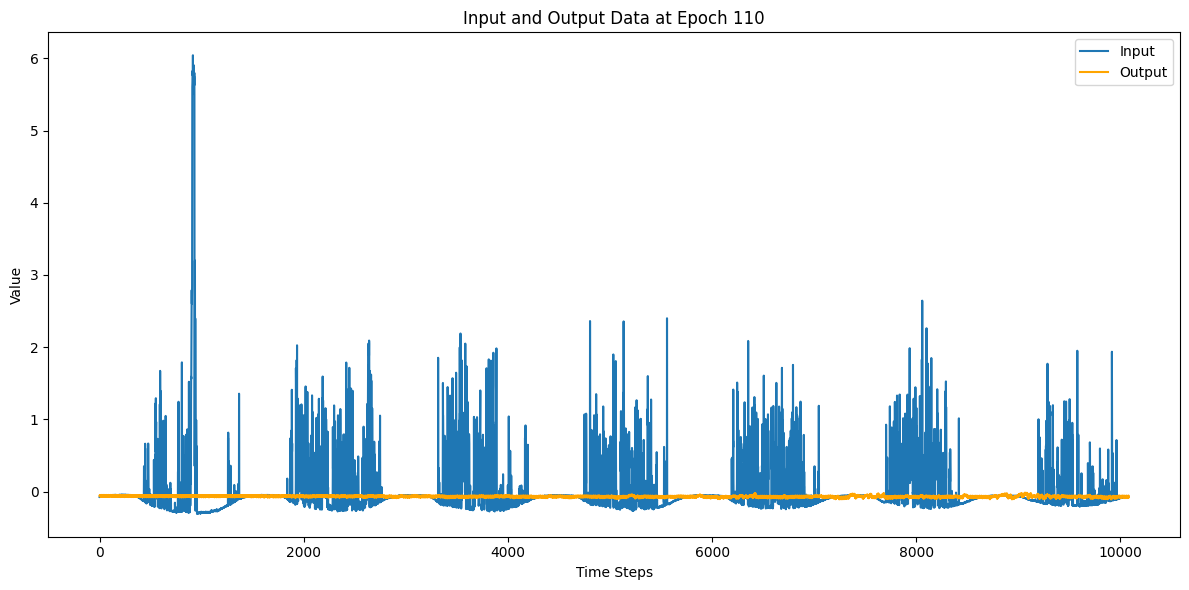

151/151 [==============================] - 8s 55ms/step - loss: 0.7994 - val_loss: 0.3384 - lr: 5.0000e-04
Epoch 111/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6540 - val_loss: 0.3338 - lr: 5.0000e-04
Epoch 112/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5149 - val_loss: 0.3407 - lr: 5.0000e-04
Epoch 113/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9356 - val_loss: 0.3347 - lr: 5.0000e-04
Epoch 114/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9608 - val_loss: 0.3416 - lr: 5.0000e-04
Epoch 115/10000
151/151 [==============================] - 7s 47ms/step - loss: 0.5229 - val_loss: 0.3512 - lr: 5.0000e-04
Epoch 116/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7945 - val_loss: 0.3393 - lr: 5.0000e-04
Epoch 117/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7210 - val_loss: 0.3521 - lr: 5.0000e-04
Epoch 118/10000
151/151 [=======

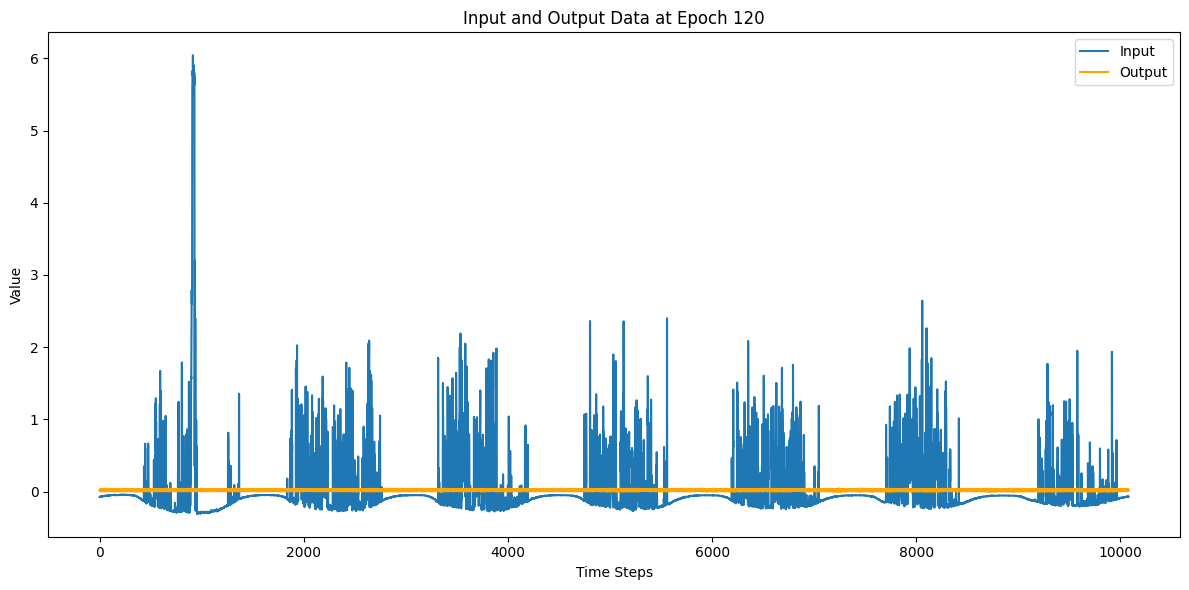

151/151 [==============================] - 8s 55ms/step - loss: 1.2354 - val_loss: 0.3466 - lr: 5.0000e-04
Epoch 121/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.4205 - val_loss: 0.3353 - lr: 5.0000e-04
Epoch 122/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3811 - val_loss: 0.3336 - lr: 5.0000e-04
Epoch 123/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0491 - val_loss: 0.3336 - lr: 5.0000e-04
Epoch 124/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8081 - val_loss: 0.3547 - lr: 5.0000e-04
Epoch 125/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5242 - val_loss: 0.3521 - lr: 5.0000e-04
Epoch 126/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7832 - val_loss: 0.3425 - lr: 5.0000e-04
Epoch 127/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7748 - val_loss: 0.3348 - lr: 5.0000e-04
Epoch 128/10000
151/151 [=======

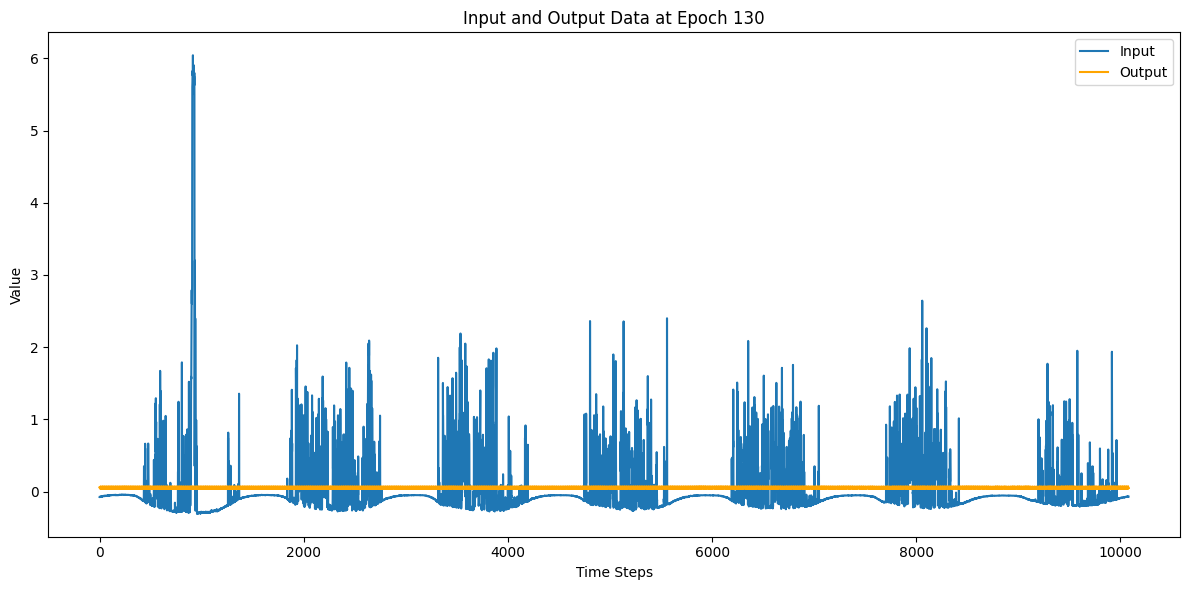

151/151 [==============================] - 8s 56ms/step - loss: 1.6693 - val_loss: 0.3442 - lr: 5.0000e-04
Epoch 131/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9984 - val_loss: 0.3461 - lr: 5.0000e-04
Epoch 132/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6881 - val_loss: 0.3407 - lr: 5.0000e-04
Epoch 133/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0377 - val_loss: 0.3429 - lr: 5.0000e-04
Epoch 134/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5351 - val_loss: 0.3707 - lr: 5.0000e-04
Epoch 135/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8745 - val_loss: 0.3427 - lr: 5.0000e-04
Epoch 136/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3129 - val_loss: 0.3472 - lr: 5.0000e-04
Epoch 137/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.1621 - val_loss: 0.3417 - lr: 5.0000e-04
Epoch 138/10000
151/151 [=======

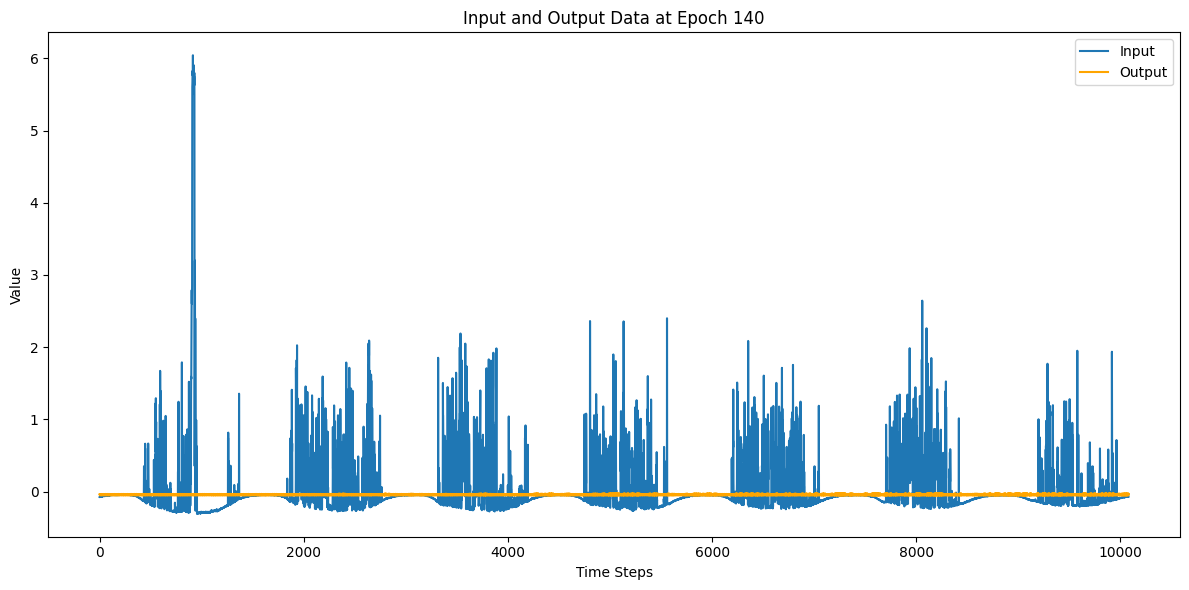

151/151 [==============================] - 8s 55ms/step - loss: 0.7881 - val_loss: 0.3314 - lr: 5.0000e-04
Epoch 141/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5420 - val_loss: 0.3324 - lr: 5.0000e-04
Epoch 142/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.6182 - val_loss: 0.3454 - lr: 5.0000e-04
Epoch 143/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4744 - val_loss: 0.3668 - lr: 5.0000e-04
Epoch 144/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6242 - val_loss: 0.3581 - lr: 5.0000e-04
Epoch 145/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7544 - val_loss: 0.3379 - lr: 5.0000e-04
Epoch 146/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.4426 - val_loss: 0.3376 - lr: 5.0000e-04
Epoch 147/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8796 - val_loss: 0.3451 - lr: 5.0000e-04
Epoch 148/10000
151/151 [=======

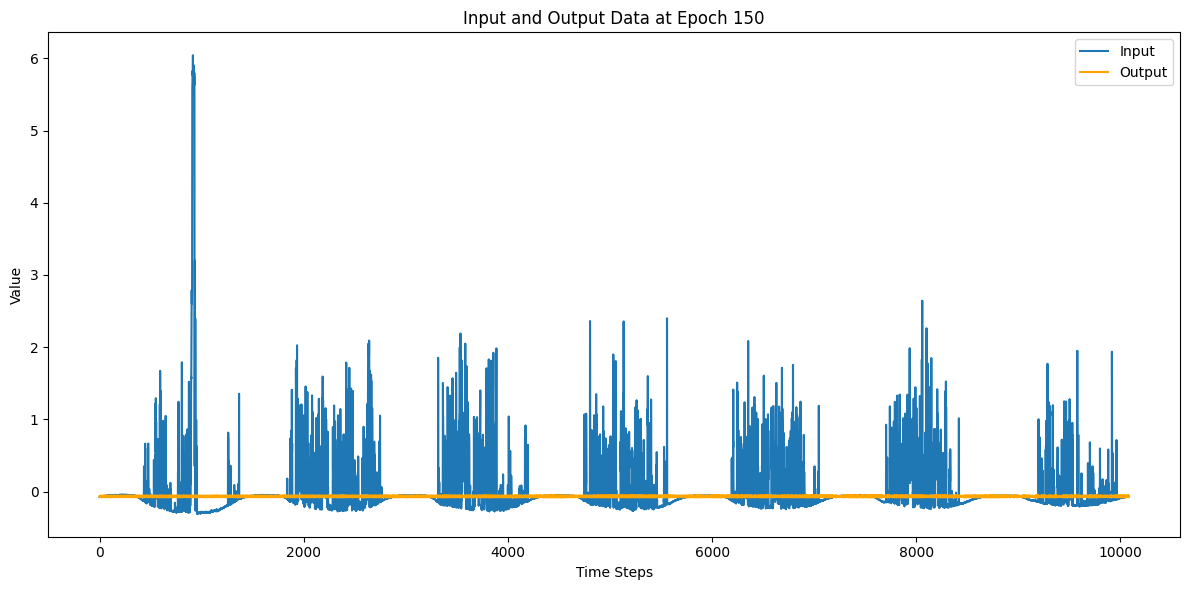

151/151 [==============================] - 8s 56ms/step - loss: 0.5511 - val_loss: 0.3265 - lr: 5.0000e-04
Epoch 151/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4177 - val_loss: 0.3515 - lr: 5.0000e-04
Epoch 152/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6716 - val_loss: 0.3254 - lr: 5.0000e-04
Epoch 153/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.8516 - val_loss: 0.3383 - lr: 5.0000e-04
Epoch 154/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5896 - val_loss: 0.3502 - lr: 5.0000e-04
Epoch 155/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4282 - val_loss: 0.3491 - lr: 5.0000e-04
Epoch 156/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3886 - val_loss: 0.3485 - lr: 5.0000e-04
Epoch 157/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5666 - val_loss: 0.3497 - lr: 5.0000e-04
Epoch 158/10000
151/151 [=======

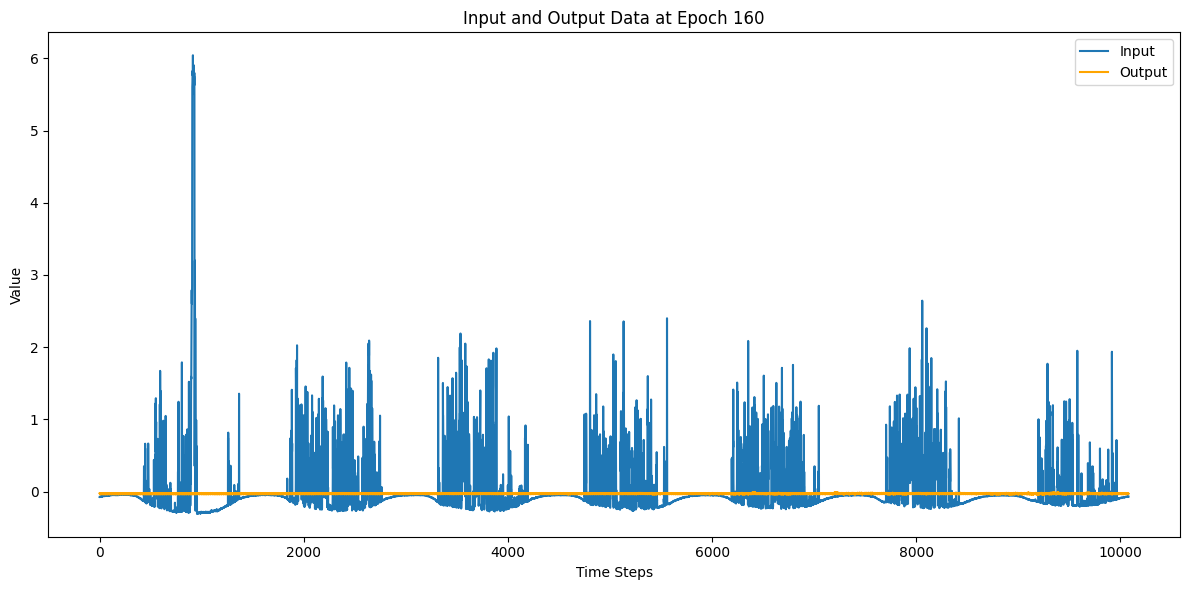

151/151 [==============================] - 8s 56ms/step - loss: 0.4130 - val_loss: 0.3305 - lr: 5.0000e-04
Epoch 161/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5759 - val_loss: 0.3454 - lr: 5.0000e-04
Epoch 162/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.6156 - val_loss: 0.3530 - lr: 5.0000e-04
Epoch 163/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7531 - val_loss: 0.3353 - lr: 5.0000e-04
Epoch 164/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8804 - val_loss: 0.3516 - lr: 5.0000e-04
Epoch 165/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6842 - val_loss: 0.3408 - lr: 5.0000e-04
Epoch 166/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6324 - val_loss: 0.3438 - lr: 5.0000e-04
Epoch 167/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4306 - val_loss: 0.3437 - lr: 5.0000e-04
Epoch 168/10000
151/151 [=======

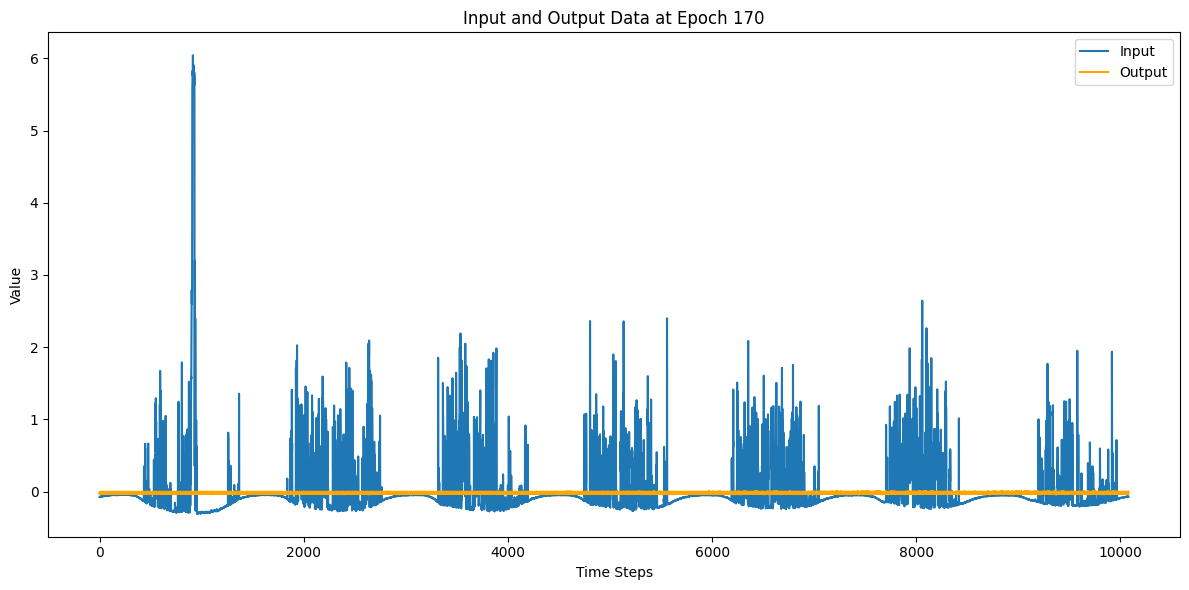

151/151 [==============================] - 8s 55ms/step - loss: 0.6814 - val_loss: 0.3419 - lr: 5.0000e-04
Epoch 171/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6097 - val_loss: 0.3672 - lr: 5.0000e-04
Epoch 172/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6278 - val_loss: 0.3492 - lr: 5.0000e-04
Epoch 173/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.0730 - val_loss: 0.3373 - lr: 5.0000e-04
Epoch 174/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4481 - val_loss: 0.3579 - lr: 5.0000e-04
Epoch 175/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6114 - val_loss: 0.3346 - lr: 5.0000e-04
Epoch 176/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.4011 - val_loss: 0.3296 - lr: 5.0000e-04
Epoch 177/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.3660 - val_loss: 0.3348 - lr: 5.0000e-04
Epoch 178/10000
151/151 [=======

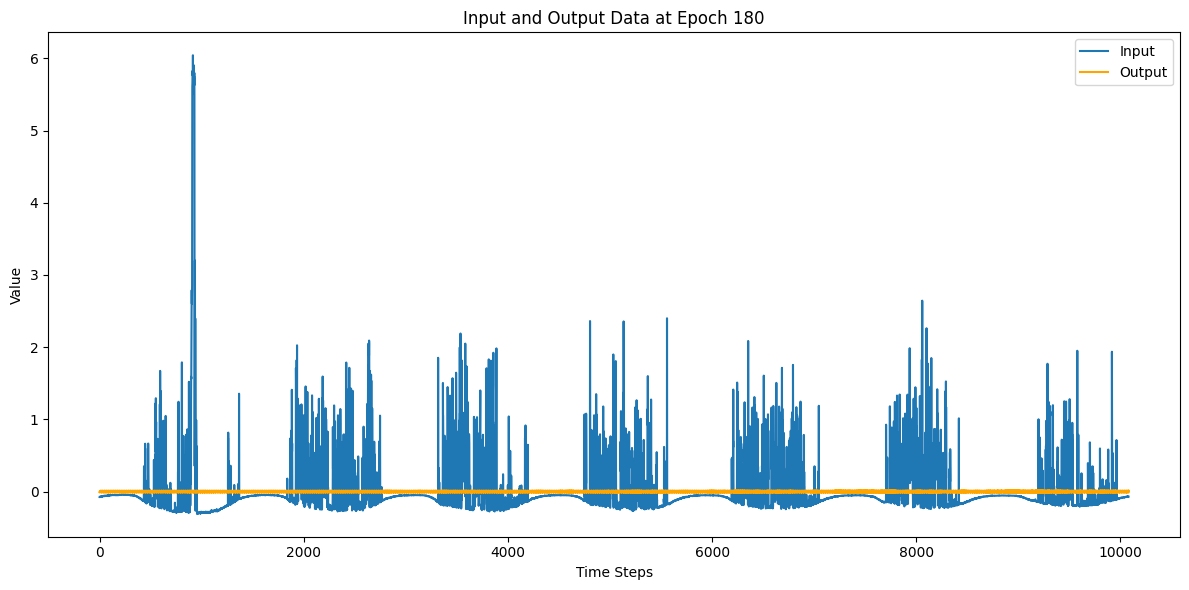

151/151 [==============================] - 8s 55ms/step - loss: 0.5802 - val_loss: 0.3539 - lr: 5.0000e-04
Epoch 181/10000
150/151 [============================>.] - ETA: 0s - loss: 1.8419
Epoch 181: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
151/151 [==============================] - 7s 49ms/step - loss: 1.8322 - val_loss: 0.3363 - lr: 5.0000e-04
Epoch 182/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5547 - val_loss: 0.3408 - lr: 2.5000e-04
Epoch 183/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6011 - val_loss: 0.3408 - lr: 2.5000e-04
Epoch 184/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6168 - val_loss: 0.3398 - lr: 2.5000e-04
Epoch 185/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.7878 - val_loss: 0.3314 - lr: 2.5000e-04
Epoch 186/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0715 - val_loss: 0.3300 - lr: 2.5000e-04
Epoch 187/1

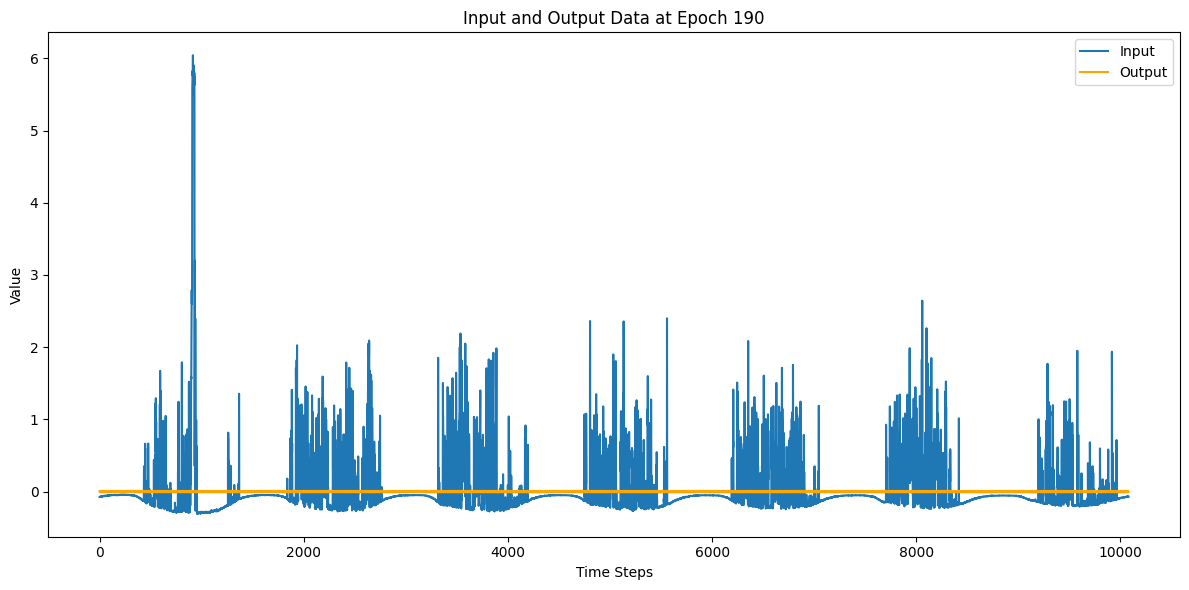

151/151 [==============================] - 8s 55ms/step - loss: 0.5886 - val_loss: 0.3337 - lr: 2.5000e-04
Epoch 191/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5336 - val_loss: 0.3444 - lr: 2.5000e-04
Epoch 192/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7311 - val_loss: 0.3473 - lr: 2.5000e-04
Epoch 193/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.2210 - val_loss: 0.3456 - lr: 2.5000e-04
Epoch 194/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.7438 - val_loss: 0.3408 - lr: 2.5000e-04
Epoch 195/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8675 - val_loss: 0.3584 - lr: 2.5000e-04
Epoch 196/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1928 - val_loss: 0.3519 - lr: 2.5000e-04
Epoch 197/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.4132 - val_loss: 0.3442 - lr: 2.5000e-04
Epoch 198/10000
151/151 [=======

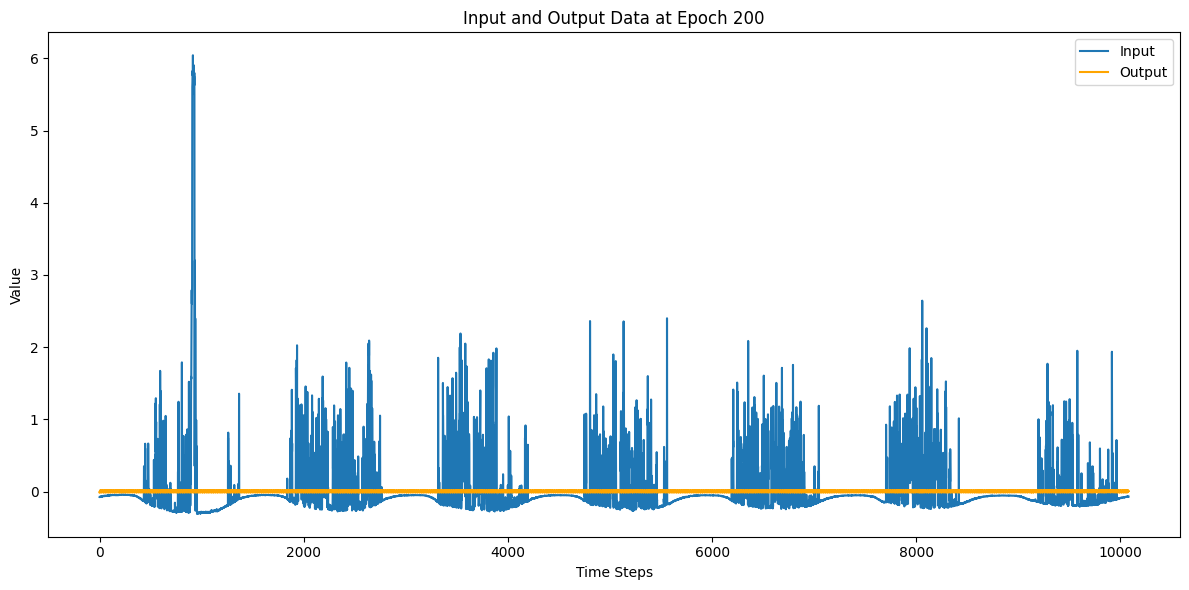

151/151 [==============================] - 8s 55ms/step - loss: 0.9305 - val_loss: 0.3302 - lr: 2.5000e-04
Epoch 201/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9854 - val_loss: 0.3576 - lr: 2.5000e-04
Epoch 202/10000
151/151 [==============================] - 8s 54ms/step - loss: 0.3788 - val_loss: 0.3379 - lr: 2.5000e-04
Epoch 203/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2816 - val_loss: 0.3492 - lr: 2.5000e-04
Epoch 204/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7904 - val_loss: 0.3469 - lr: 2.5000e-04
Epoch 205/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.4334 - val_loss: 0.3449 - lr: 2.5000e-04
Epoch 206/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4741 - val_loss: 0.3577 - lr: 2.5000e-04
Epoch 207/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9493 - val_loss: 0.3402 - lr: 2.5000e-04
Epoch 208/10000
151/151 [=======

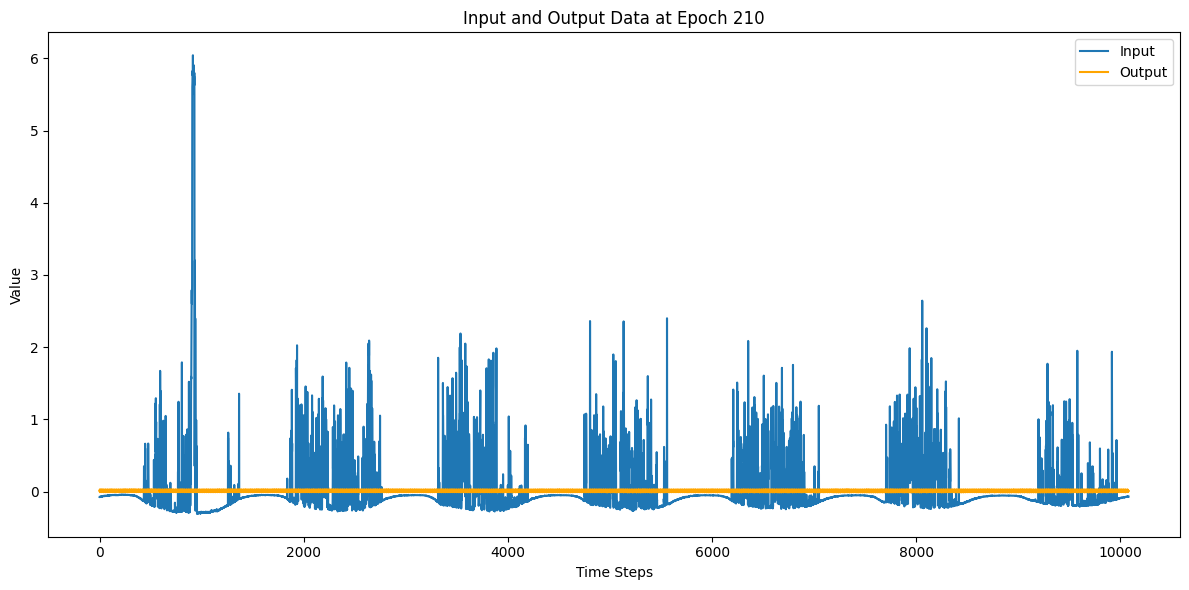

151/151 [==============================] - 8s 56ms/step - loss: 1.1462 - val_loss: 0.3353 - lr: 2.5000e-04
Epoch 211/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5198 - val_loss: 0.3248 - lr: 2.5000e-04
Epoch 212/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6006 - val_loss: 0.3535 - lr: 2.5000e-04
Epoch 213/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3644 - val_loss: 0.3252 - lr: 2.5000e-04
Epoch 214/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.1025 - val_loss: 0.3578 - lr: 2.5000e-04
Epoch 215/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9339 - val_loss: 0.3241 - lr: 2.5000e-04
Epoch 216/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5796 - val_loss: 0.3495 - lr: 2.5000e-04
Epoch 217/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6061 - val_loss: 0.3317 - lr: 2.5000e-04
Epoch 218/10000
151/151 [=======

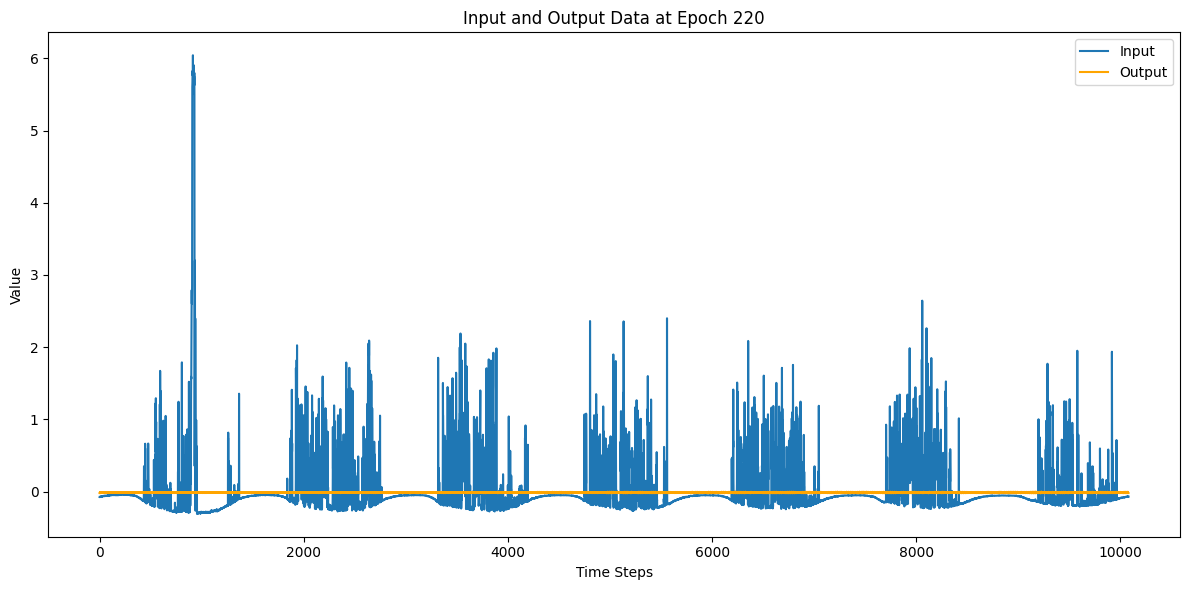

151/151 [==============================] - 8s 56ms/step - loss: 0.5935 - val_loss: 0.3409 - lr: 2.5000e-04
Epoch 221/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9221 - val_loss: 0.3407 - lr: 2.5000e-04
Epoch 222/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8322 - val_loss: 0.3383 - lr: 2.5000e-04
Epoch 223/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.4253 - val_loss: 0.3474 - lr: 2.5000e-04
Epoch 224/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8976 - val_loss: 0.3378 - lr: 2.5000e-04
Epoch 225/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1352 - val_loss: 0.3430 - lr: 2.5000e-04
Epoch 226/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.7079 - val_loss: 0.3444 - lr: 2.5000e-04
Epoch 227/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7329 - val_loss: 0.3376 - lr: 2.5000e-04
Epoch 228/10000
151/151 [=======

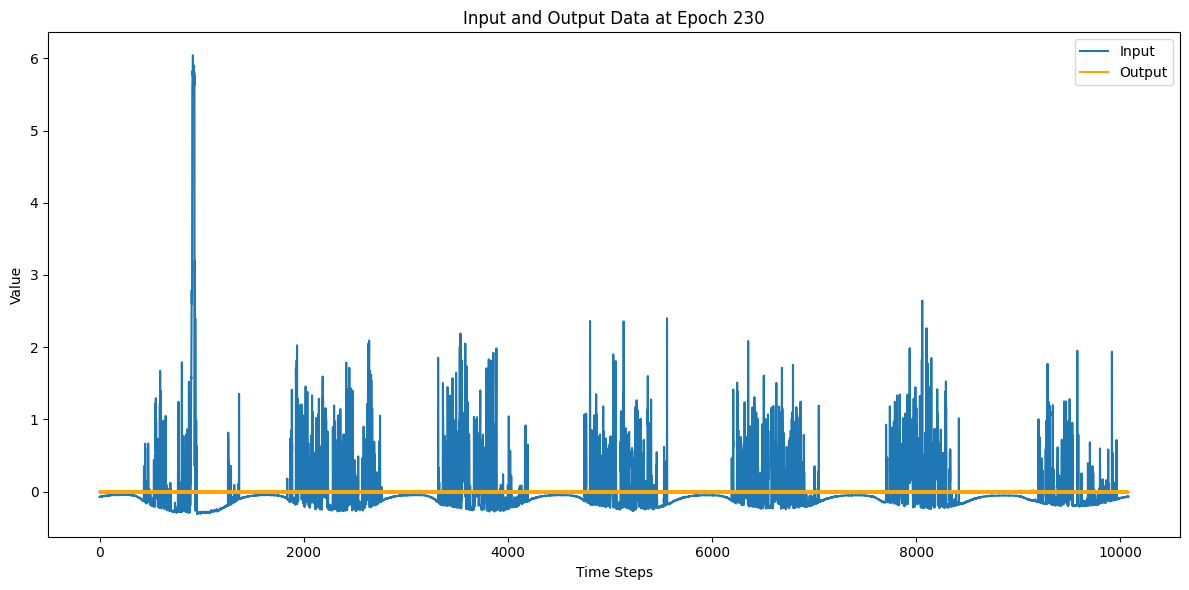

151/151 [==============================] - 9s 60ms/step - loss: 0.8555 - val_loss: 0.3392 - lr: 2.5000e-04
Epoch 231/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6493 - val_loss: 0.3442 - lr: 2.5000e-04
Epoch 232/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.8255 - val_loss: 0.3345 - lr: 2.5000e-04
Epoch 233/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6772 - val_loss: 0.3383 - lr: 2.5000e-04
Epoch 234/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9920 - val_loss: 0.3477 - lr: 2.5000e-04
Epoch 235/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5802 - val_loss: 0.3359 - lr: 2.5000e-04
Epoch 236/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7610 - val_loss: 0.3535 - lr: 2.5000e-04
Epoch 237/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9389 - val_loss: 0.3346 - lr: 2.5000e-04
Epoch 238/10000
151/151 [=======

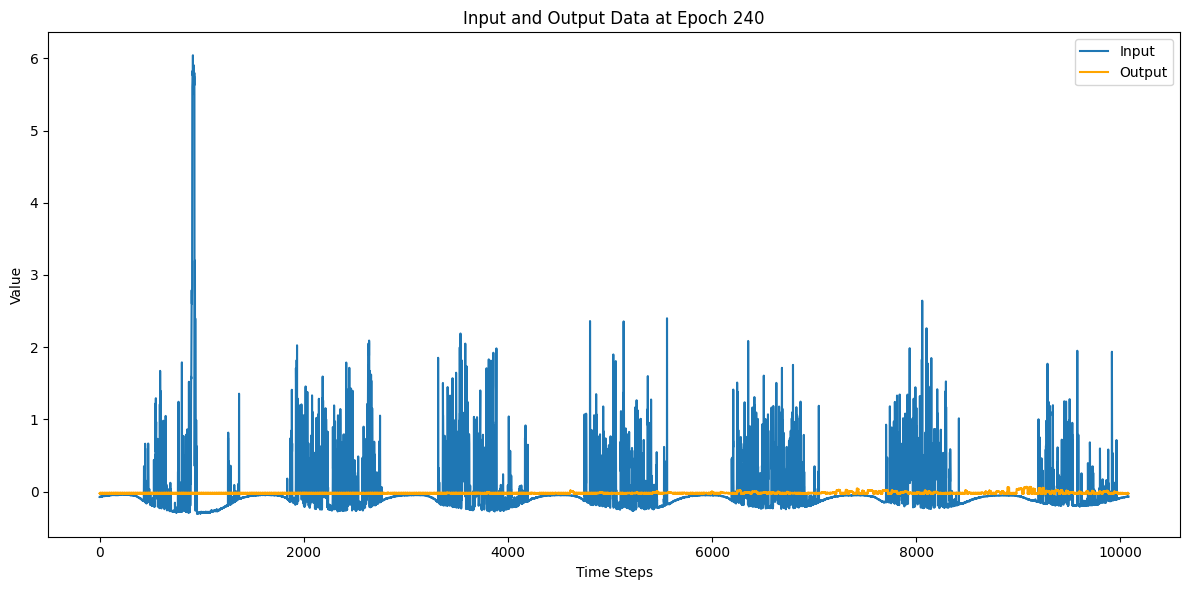

151/151 [==============================] - 8s 56ms/step - loss: 0.5241 - val_loss: 0.3514 - lr: 2.5000e-04
Epoch 241/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3828 - val_loss: 0.3320 - lr: 2.5000e-04
Epoch 242/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.6996 - val_loss: 0.3427 - lr: 2.5000e-04
Epoch 243/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6530 - val_loss: 0.3397 - lr: 2.5000e-04
Epoch 244/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6771 - val_loss: 0.3477 - lr: 2.5000e-04
Epoch 245/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9886 - val_loss: 0.3386 - lr: 2.5000e-04
Epoch 246/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0999 - val_loss: 0.3301 - lr: 2.5000e-04
Epoch 247/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9930 - val_loss: 0.3440 - lr: 2.5000e-04
Epoch 248/10000
151/151 [=======

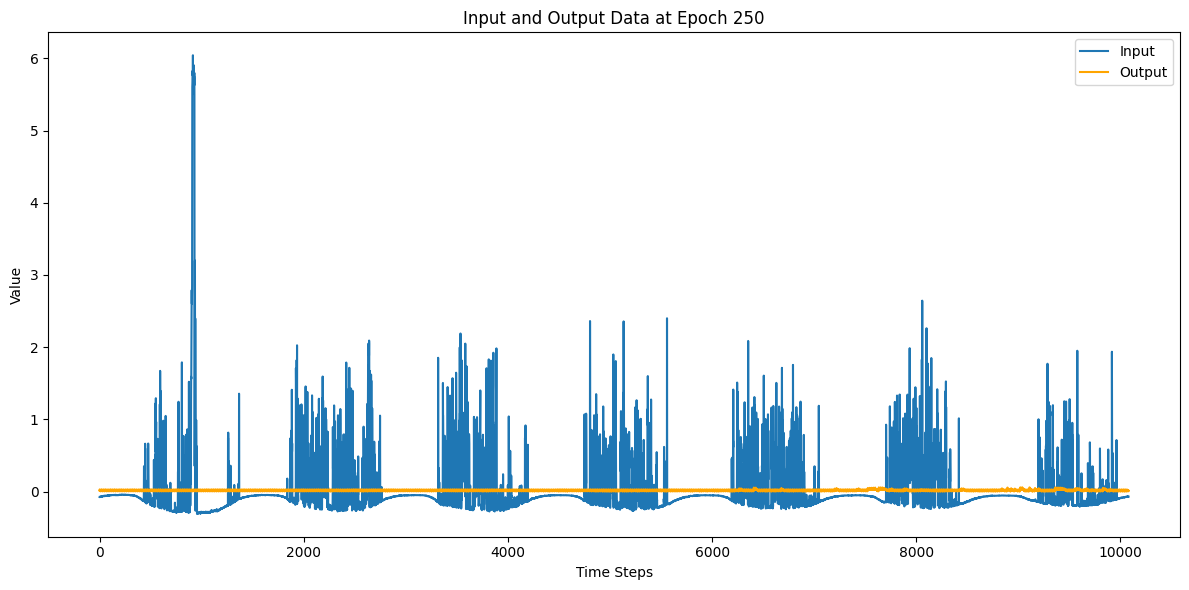

151/151 [==============================] - 8s 55ms/step - loss: 0.5198 - val_loss: 0.3331 - lr: 2.5000e-04
Epoch 251/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.5685 - val_loss: 0.3318 - lr: 2.5000e-04
Epoch 252/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1086 - val_loss: 0.3401 - lr: 2.5000e-04
Epoch 253/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5763 - val_loss: 0.3425 - lr: 2.5000e-04
Epoch 254/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2591 - val_loss: 0.3349 - lr: 2.5000e-04
Epoch 255/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5326 - val_loss: 0.3341 - lr: 2.5000e-04
Epoch 256/10000
150/151 [============================>.] - ETA: 0s - loss: 1.1618
Epoch 256: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
151/151 [==============================] - 7s 49ms/step - loss: 1.1547 - val_loss: 0.3454 - lr: 2.5000e-04
Epoch 257/1

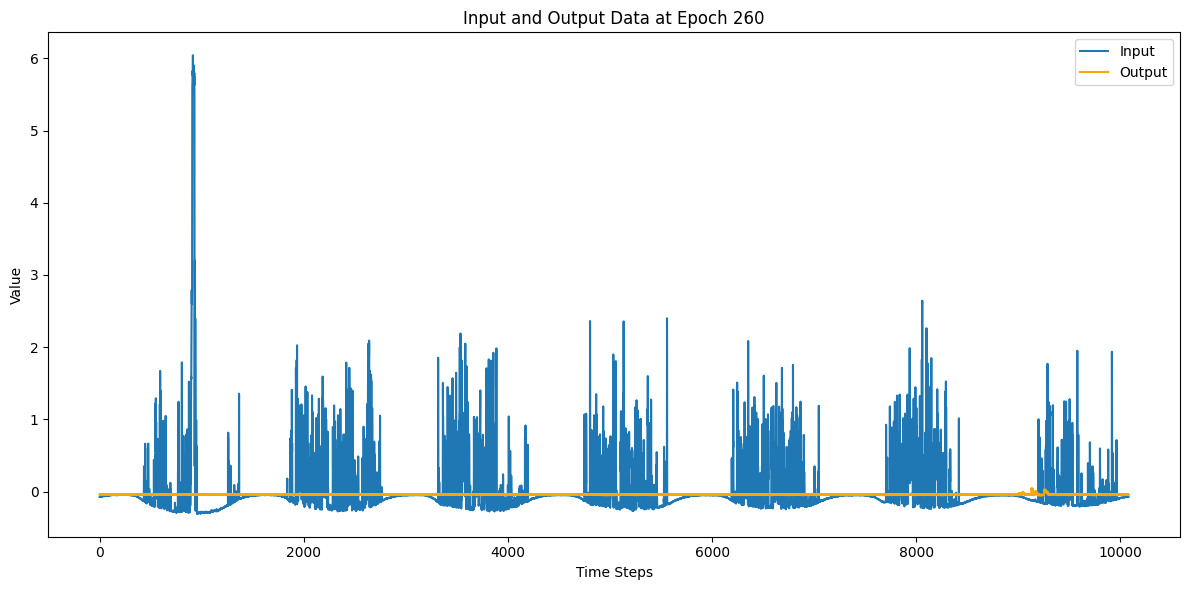

151/151 [==============================] - 8s 55ms/step - loss: 0.3702 - val_loss: 0.3469 - lr: 1.2500e-04
Epoch 261/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9396 - val_loss: 0.3412 - lr: 1.2500e-04
Epoch 262/10000
151/151 [==============================] - 8s 50ms/step - loss: 2.0133 - val_loss: 0.3353 - lr: 1.2500e-04
Epoch 263/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4818 - val_loss: 0.3412 - lr: 1.2500e-04
Epoch 264/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3092 - val_loss: 0.3489 - lr: 1.2500e-04
Epoch 265/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8998 - val_loss: 0.3388 - lr: 1.2500e-04
Epoch 266/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5820 - val_loss: 0.3546 - lr: 1.2500e-04
Epoch 267/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5746 - val_loss: 0.3381 - lr: 1.2500e-04
Epoch 268/10000
151/151 [=======

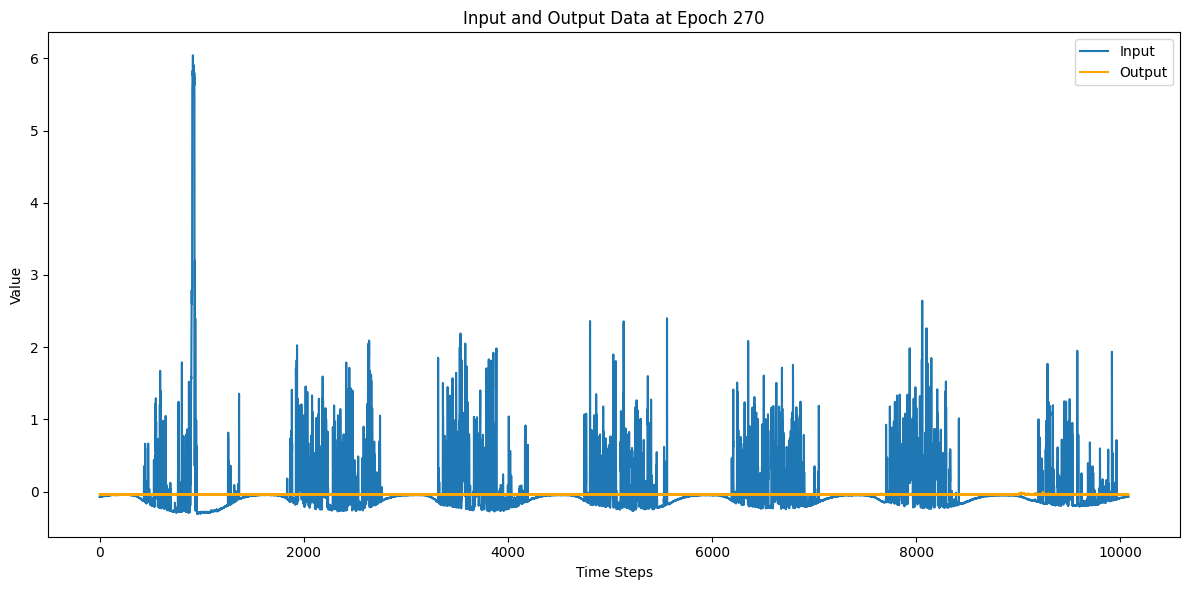

151/151 [==============================] - 8s 55ms/step - loss: 0.3945 - val_loss: 0.3384 - lr: 1.2500e-04
Epoch 271/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6776 - val_loss: 0.3407 - lr: 1.2500e-04
Epoch 272/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4695 - val_loss: 0.3370 - lr: 1.2500e-04
Epoch 273/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7085 - val_loss: 0.3575 - lr: 1.2500e-04
Epoch 274/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3520 - val_loss: 0.3391 - lr: 1.2500e-04
Epoch 275/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3444 - val_loss: 0.3473 - lr: 1.2500e-04
Epoch 276/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3849 - val_loss: 0.3471 - lr: 1.2500e-04
Epoch 277/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.5389 - val_loss: 0.3371 - lr: 1.2500e-04
Epoch 278/10000
151/151 [=======

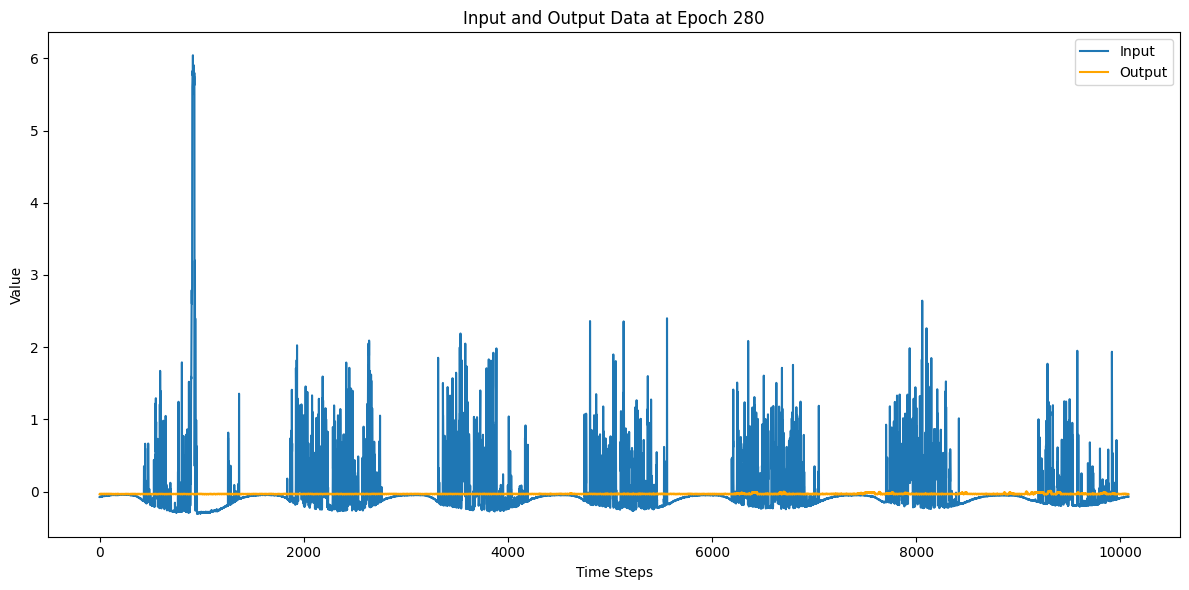

151/151 [==============================] - 8s 56ms/step - loss: 1.1263 - val_loss: 0.3435 - lr: 1.2500e-04
Epoch 281/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5469 - val_loss: 0.3391 - lr: 1.2500e-04
Epoch 282/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1565 - val_loss: 0.3550 - lr: 1.2500e-04
Epoch 283/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3290 - val_loss: 0.3480 - lr: 1.2500e-04
Epoch 284/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7585 - val_loss: 0.3376 - lr: 1.2500e-04
Epoch 285/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6547 - val_loss: 0.3352 - lr: 1.2500e-04
Epoch 286/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.5459 - val_loss: 0.3285 - lr: 1.2500e-04
Epoch 287/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8399 - val_loss: 0.3496 - lr: 1.2500e-04
Epoch 288/10000
151/151 [=======

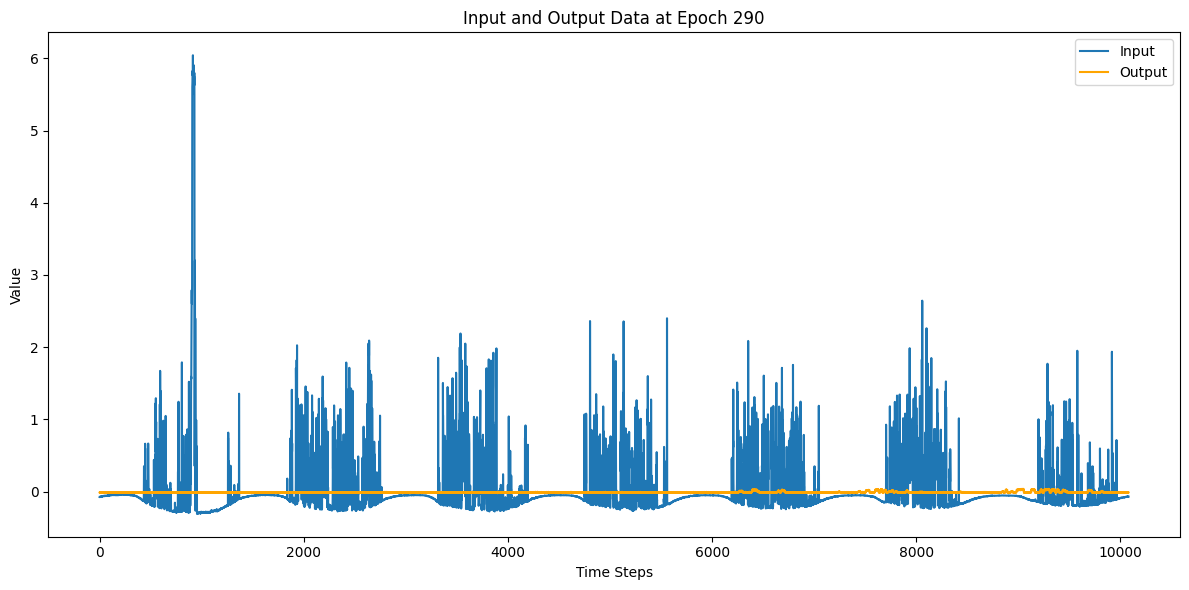

151/151 [==============================] - 8s 56ms/step - loss: 0.4286 - val_loss: 0.3462 - lr: 1.2500e-04
Epoch 291/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.7290 - val_loss: 0.3209 - lr: 1.2500e-04
Epoch 292/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4168 - val_loss: 0.3401 - lr: 1.2500e-04
Epoch 293/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3781 - val_loss: 0.3414 - lr: 1.2500e-04
Epoch 294/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.3141 - val_loss: 0.3374 - lr: 1.2500e-04
Epoch 295/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.6361 - val_loss: 0.3391 - lr: 1.2500e-04
Epoch 296/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7649 - val_loss: 0.3156 - lr: 1.2500e-04
Epoch 297/10000
151/151 [==============================] - 8s 51ms/step - loss: 1.0626 - val_loss: 0.3478 - lr: 1.2500e-04
Epoch 298/10000
151/151 [=======

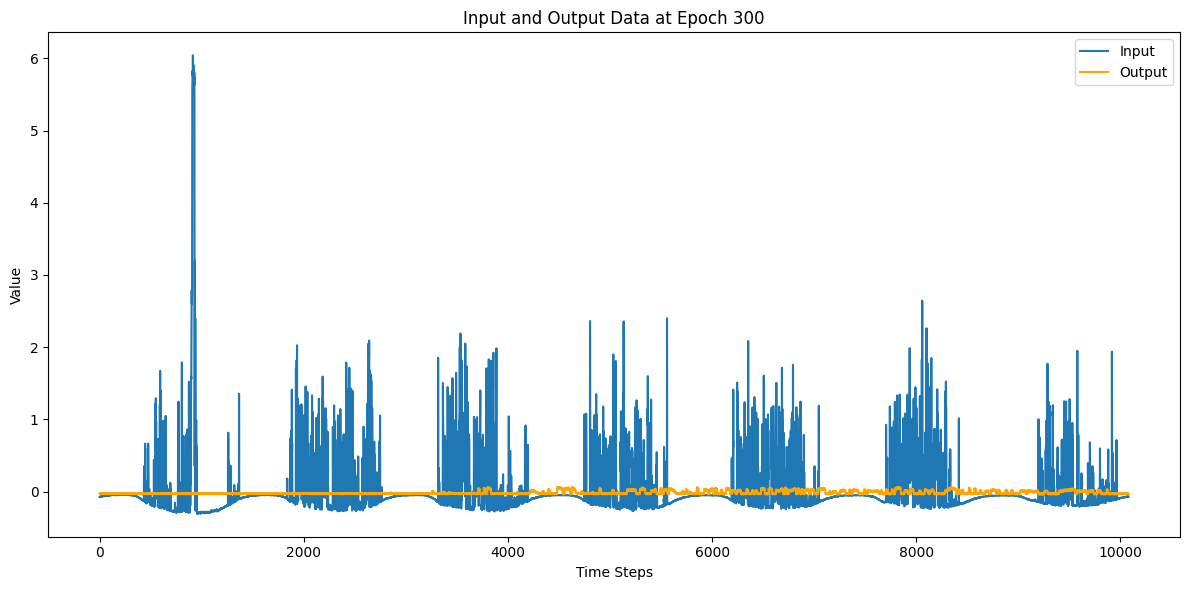

151/151 [==============================] - 8s 56ms/step - loss: 1.3616 - val_loss: 0.3296 - lr: 1.2500e-04
Epoch 301/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4277 - val_loss: 0.3319 - lr: 1.2500e-04
Epoch 302/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7914 - val_loss: 0.3380 - lr: 1.2500e-04
Epoch 303/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4570 - val_loss: 0.3255 - lr: 1.2500e-04
Epoch 304/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.7145 - val_loss: 0.3371 - lr: 1.2500e-04
Epoch 305/10000
151/151 [==============================] - 7s 48ms/step - loss: 2.0809 - val_loss: 0.3418 - lr: 1.2500e-04
Epoch 306/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.3405 - val_loss: 0.3495 - lr: 1.2500e-04
Epoch 307/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.7447 - val_loss: 0.3210 - lr: 1.2500e-04
Epoch 308/10000
151/151 [=======

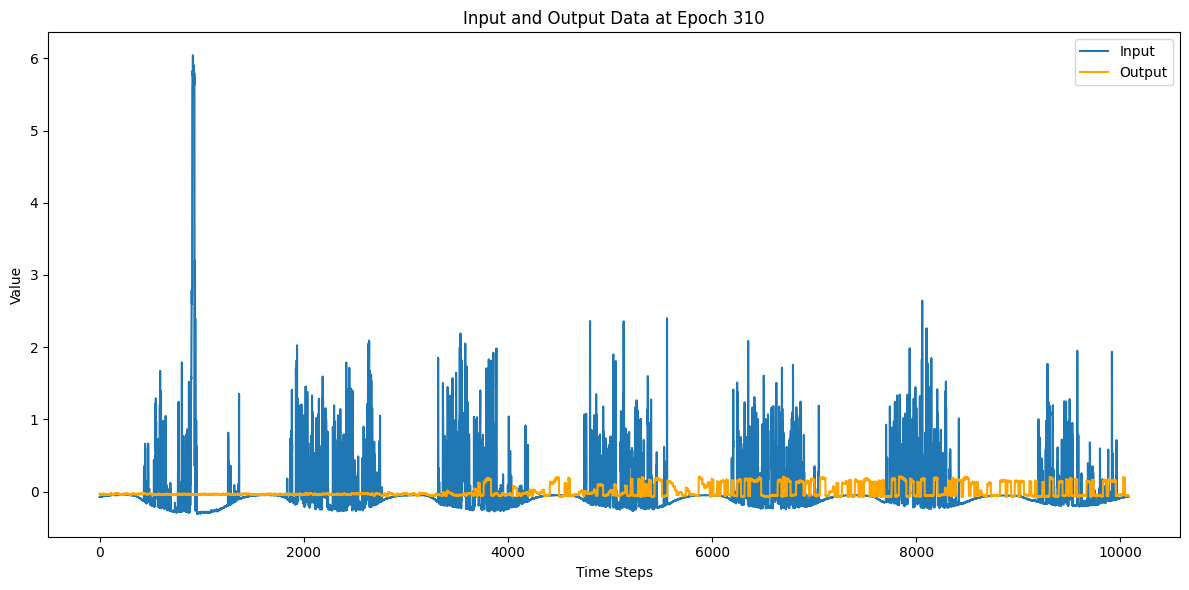

151/151 [==============================] - 8s 55ms/step - loss: 0.9177 - val_loss: 0.3388 - lr: 1.2500e-04
Epoch 311/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1119 - val_loss: 0.3403 - lr: 1.2500e-04
Epoch 312/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.8483 - val_loss: 0.3218 - lr: 1.2500e-04
Epoch 313/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4113 - val_loss: 0.3278 - lr: 1.2500e-04
Epoch 314/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1314 - val_loss: 0.3464 - lr: 1.2500e-04
Epoch 315/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5218 - val_loss: 0.3393 - lr: 1.2500e-04
Epoch 316/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.6144 - val_loss: 0.3221 - lr: 1.2500e-04
Epoch 317/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.7409 - val_loss: 0.3321 - lr: 1.2500e-04
Epoch 318/10000
151/151 [=======

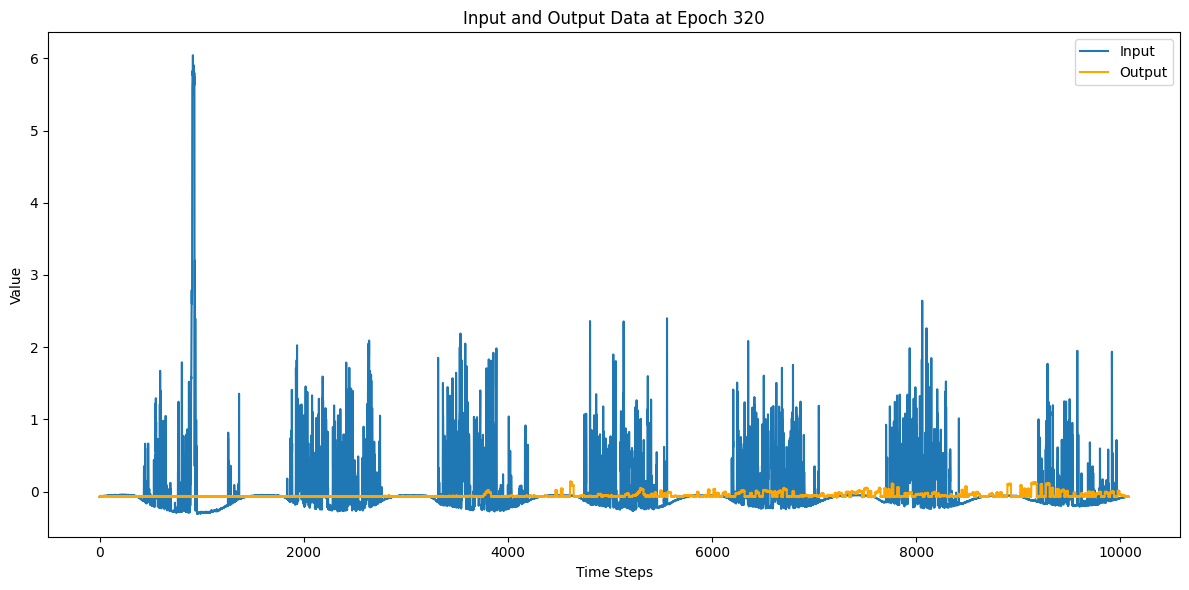

151/151 [==============================] - 8s 56ms/step - loss: 0.3268 - val_loss: 0.3186 - lr: 1.2500e-04
Epoch 321/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0988 - val_loss: 0.3195 - lr: 1.2500e-04
Epoch 322/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.9154 - val_loss: 0.3282 - lr: 1.2500e-04
Epoch 323/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7167 - val_loss: 0.3226 - lr: 1.2500e-04
Epoch 324/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3276 - val_loss: 0.3468 - lr: 1.2500e-04
Epoch 325/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7047 - val_loss: 0.3246 - lr: 1.2500e-04
Epoch 326/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7736 - val_loss: 0.3252 - lr: 1.2500e-04
Epoch 327/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5325 - val_loss: 0.3206 - lr: 1.2500e-04
Epoch 328/10000
151/151 [=======

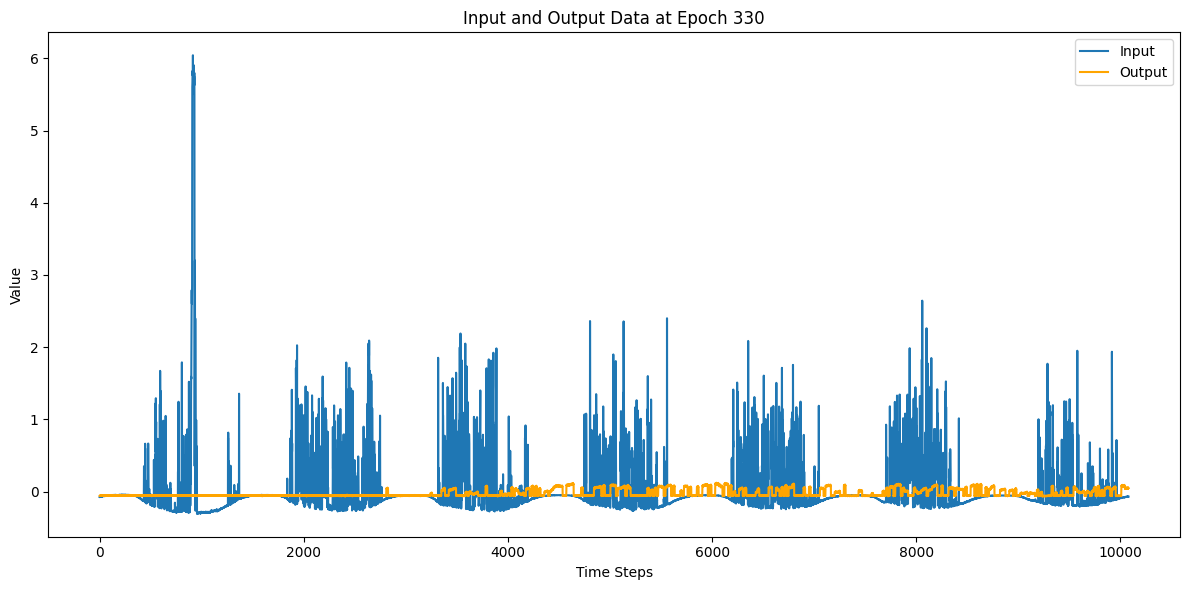

151/151 [==============================] - 8s 56ms/step - loss: 0.5320 - val_loss: 0.3111 - lr: 1.2500e-04
Epoch 331/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6918 - val_loss: 0.3291 - lr: 1.2500e-04
Epoch 332/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.4882 - val_loss: 0.3320 - lr: 1.2500e-04
Epoch 333/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6351 - val_loss: 0.3342 - lr: 1.2500e-04
Epoch 334/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3357 - val_loss: 0.3245 - lr: 1.2500e-04
Epoch 335/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5185 - val_loss: 0.3385 - lr: 1.2500e-04
Epoch 336/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5751 - val_loss: 0.3310 - lr: 1.2500e-04
Epoch 337/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7152 - val_loss: 0.3092 - lr: 1.2500e-04
Epoch 338/10000
151/151 [=======

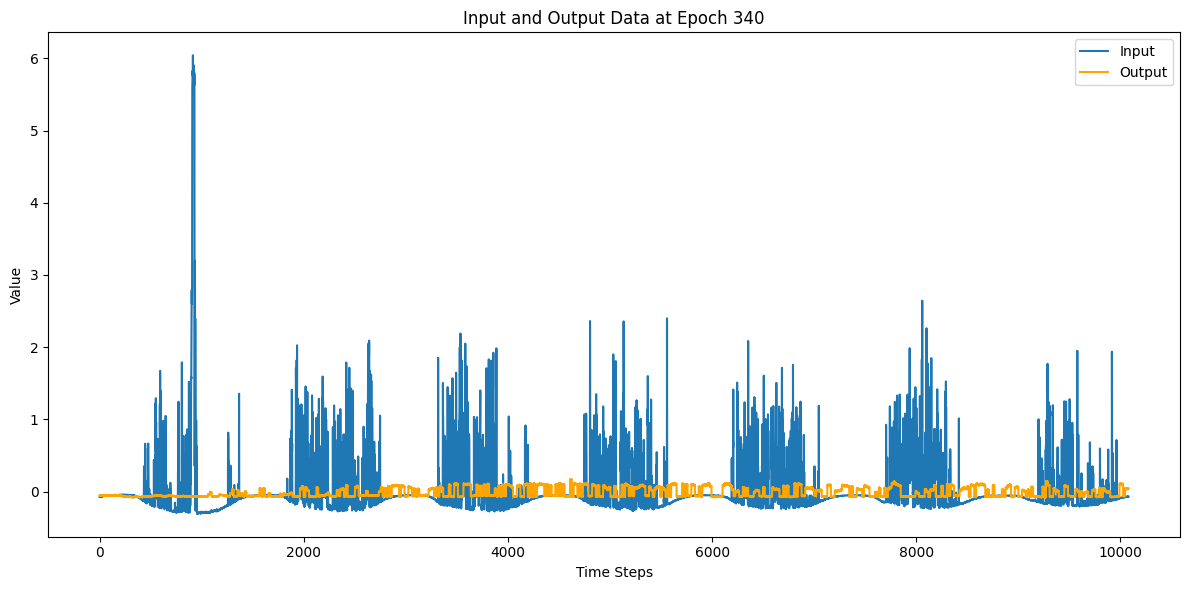

151/151 [==============================] - 9s 57ms/step - loss: 0.5940 - val_loss: 0.3021 - lr: 1.2500e-04
Epoch 341/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5508 - val_loss: 0.3154 - lr: 1.2500e-04
Epoch 342/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7329 - val_loss: 0.3072 - lr: 1.2500e-04
Epoch 343/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.1381 - val_loss: 0.3369 - lr: 1.2500e-04
Epoch 344/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5683 - val_loss: 0.3048 - lr: 1.2500e-04
Epoch 345/10000
151/151 [==============================] - 8s 53ms/step - loss: 1.3236 - val_loss: 0.3169 - lr: 1.2500e-04
Epoch 346/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.9648 - val_loss: 0.3300 - lr: 1.2500e-04
Epoch 347/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7675 - val_loss: 0.3215 - lr: 1.2500e-04
Epoch 348/10000
151/151 [=======

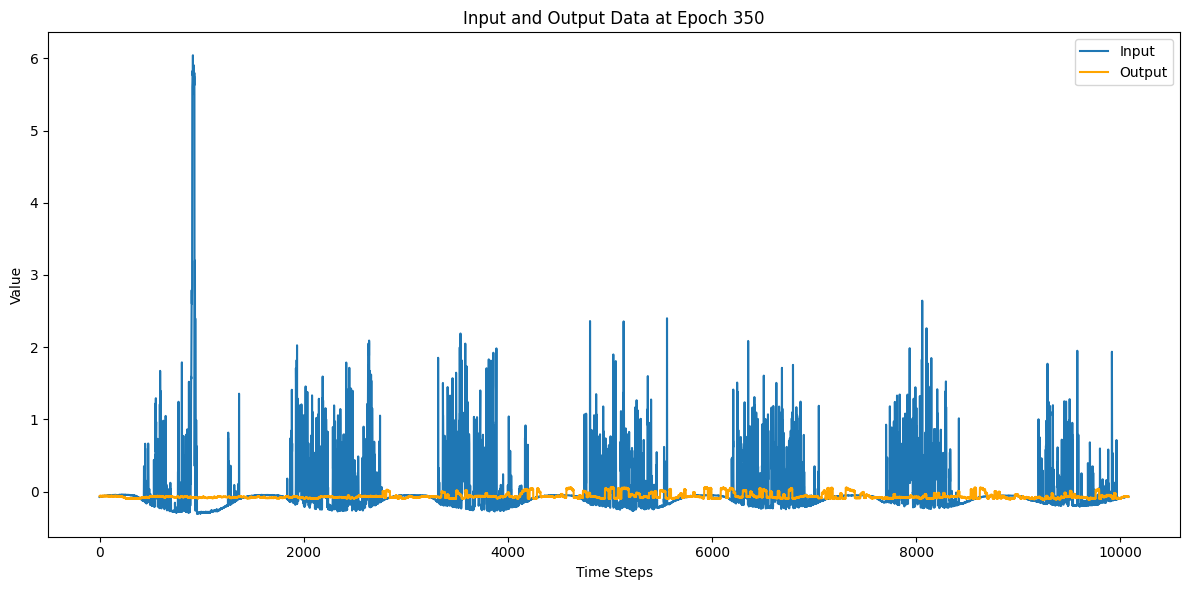

151/151 [==============================] - 8s 56ms/step - loss: 0.4993 - val_loss: 0.3331 - lr: 1.2500e-04
Epoch 351/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.3939 - val_loss: 0.3183 - lr: 1.2500e-04
Epoch 352/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3312 - val_loss: 0.3192 - lr: 1.2500e-04
Epoch 353/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2160 - val_loss: 0.3208 - lr: 1.2500e-04
Epoch 354/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9640 - val_loss: 0.3087 - lr: 1.2500e-04
Epoch 355/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3741 - val_loss: 0.3104 - lr: 1.2500e-04
Epoch 356/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5694 - val_loss: 0.3292 - lr: 1.2500e-04
Epoch 357/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.0462 - val_loss: 0.3061 - lr: 1.2500e-04
Epoch 358/10000
151/151 [=======

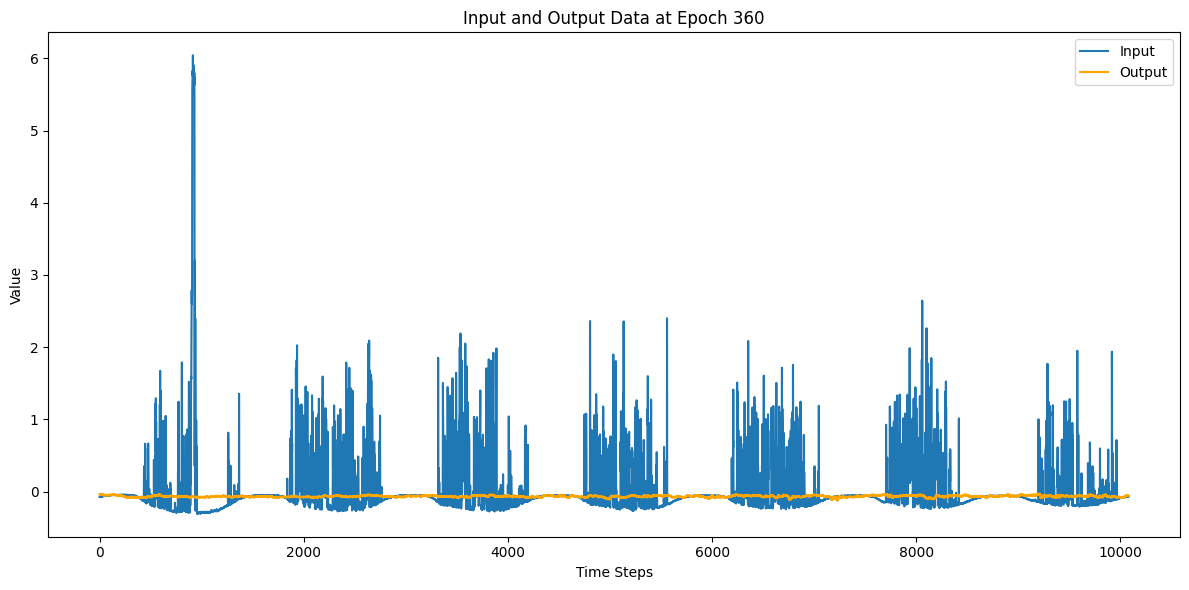

151/151 [==============================] - 8s 56ms/step - loss: 0.9006 - val_loss: 0.3069 - lr: 1.2500e-04
Epoch 361/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5558 - val_loss: 0.2928 - lr: 1.2500e-04
Epoch 362/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5968 - val_loss: 0.3063 - lr: 1.2500e-04
Epoch 363/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8471 - val_loss: 0.3104 - lr: 1.2500e-04
Epoch 364/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.4673 - val_loss: 0.3071 - lr: 1.2500e-04
Epoch 365/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5974 - val_loss: 0.3189 - lr: 1.2500e-04
Epoch 366/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3253 - val_loss: 0.3003 - lr: 1.2500e-04
Epoch 367/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6843 - val_loss: 0.3013 - lr: 1.2500e-04
Epoch 368/10000
151/151 [=======

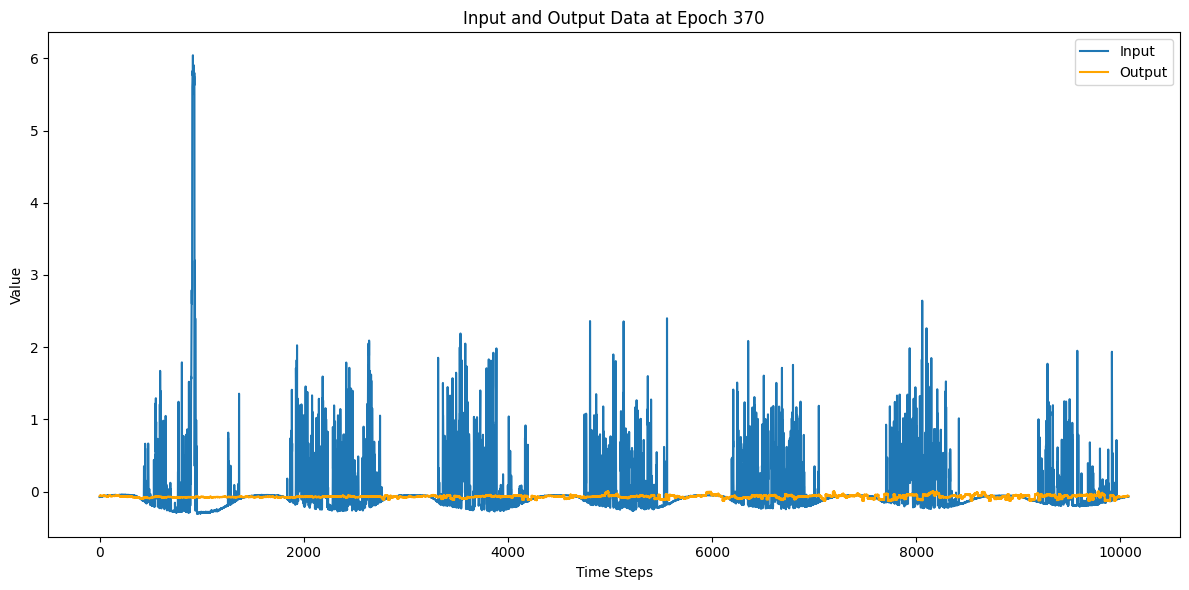

151/151 [==============================] - 8s 56ms/step - loss: 0.5068 - val_loss: 0.3107 - lr: 1.2500e-04
Epoch 371/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7665 - val_loss: 0.2989 - lr: 1.2500e-04
Epoch 372/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7318 - val_loss: 0.3048 - lr: 1.2500e-04
Epoch 373/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.2883 - val_loss: 0.3105 - lr: 1.2500e-04
Epoch 374/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2913 - val_loss: 0.2985 - lr: 1.2500e-04
Epoch 375/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0847 - val_loss: 0.2946 - lr: 1.2500e-04
Epoch 376/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3514 - val_loss: 0.3010 - lr: 1.2500e-04
Epoch 377/10000
151/151 [==============================] - 8s 51ms/step - loss: 1.0693 - val_loss: 0.2924 - lr: 1.2500e-04
Epoch 378/10000
151/151 [=======

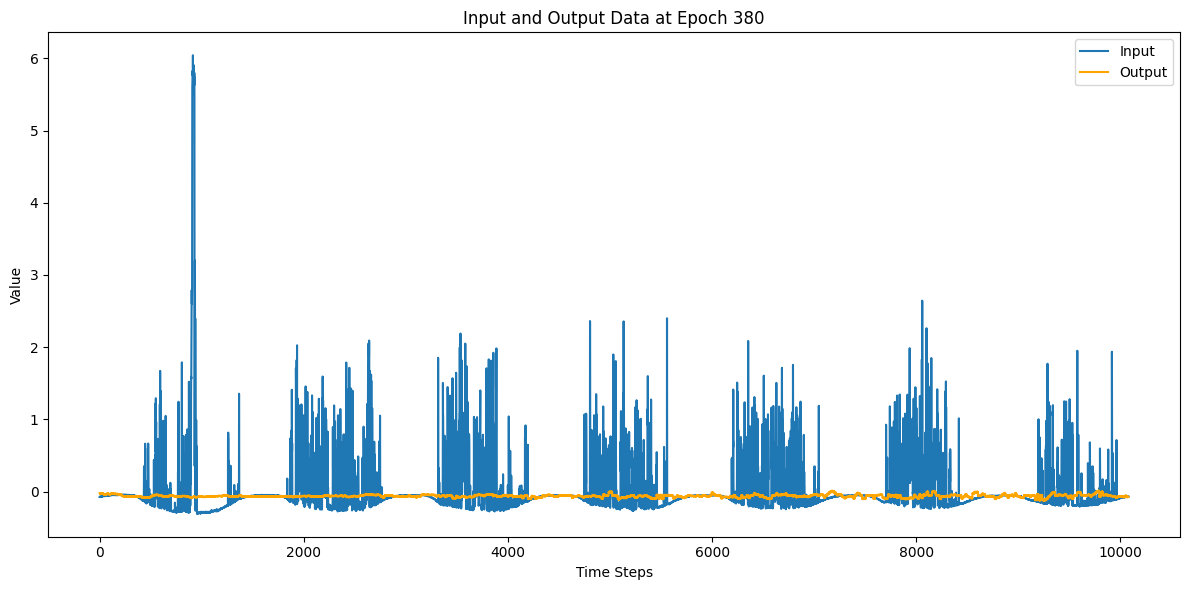

151/151 [==============================] - 9s 57ms/step - loss: 1.1053 - val_loss: 0.2745 - lr: 1.2500e-04
Epoch 381/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6835 - val_loss: 0.3062 - lr: 1.2500e-04
Epoch 382/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.7006 - val_loss: 0.2962 - lr: 1.2500e-04
Epoch 383/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6675 - val_loss: 0.2914 - lr: 1.2500e-04
Epoch 384/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6908 - val_loss: 0.2897 - lr: 1.2500e-04
Epoch 385/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5684 - val_loss: 0.2968 - lr: 1.2500e-04
Epoch 386/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.7745 - val_loss: 0.2935 - lr: 1.2500e-04
Epoch 387/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8842 - val_loss: 0.2811 - lr: 1.2500e-04
Epoch 388/10000
151/151 [=======

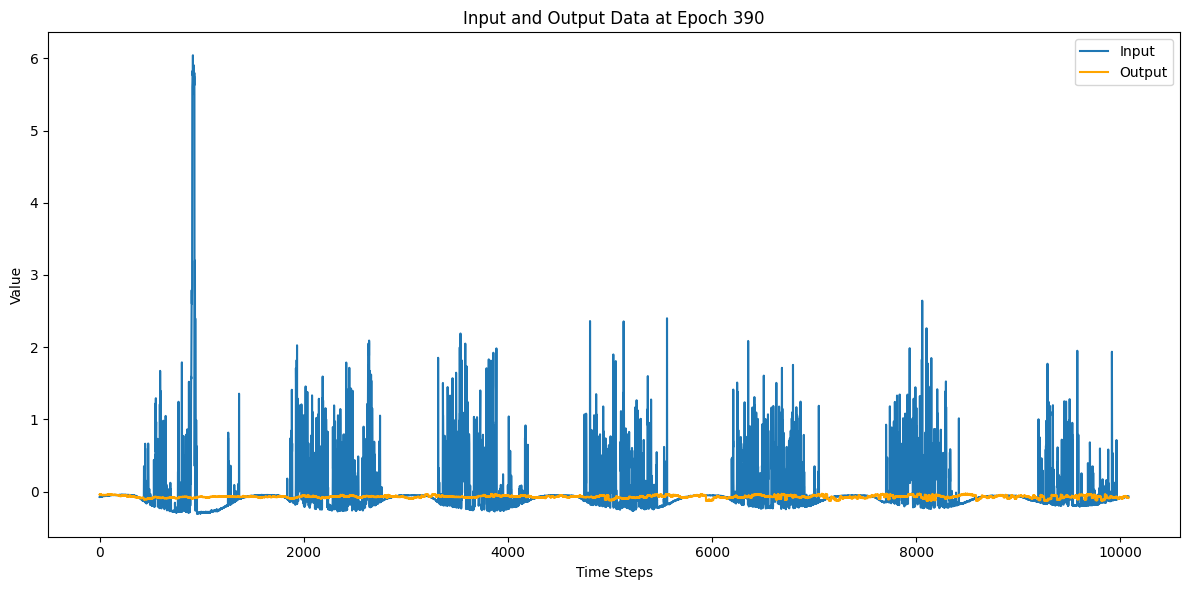

151/151 [==============================] - 8s 55ms/step - loss: 0.3126 - val_loss: 0.2944 - lr: 1.2500e-04
Epoch 391/10000
151/151 [==============================] - 7s 48ms/step - loss: 2.0369 - val_loss: 0.3115 - lr: 1.2500e-04
Epoch 392/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.3551 - val_loss: 0.2879 - lr: 1.2500e-04
Epoch 393/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7212 - val_loss: 0.2972 - lr: 1.2500e-04
Epoch 394/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5623 - val_loss: 0.3016 - lr: 1.2500e-04
Epoch 395/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3548 - val_loss: 0.2913 - lr: 1.2500e-04
Epoch 396/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4935 - val_loss: 0.2866 - lr: 1.2500e-04
Epoch 397/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5826 - val_loss: 0.2996 - lr: 1.2500e-04
Epoch 398/10000
151/151 [=======

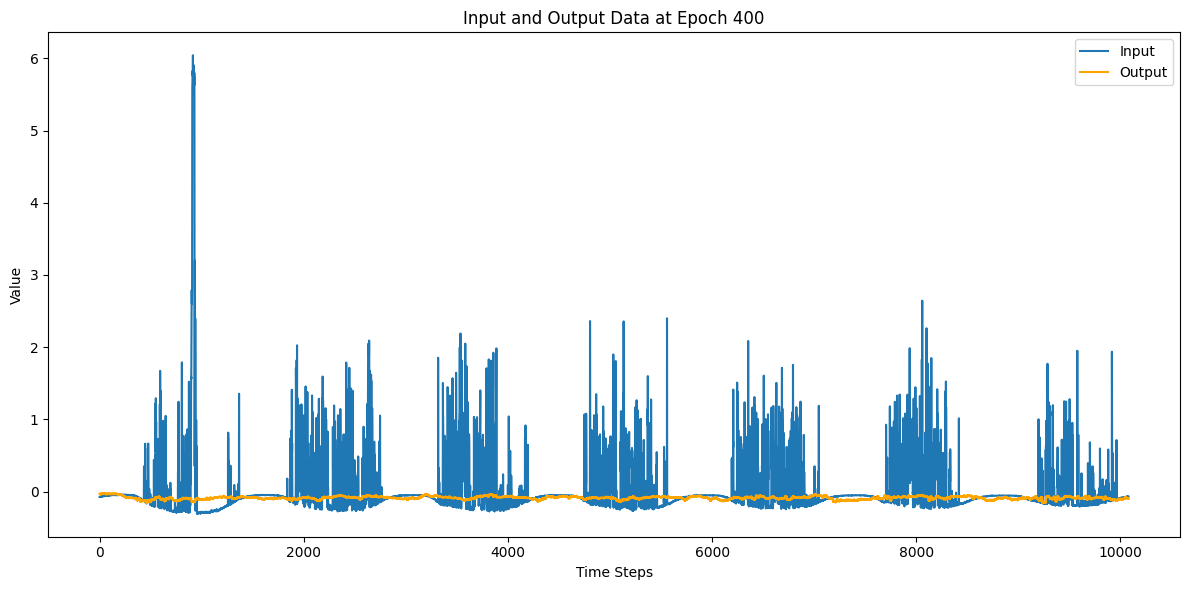

151/151 [==============================] - 9s 59ms/step - loss: 0.7454 - val_loss: 0.2941 - lr: 1.2500e-04
Epoch 401/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9289 - val_loss: 0.2919 - lr: 1.2500e-04
Epoch 402/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4314 - val_loss: 0.3078 - lr: 1.2500e-04
Epoch 403/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.5036 - val_loss: 0.2889 - lr: 1.2500e-04
Epoch 404/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.9165 - val_loss: 0.2921 - lr: 1.2500e-04
Epoch 405/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5271 - val_loss: 0.2837 - lr: 1.2500e-04
Epoch 406/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1798 - val_loss: 0.3119 - lr: 1.2500e-04
Epoch 407/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4895 - val_loss: 0.3013 - lr: 1.2500e-04
Epoch 408/10000
151/151 [=======

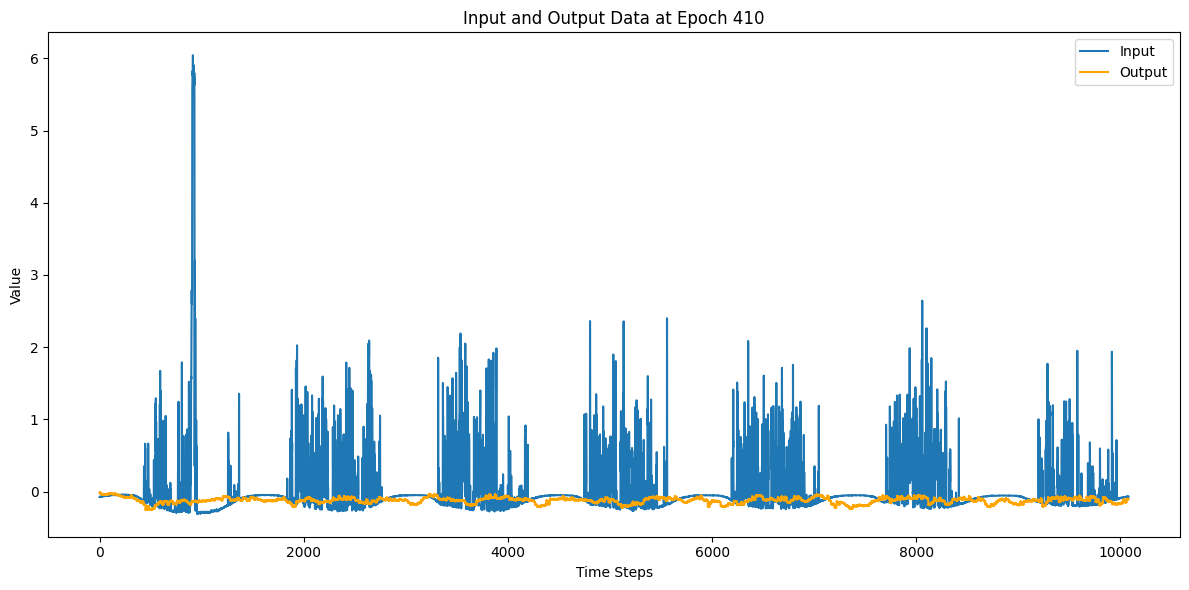

151/151 [==============================] - 8s 55ms/step - loss: 0.7834 - val_loss: 0.2983 - lr: 1.2500e-04
Epoch 411/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.3013 - val_loss: 0.2891 - lr: 1.2500e-04
Epoch 412/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8555 - val_loss: 0.3299 - lr: 1.2500e-04
Epoch 413/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3435 - val_loss: 0.2787 - lr: 1.2500e-04
Epoch 414/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4091 - val_loss: 0.3090 - lr: 1.2500e-04
Epoch 415/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.5315 - val_loss: 0.2878 - lr: 1.2500e-04
Epoch 416/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5063 - val_loss: 0.2835 - lr: 1.2500e-04
Epoch 417/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.5887 - val_loss: 0.3103 - lr: 1.2500e-04
Epoch 418/10000
151/151 [=======

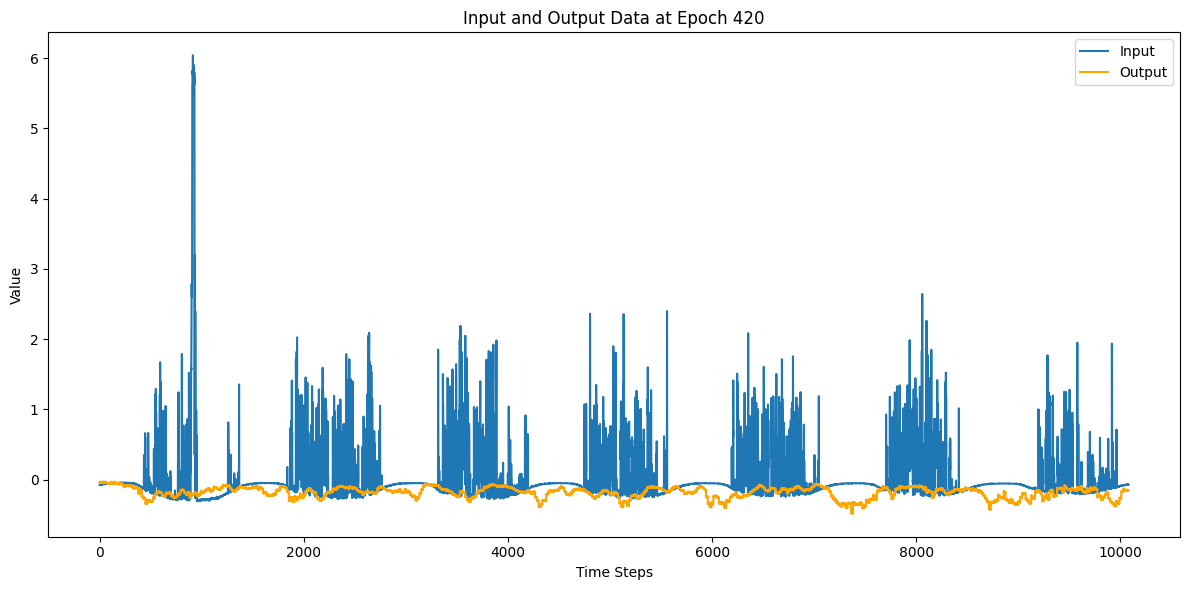

151/151 [==============================] - 8s 56ms/step - loss: 0.3647 - val_loss: 0.2983 - lr: 1.2500e-04
Epoch 421/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5396 - val_loss: 0.2963 - lr: 1.2500e-04
Epoch 422/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6713 - val_loss: 0.2861 - lr: 1.2500e-04
Epoch 423/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.7135 - val_loss: 0.3013 - lr: 1.2500e-04
Epoch 424/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5516 - val_loss: 0.2796 - lr: 1.2500e-04
Epoch 425/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6377 - val_loss: 0.2845 - lr: 1.2500e-04
Epoch 426/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3065 - val_loss: 0.3152 - lr: 1.2500e-04
Epoch 427/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6353 - val_loss: 0.3113 - lr: 1.2500e-04
Epoch 428/10000
151/151 [=======

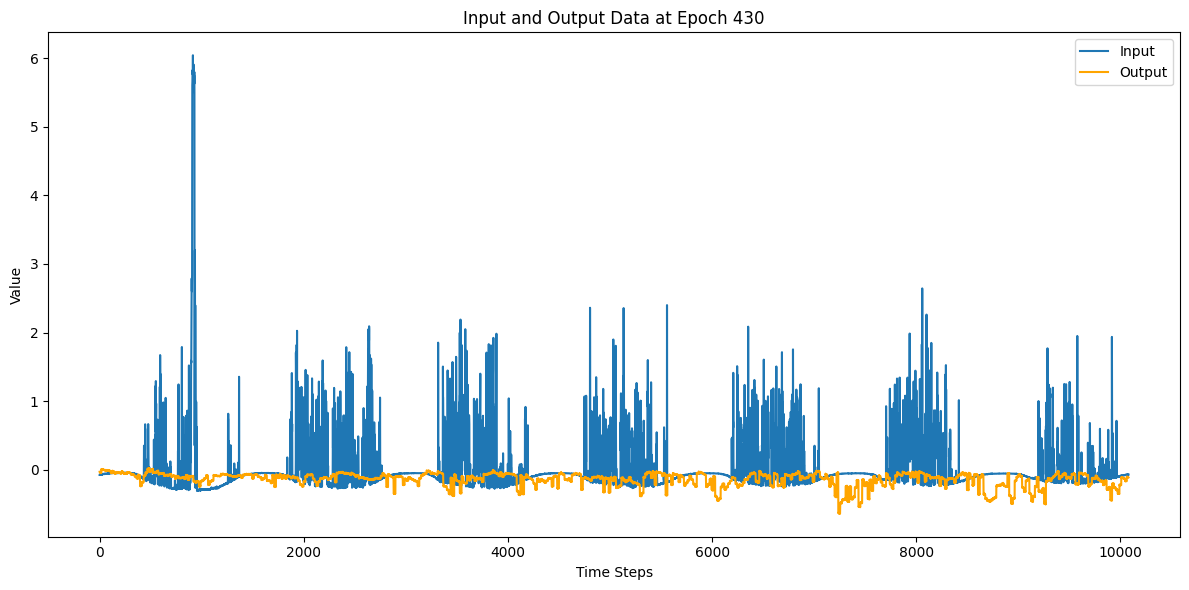

151/151 [==============================] - 9s 59ms/step - loss: 1.1881 - val_loss: 0.3191 - lr: 1.2500e-04
Epoch 431/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7160 - val_loss: 0.3027 - lr: 1.2500e-04
Epoch 432/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.4396 - val_loss: 0.2904 - lr: 1.2500e-04
Epoch 433/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3092 - val_loss: 0.2944 - lr: 1.2500e-04
Epoch 434/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2907 - val_loss: 0.2979 - lr: 1.2500e-04
Epoch 435/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0411 - val_loss: 0.2849 - lr: 1.2500e-04
Epoch 436/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4207 - val_loss: 0.2895 - lr: 1.2500e-04
Epoch 437/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8917 - val_loss: 0.2866 - lr: 1.2500e-04
Epoch 438/10000
151/151 [=======

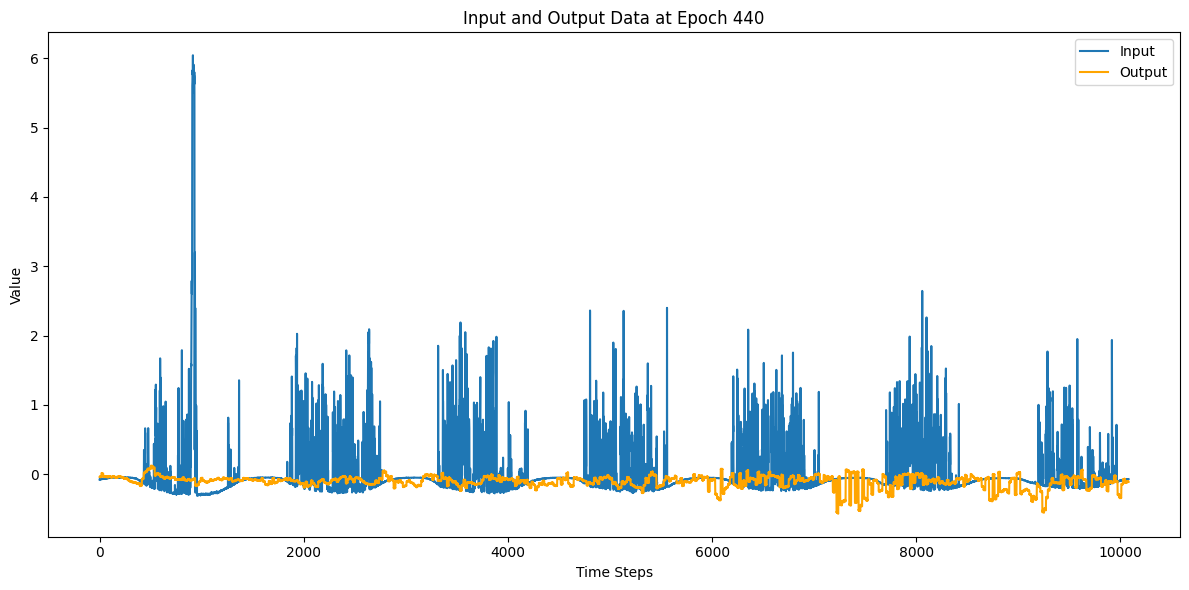

151/151 [==============================] - 8s 56ms/step - loss: 0.2982 - val_loss: 0.2878 - lr: 1.2500e-04
Epoch 441/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6860 - val_loss: 0.3211 - lr: 1.2500e-04
Epoch 442/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6416 - val_loss: 0.3053 - lr: 1.2500e-04
Epoch 443/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3848 - val_loss: 0.2825 - lr: 1.2500e-04
Epoch 444/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4131 - val_loss: 0.3049 - lr: 1.2500e-04
Epoch 445/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4425 - val_loss: 0.3012 - lr: 1.2500e-04
Epoch 446/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7224 - val_loss: 0.2864 - lr: 1.2500e-04
Epoch 447/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2184 - val_loss: 0.2977 - lr: 1.2500e-04
Epoch 448/10000
151/151 [=======

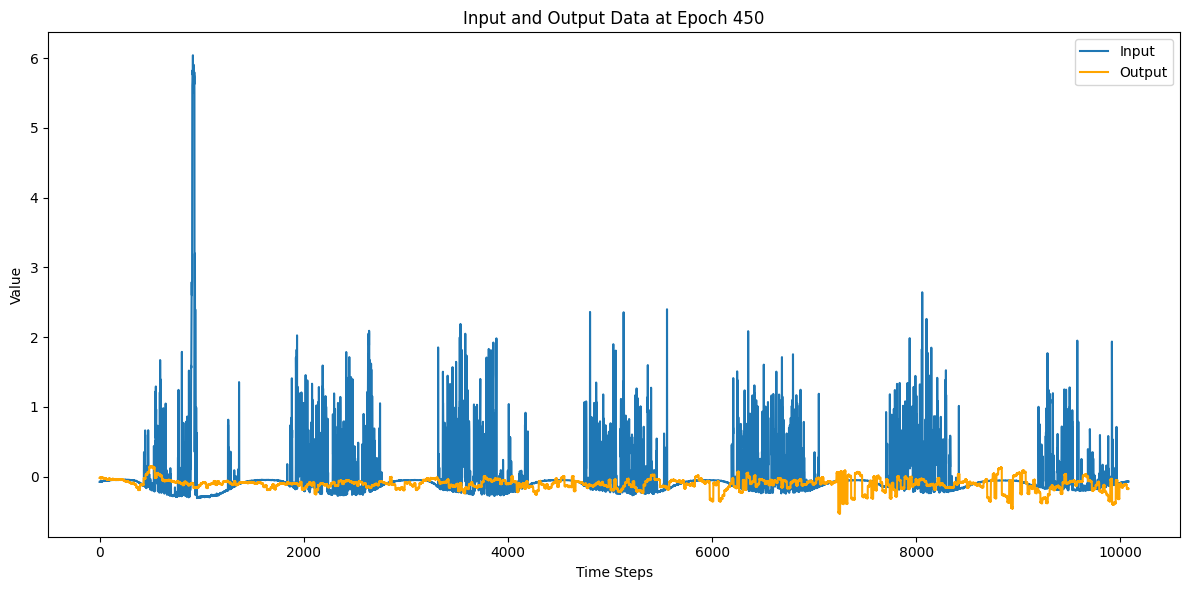

151/151 [==============================] - 8s 56ms/step - loss: 0.5353 - val_loss: 0.2851 - lr: 1.2500e-04
Epoch 451/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8858 - val_loss: 0.2976 - lr: 1.2500e-04
Epoch 452/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.3272 - val_loss: 0.2774 - lr: 1.2500e-04
Epoch 453/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3329 - val_loss: 0.2805 - lr: 1.2500e-04
Epoch 454/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3203 - val_loss: 0.3057 - lr: 1.2500e-04
Epoch 455/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.0794 - val_loss: 0.2890 - lr: 1.2500e-04
Epoch 456/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3416 - val_loss: 0.2847 - lr: 1.2500e-04
Epoch 457/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5283 - val_loss: 0.3131 - lr: 1.2500e-04
Epoch 458/10000
151/151 [=======

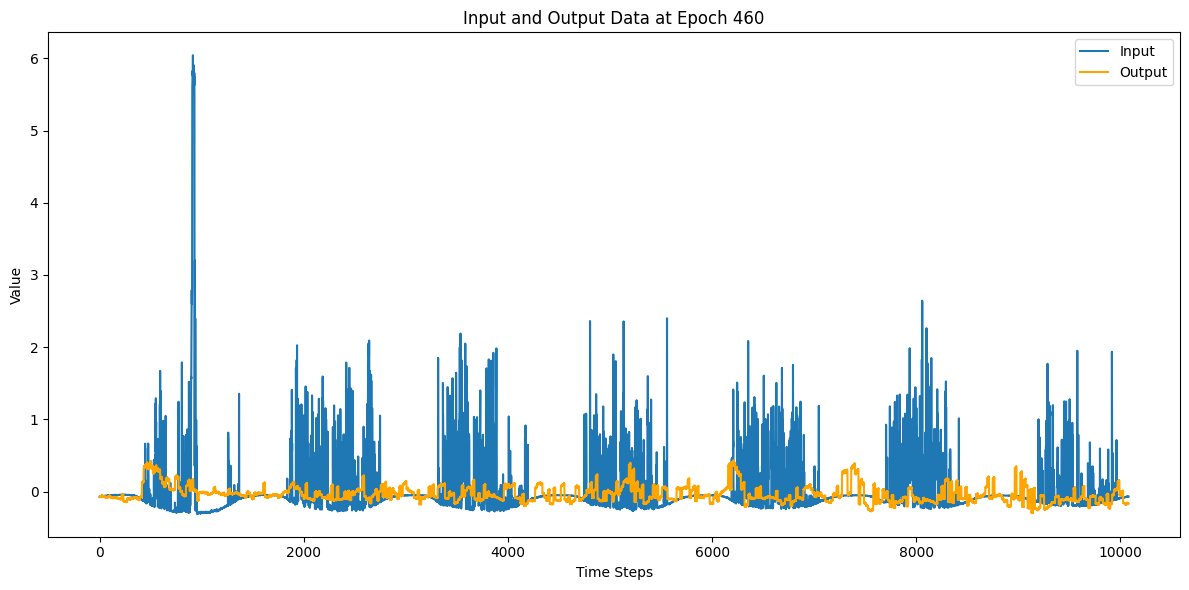

151/151 [==============================] - 8s 56ms/step - loss: 0.2769 - val_loss: 0.2950 - lr: 1.2500e-04
Epoch 461/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9993 - val_loss: 0.2817 - lr: 1.2500e-04
Epoch 462/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6744 - val_loss: 0.2717 - lr: 1.2500e-04
Epoch 463/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6745 - val_loss: 0.2830 - lr: 1.2500e-04
Epoch 464/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0115 - val_loss: 0.3074 - lr: 1.2500e-04
Epoch 465/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6595 - val_loss: 0.3045 - lr: 1.2500e-04
Epoch 466/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4937 - val_loss: 0.2709 - lr: 1.2500e-04
Epoch 467/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5081 - val_loss: 0.2983 - lr: 1.2500e-04
Epoch 468/10000
151/151 [=======

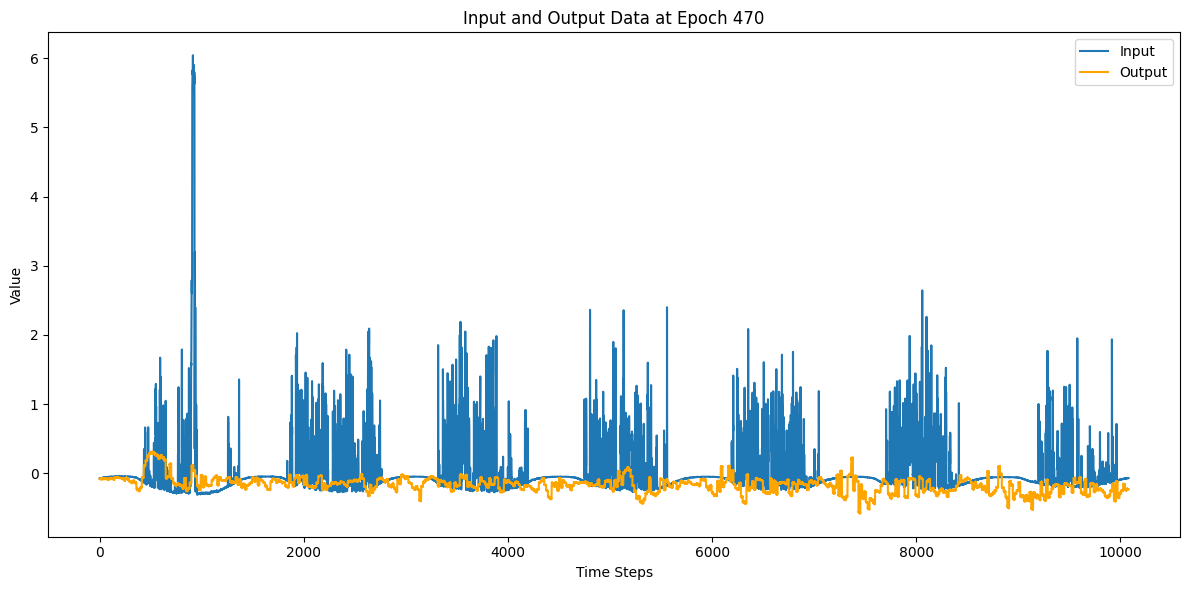

151/151 [==============================] - 8s 54ms/step - loss: 0.3184 - val_loss: 0.2606 - lr: 1.2500e-04
Epoch 471/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8633 - val_loss: 0.2768 - lr: 1.2500e-04
Epoch 472/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7094 - val_loss: 0.2684 - lr: 1.2500e-04
Epoch 473/10000
150/151 [============================>.] - ETA: 0s - loss: 0.3170
Epoch 473: ReduceLROnPlateau reducing learning rate to 0.0001.
151/151 [==============================] - 7s 49ms/step - loss: 0.3164 - val_loss: 0.2889 - lr: 1.2500e-04
Epoch 474/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3402 - val_loss: 0.2761 - lr: 1.0000e-04
Epoch 475/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.2345 - val_loss: 0.2614 - lr: 1.0000e-04
Epoch 476/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5821 - val_loss: 0.2918 - lr: 1.0000e-04
Epoch 477/10000
151/151 [=

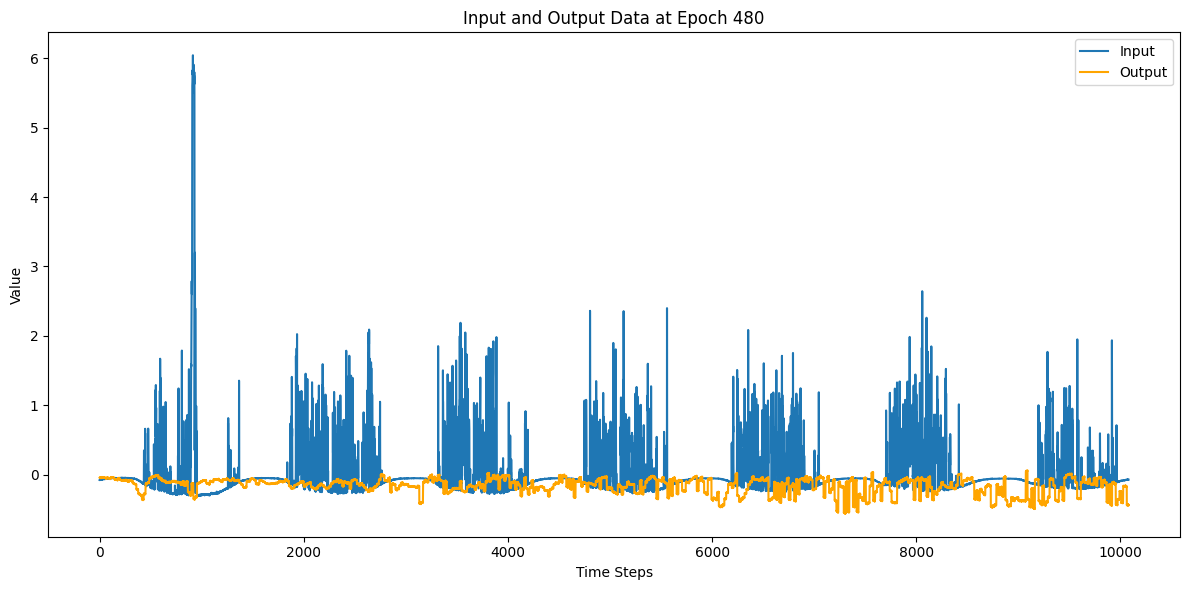

151/151 [==============================] - 8s 56ms/step - loss: 0.6991 - val_loss: 0.2688 - lr: 1.0000e-04
Epoch 481/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2968 - val_loss: 0.2546 - lr: 1.0000e-04
Epoch 482/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.2353 - val_loss: 0.2968 - lr: 1.0000e-04
Epoch 483/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9685 - val_loss: 0.2808 - lr: 1.0000e-04
Epoch 484/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6511 - val_loss: 0.2666 - lr: 1.0000e-04
Epoch 485/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8593 - val_loss: 0.2594 - lr: 1.0000e-04
Epoch 486/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0059 - val_loss: 0.2864 - lr: 1.0000e-04
Epoch 487/10000
151/151 [==============================] - 8s 53ms/step - loss: 1.6406 - val_loss: 0.2703 - lr: 1.0000e-04
Epoch 488/10000
151/151 [=======

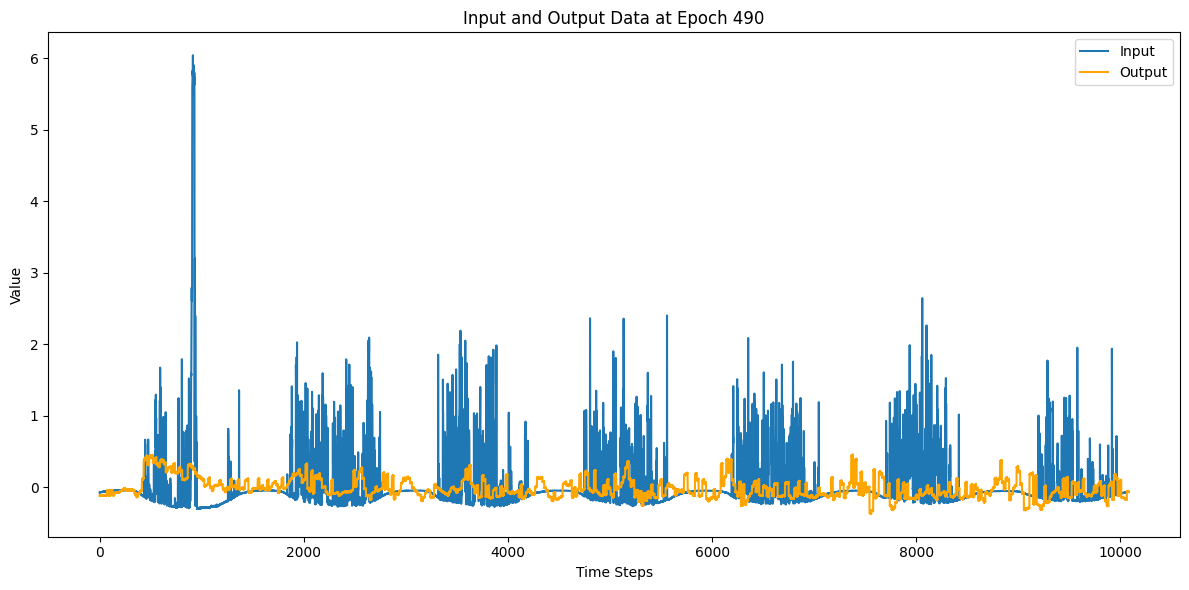

151/151 [==============================] - 8s 55ms/step - loss: 1.0680 - val_loss: 0.2661 - lr: 1.0000e-04
Epoch 491/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3538 - val_loss: 0.2573 - lr: 1.0000e-04
Epoch 492/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4948 - val_loss: 0.2832 - lr: 1.0000e-04
Epoch 493/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8408 - val_loss: 0.2606 - lr: 1.0000e-04
Epoch 494/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6292 - val_loss: 0.2586 - lr: 1.0000e-04
Epoch 495/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.0774 - val_loss: 0.2666 - lr: 1.0000e-04
Epoch 496/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1544 - val_loss: 0.2683 - lr: 1.0000e-04
Epoch 497/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8688 - val_loss: 0.2554 - lr: 1.0000e-04
Epoch 498/10000
151/151 [=======

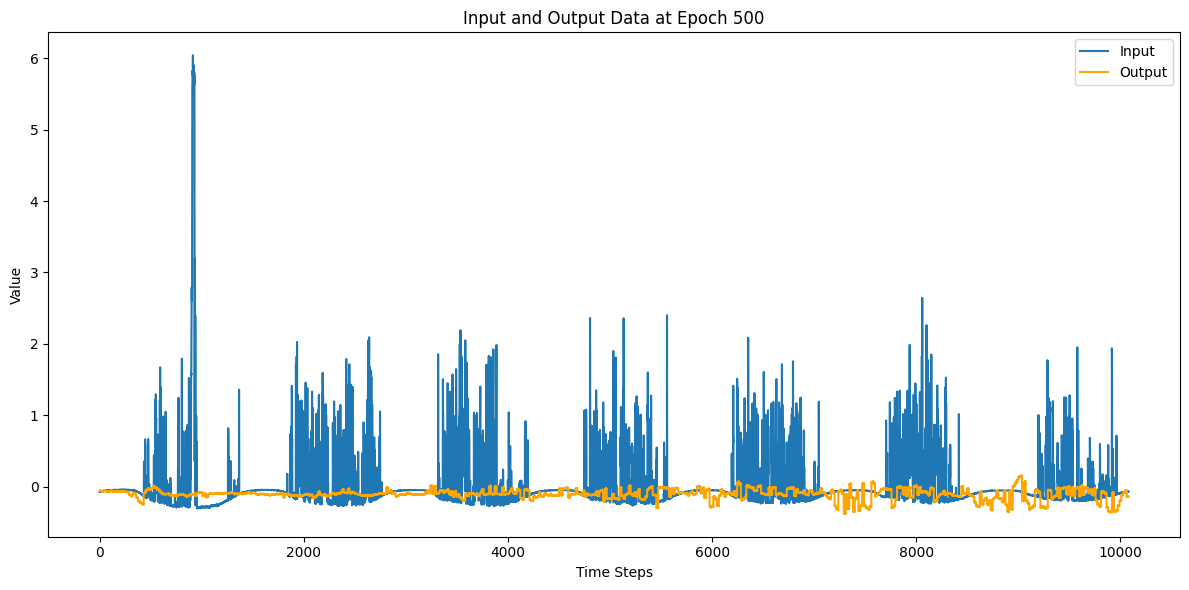

151/151 [==============================] - 8s 56ms/step - loss: 0.8668 - val_loss: 0.2805 - lr: 1.0000e-04
Epoch 501/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3158 - val_loss: 0.2694 - lr: 1.0000e-04
Epoch 502/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1819 - val_loss: 0.2513 - lr: 1.0000e-04
Epoch 503/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3533 - val_loss: 0.2720 - lr: 1.0000e-04
Epoch 504/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.4680 - val_loss: 0.2884 - lr: 1.0000e-04
Epoch 505/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.6218 - val_loss: 0.2779 - lr: 1.0000e-04
Epoch 506/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6807 - val_loss: 0.2543 - lr: 1.0000e-04
Epoch 507/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4525 - val_loss: 0.2658 - lr: 1.0000e-04
Epoch 508/10000
151/151 [=======

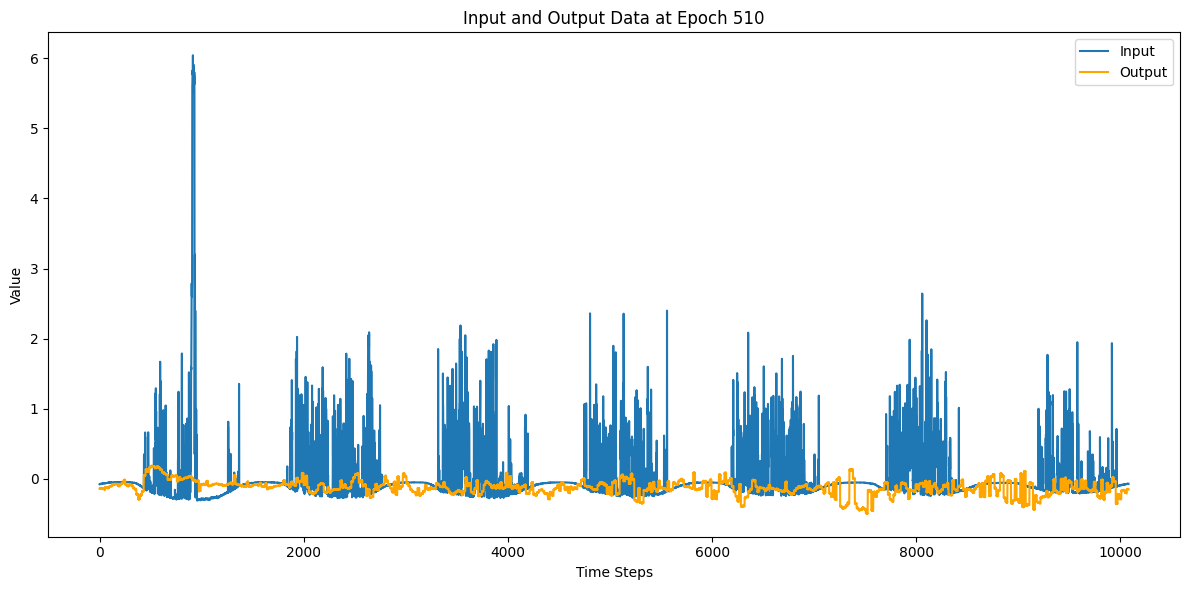

151/151 [==============================] - 8s 56ms/step - loss: 0.5186 - val_loss: 0.2523 - lr: 1.0000e-04
Epoch 511/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9511 - val_loss: 0.2843 - lr: 1.0000e-04
Epoch 512/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9553 - val_loss: 0.2788 - lr: 1.0000e-04
Epoch 513/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2902 - val_loss: 0.2634 - lr: 1.0000e-04
Epoch 514/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.2948 - val_loss: 0.2622 - lr: 1.0000e-04
Epoch 515/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5612 - val_loss: 0.2735 - lr: 1.0000e-04
Epoch 516/10000
151/151 [==============================] - 8s 54ms/step - loss: 0.7496 - val_loss: 0.2371 - lr: 1.0000e-04
Epoch 517/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.5022 - val_loss: 0.2619 - lr: 1.0000e-04
Epoch 518/10000
151/151 [=======

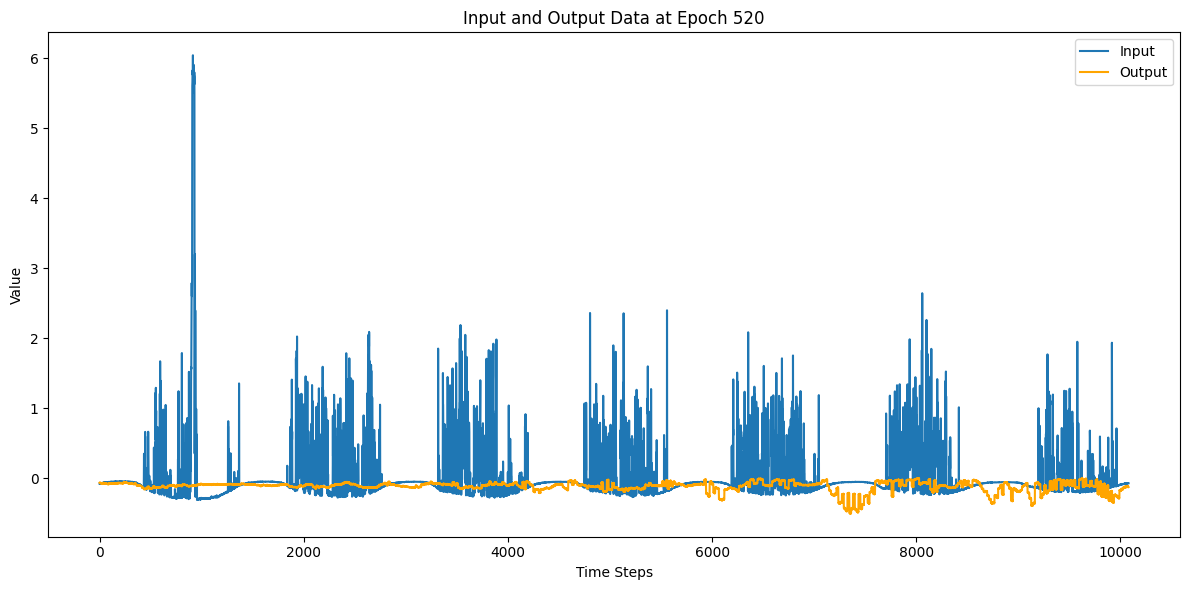

151/151 [==============================] - 8s 56ms/step - loss: 0.6396 - val_loss: 0.2721 - lr: 1.0000e-04
Epoch 521/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4954 - val_loss: 0.2788 - lr: 1.0000e-04
Epoch 522/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8103 - val_loss: 0.2903 - lr: 1.0000e-04
Epoch 523/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7039 - val_loss: 0.2810 - lr: 1.0000e-04
Epoch 524/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2615 - val_loss: 0.2823 - lr: 1.0000e-04
Epoch 525/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1804 - val_loss: 0.2821 - lr: 1.0000e-04
Epoch 526/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3061 - val_loss: 0.2613 - lr: 1.0000e-04
Epoch 527/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7405 - val_loss: 0.2651 - lr: 1.0000e-04
Epoch 528/10000
151/151 [=======

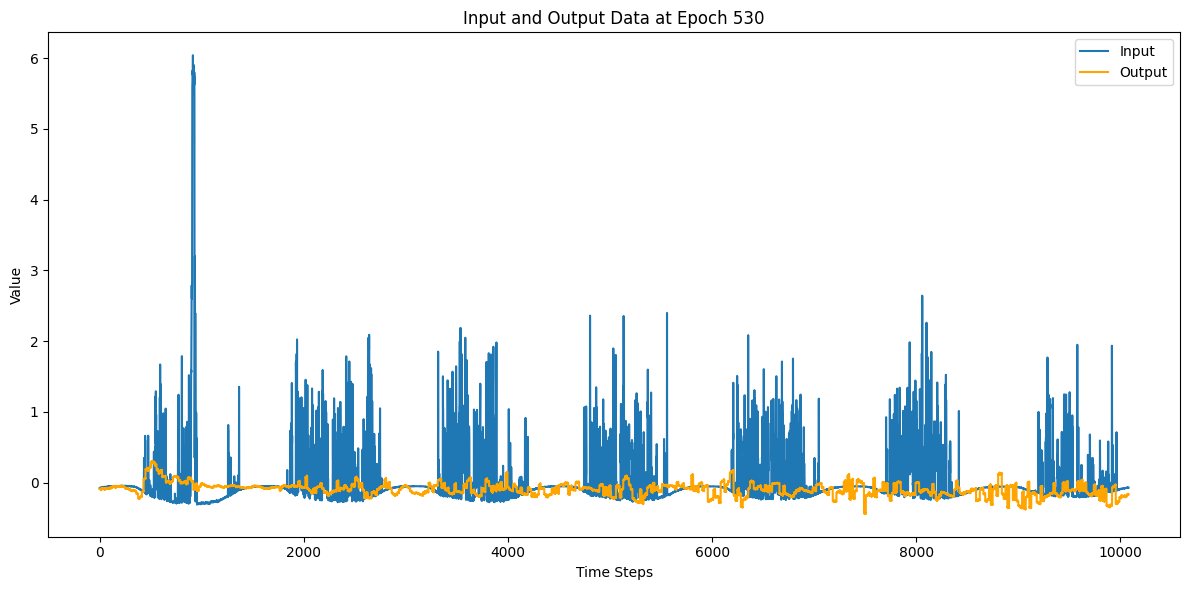

151/151 [==============================] - 8s 56ms/step - loss: 0.2870 - val_loss: 0.2425 - lr: 1.0000e-04
Epoch 531/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3537 - val_loss: 0.2521 - lr: 1.0000e-04
Epoch 532/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6698 - val_loss: 0.2531 - lr: 1.0000e-04
Epoch 533/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1811 - val_loss: 0.2648 - lr: 1.0000e-04
Epoch 534/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4377 - val_loss: 0.2586 - lr: 1.0000e-04
Epoch 535/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.9340 - val_loss: 0.2784 - lr: 1.0000e-04
Epoch 536/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2858 - val_loss: 0.2557 - lr: 1.0000e-04
Epoch 537/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3043 - val_loss: 0.2462 - lr: 1.0000e-04
Epoch 538/10000
151/151 [=======

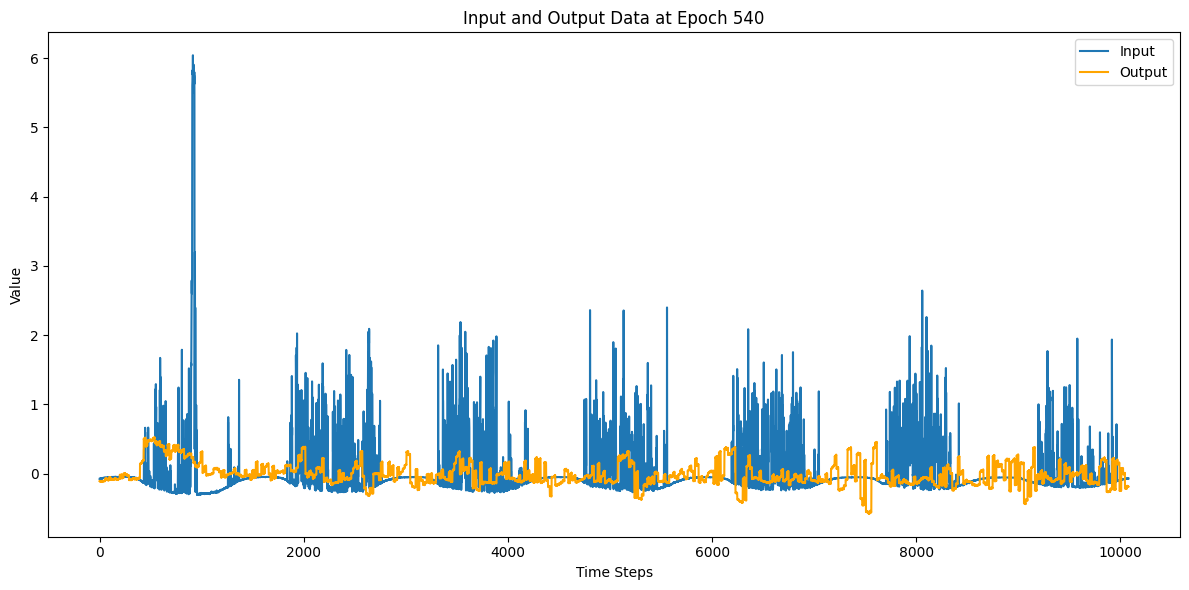

151/151 [==============================] - 8s 55ms/step - loss: 0.9246 - val_loss: 0.2725 - lr: 1.0000e-04
Epoch 541/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3406 - val_loss: 0.2705 - lr: 1.0000e-04
Epoch 542/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5522 - val_loss: 0.2695 - lr: 1.0000e-04
Epoch 543/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8573 - val_loss: 0.2678 - lr: 1.0000e-04
Epoch 544/10000
151/151 [==============================] - 8s 55ms/step - loss: 0.4659 - val_loss: 0.2696 - lr: 1.0000e-04
Epoch 545/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7332 - val_loss: 0.2731 - lr: 1.0000e-04
Epoch 546/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8905 - val_loss: 0.2414 - lr: 1.0000e-04
Epoch 547/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7016 - val_loss: 0.2378 - lr: 1.0000e-04
Epoch 548/10000
151/151 [=======

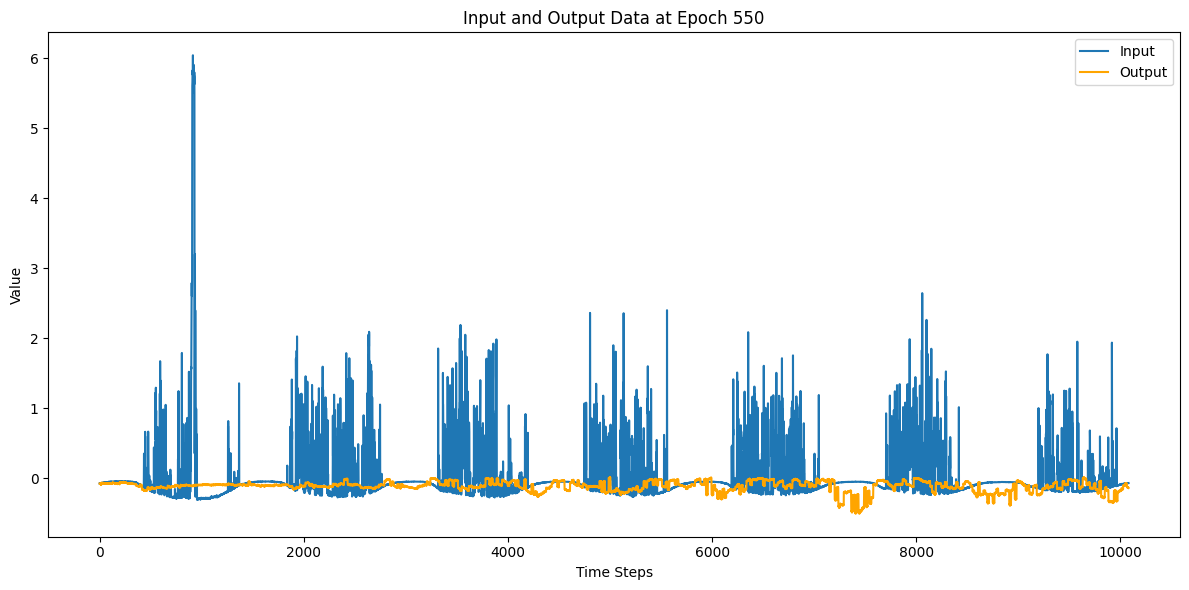

151/151 [==============================] - 8s 55ms/step - loss: 0.9942 - val_loss: 0.2517 - lr: 1.0000e-04
Epoch 551/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2217 - val_loss: 0.2470 - lr: 1.0000e-04
Epoch 552/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6772 - val_loss: 0.2548 - lr: 1.0000e-04
Epoch 553/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.5922 - val_loss: 0.2423 - lr: 1.0000e-04
Epoch 554/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.7617 - val_loss: 0.2553 - lr: 1.0000e-04
Epoch 555/10000
151/151 [==============================] - 8s 51ms/step - loss: 0.6401 - val_loss: 0.2666 - lr: 1.0000e-04
Epoch 556/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3325 - val_loss: 0.2634 - lr: 1.0000e-04
Epoch 557/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4741 - val_loss: 0.2537 - lr: 1.0000e-04
Epoch 558/10000
151/151 [=======

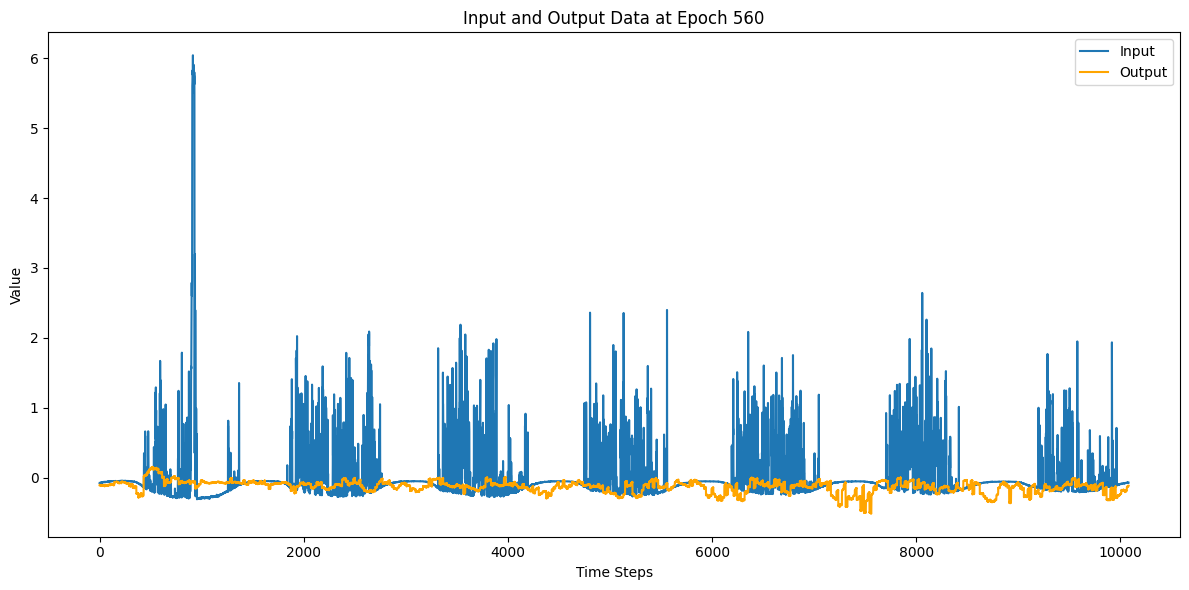

151/151 [==============================] - 8s 55ms/step - loss: 0.4409 - val_loss: 0.2422 - lr: 1.0000e-04
Epoch 561/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7075 - val_loss: 0.2467 - lr: 1.0000e-04
Epoch 562/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0755 - val_loss: 0.2638 - lr: 1.0000e-04
Epoch 563/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8536 - val_loss: 0.2449 - lr: 1.0000e-04
Epoch 564/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4208 - val_loss: 0.2541 - lr: 1.0000e-04
Epoch 565/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2946 - val_loss: 0.2508 - lr: 1.0000e-04
Epoch 566/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3944 - val_loss: 0.2487 - lr: 1.0000e-04
Epoch 567/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.6610 - val_loss: 0.2538 - lr: 1.0000e-04
Epoch 568/10000
151/151 [=======

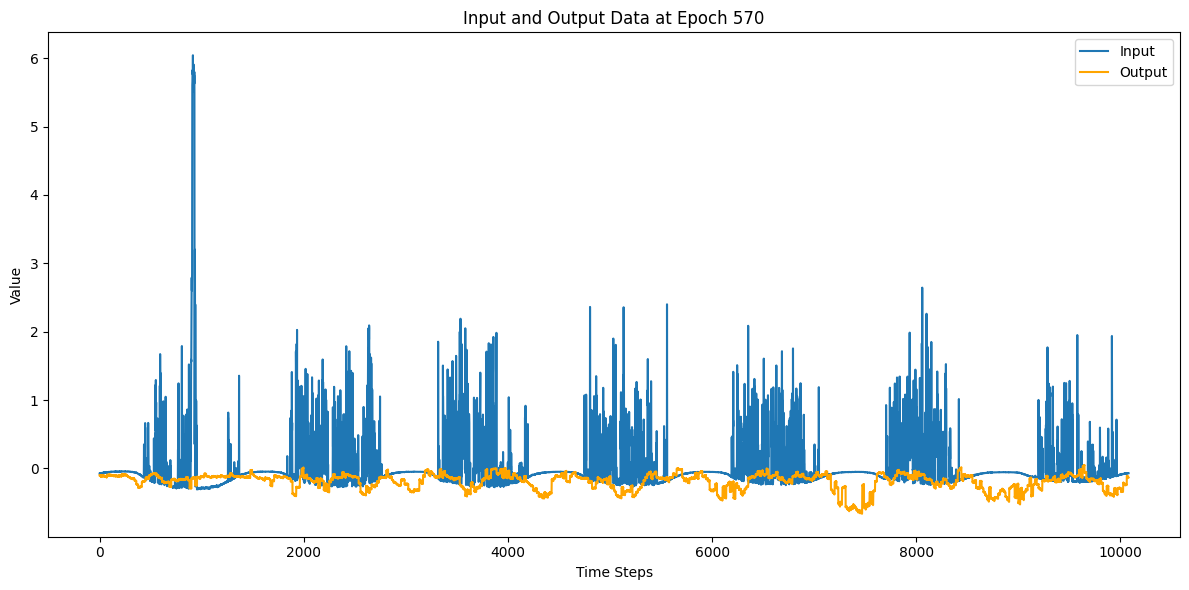

151/151 [==============================] - 8s 56ms/step - loss: 0.2772 - val_loss: 0.2508 - lr: 1.0000e-04
Epoch 571/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3942 - val_loss: 0.2417 - lr: 1.0000e-04
Epoch 572/10000
151/151 [==============================] - 8s 53ms/step - loss: 1.3846 - val_loss: 0.2494 - lr: 1.0000e-04
Epoch 573/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0022 - val_loss: 0.2594 - lr: 1.0000e-04
Epoch 574/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1977 - val_loss: 0.2478 - lr: 1.0000e-04
Epoch 575/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.1926 - val_loss: 0.2613 - lr: 1.0000e-04
Epoch 576/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6339 - val_loss: 0.2767 - lr: 1.0000e-04
Epoch 577/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4795 - val_loss: 0.2464 - lr: 1.0000e-04
Epoch 578/10000
151/151 [=======

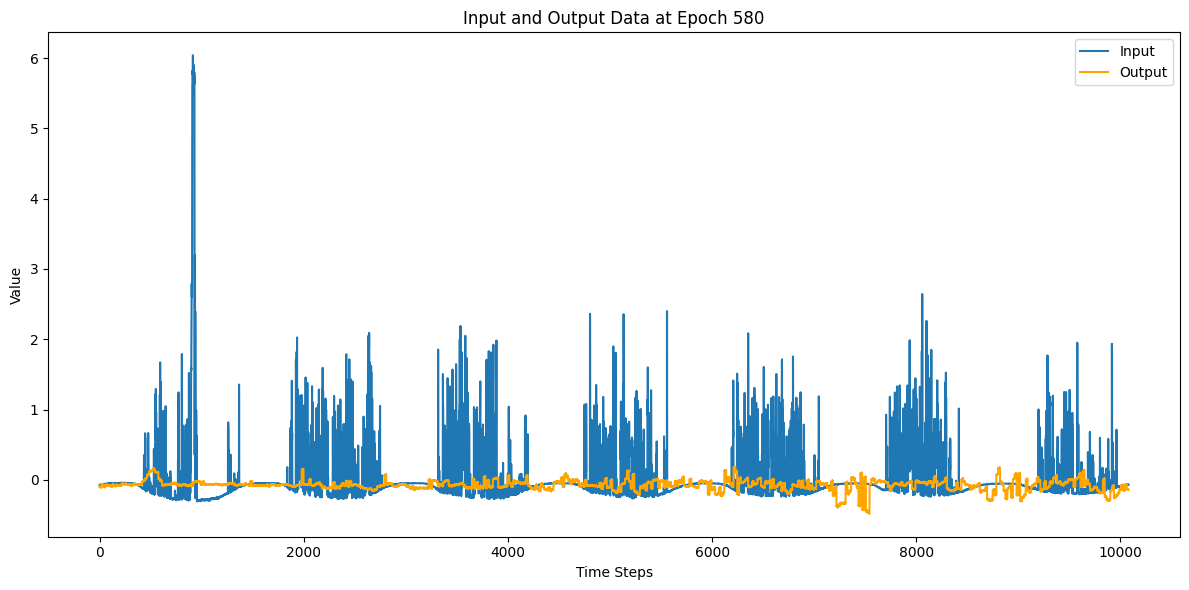

151/151 [==============================] - 8s 56ms/step - loss: 0.2607 - val_loss: 0.2537 - lr: 1.0000e-04
Epoch 581/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2969 - val_loss: 0.2672 - lr: 1.0000e-04
Epoch 582/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8550 - val_loss: 0.2582 - lr: 1.0000e-04
Epoch 583/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1898 - val_loss: 0.2465 - lr: 1.0000e-04
Epoch 584/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.2828 - val_loss: 0.2600 - lr: 1.0000e-04
Epoch 585/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4553 - val_loss: 0.2566 - lr: 1.0000e-04
Epoch 586/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4993 - val_loss: 0.2616 - lr: 1.0000e-04
Epoch 587/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4827 - val_loss: 0.2587 - lr: 1.0000e-04
Epoch 588/10000
151/151 [=======

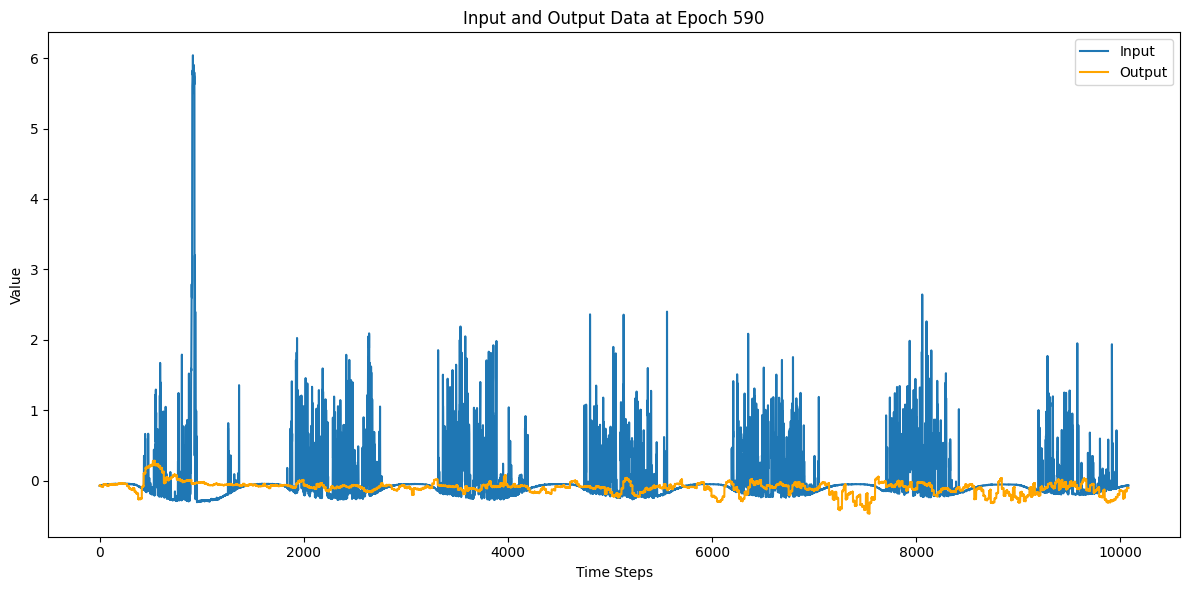

151/151 [==============================] - 8s 56ms/step - loss: 0.5025 - val_loss: 0.2705 - lr: 1.0000e-04
Epoch 591/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.7923 - val_loss: 0.2220 - lr: 1.0000e-04
Epoch 592/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.2805 - val_loss: 0.2587 - lr: 1.0000e-04
Epoch 593/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7283 - val_loss: 0.2684 - lr: 1.0000e-04
Epoch 594/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4472 - val_loss: 0.2766 - lr: 1.0000e-04
Epoch 595/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0391 - val_loss: 0.2485 - lr: 1.0000e-04
Epoch 596/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.9506 - val_loss: 0.2465 - lr: 1.0000e-04
Epoch 597/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.7371 - val_loss: 0.2542 - lr: 1.0000e-04
Epoch 598/10000
151/151 [=======

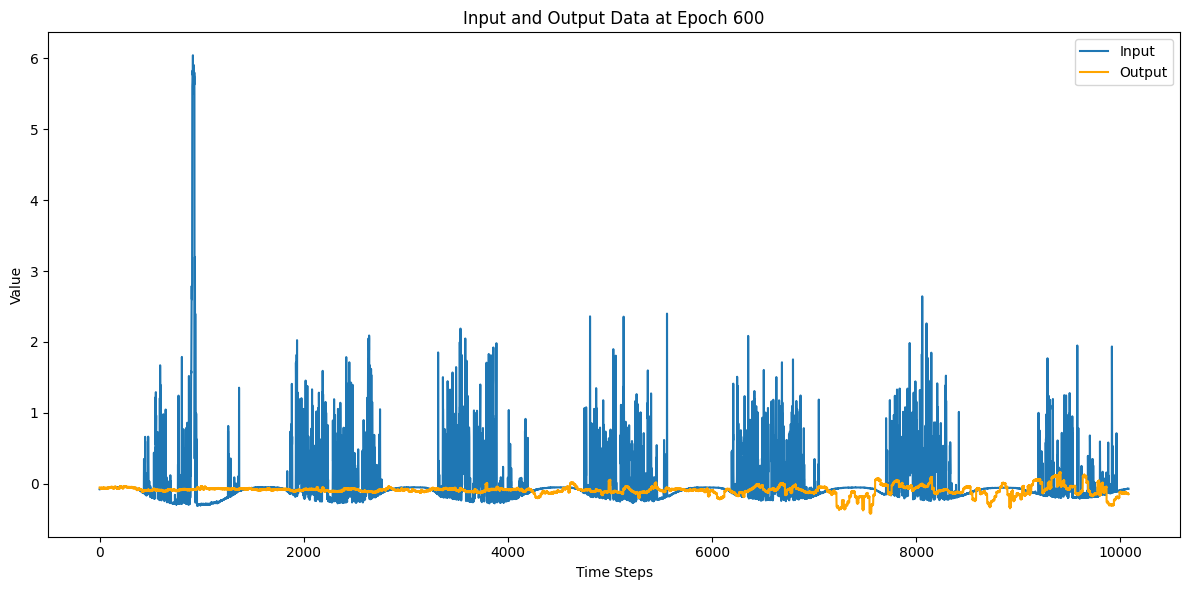

151/151 [==============================] - 8s 55ms/step - loss: 0.9924 - val_loss: 0.2405 - lr: 1.0000e-04
Epoch 601/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.1169 - val_loss: 0.2577 - lr: 1.0000e-04
Epoch 602/10000
151/151 [==============================] - 8s 52ms/step - loss: 0.8753 - val_loss: 0.2588 - lr: 1.0000e-04
Epoch 603/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.9056 - val_loss: 0.2402 - lr: 1.0000e-04
Epoch 604/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2138 - val_loss: 0.2378 - lr: 1.0000e-04
Epoch 605/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4034 - val_loss: 0.2490 - lr: 1.0000e-04
Epoch 606/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.0894 - val_loss: 0.2591 - lr: 1.0000e-04
Epoch 607/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1332 - val_loss: 0.2562 - lr: 1.0000e-04
Epoch 608/10000
151/151 [=======

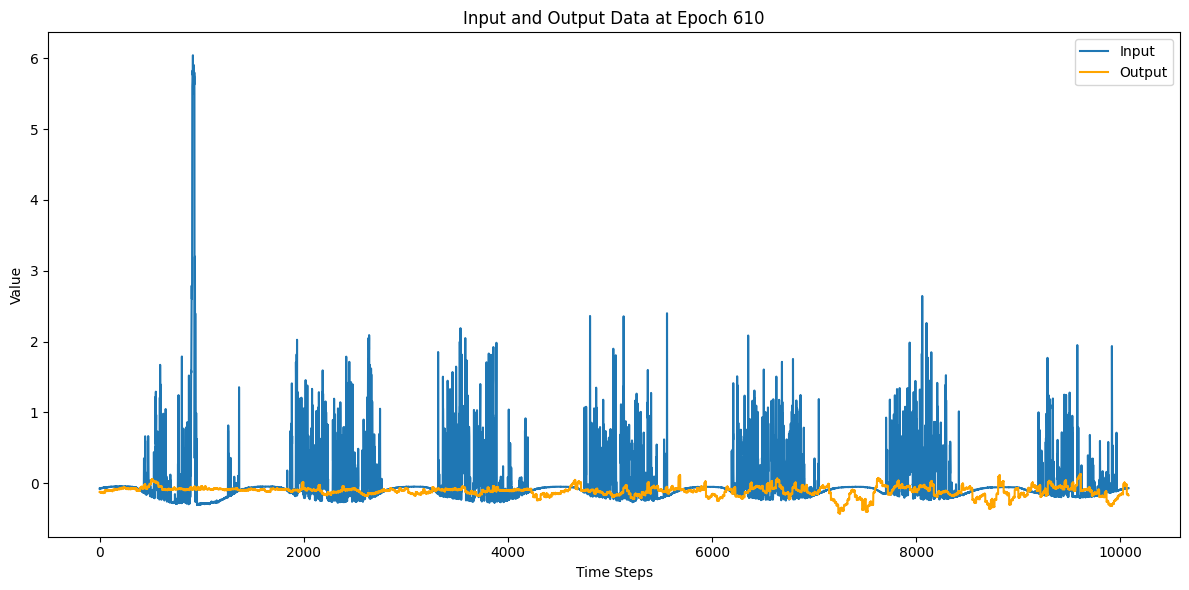

151/151 [==============================] - 8s 56ms/step - loss: 0.4785 - val_loss: 0.2463 - lr: 1.0000e-04
Epoch 611/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0995 - val_loss: 0.2557 - lr: 1.0000e-04
Epoch 612/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4828 - val_loss: 0.2763 - lr: 1.0000e-04
Epoch 613/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1660 - val_loss: 0.2293 - lr: 1.0000e-04
Epoch 614/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4799 - val_loss: 0.2822 - lr: 1.0000e-04
Epoch 615/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6565 - val_loss: 0.2854 - lr: 1.0000e-04
Epoch 616/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2804 - val_loss: 0.2495 - lr: 1.0000e-04
Epoch 617/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5637 - val_loss: 0.2488 - lr: 1.0000e-04
Epoch 618/10000
151/151 [=======

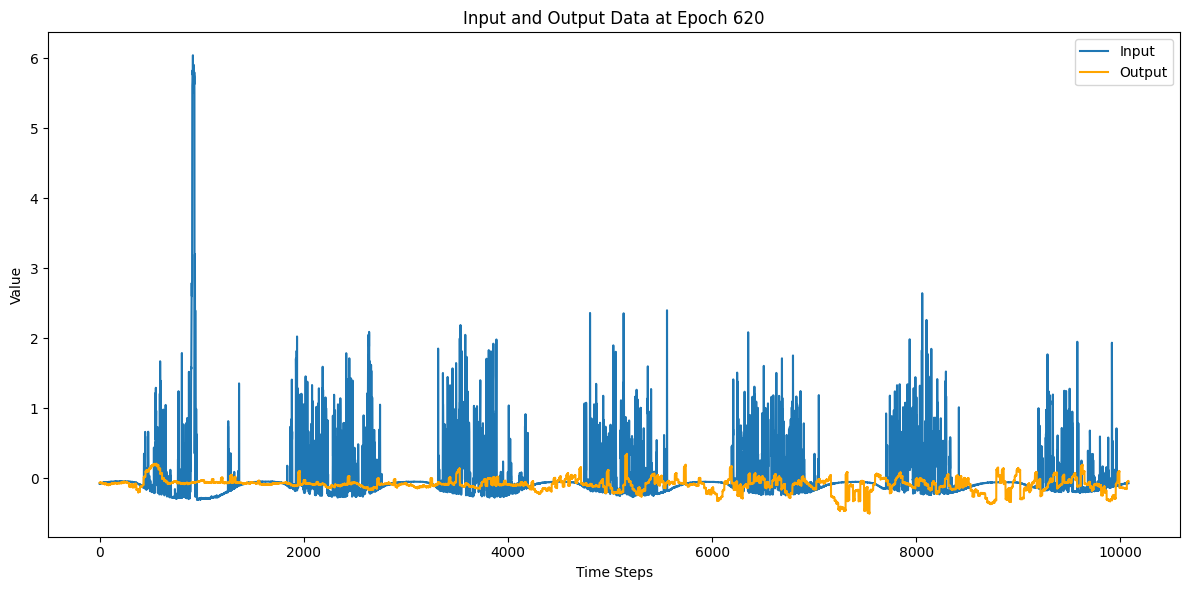

151/151 [==============================] - 8s 55ms/step - loss: 0.6677 - val_loss: 0.2639 - lr: 1.0000e-04
Epoch 621/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4575 - val_loss: 0.2676 - lr: 1.0000e-04
Epoch 622/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3514 - val_loss: 0.2470 - lr: 1.0000e-04
Epoch 623/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3787 - val_loss: 0.2521 - lr: 1.0000e-04
Epoch 624/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1587 - val_loss: 0.2521 - lr: 1.0000e-04
Epoch 625/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4957 - val_loss: 0.2720 - lr: 1.0000e-04
Epoch 626/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8049 - val_loss: 0.2436 - lr: 1.0000e-04
Epoch 627/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8660 - val_loss: 0.2466 - lr: 1.0000e-04
Epoch 628/10000
151/151 [=======

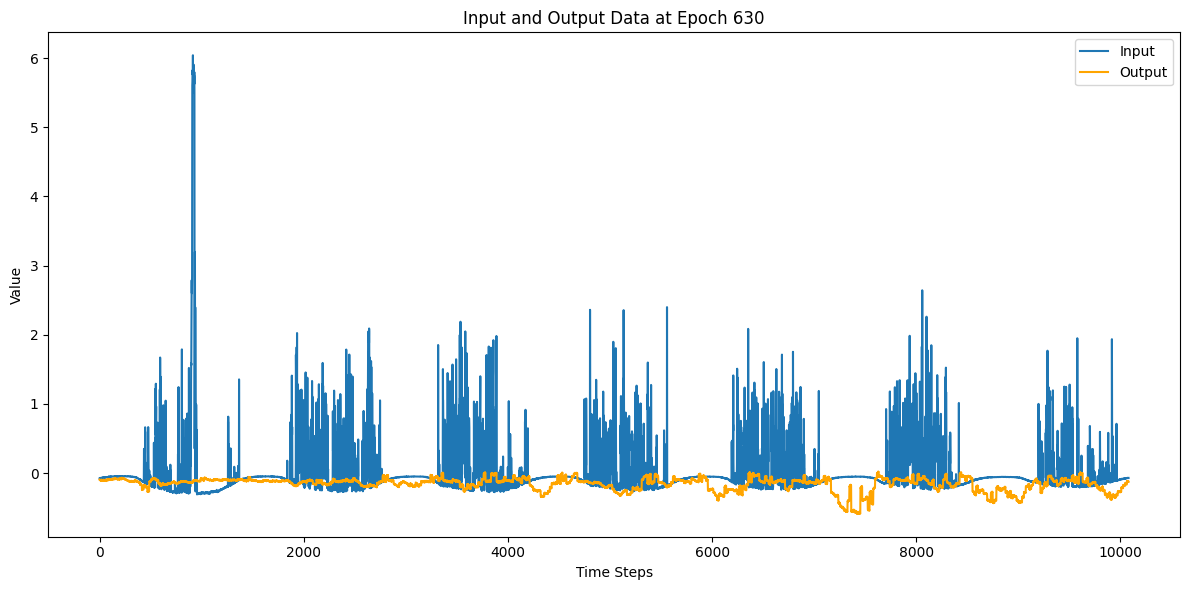

151/151 [==============================] - 9s 60ms/step - loss: 0.8590 - val_loss: 0.2670 - lr: 1.0000e-04
Epoch 631/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5006 - val_loss: 0.2498 - lr: 1.0000e-04
Epoch 632/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.6535 - val_loss: 0.2594 - lr: 1.0000e-04
Epoch 633/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.8168 - val_loss: 0.2376 - lr: 1.0000e-04
Epoch 634/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.3252 - val_loss: 0.2725 - lr: 1.0000e-04
Epoch 635/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9035 - val_loss: 0.2374 - lr: 1.0000e-04
Epoch 636/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.6754 - val_loss: 0.2429 - lr: 1.0000e-04
Epoch 637/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4895 - val_loss: 0.2481 - lr: 1.0000e-04
Epoch 638/10000
151/151 [=======

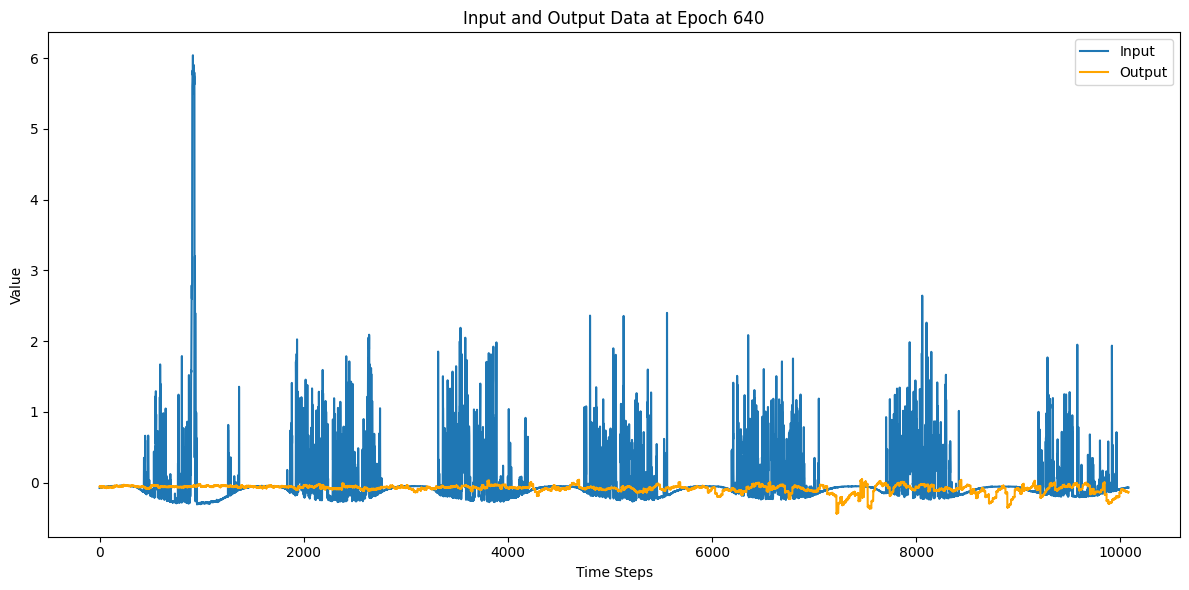

151/151 [==============================] - 8s 56ms/step - loss: 1.3240 - val_loss: 0.2413 - lr: 1.0000e-04
Epoch 641/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5244 - val_loss: 0.2763 - lr: 1.0000e-04
Epoch 642/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8263 - val_loss: 0.2424 - lr: 1.0000e-04
Epoch 643/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.2840 - val_loss: 0.2383 - lr: 1.0000e-04
Epoch 644/10000
151/151 [==============================] - 7s 50ms/step - loss: 1.0272 - val_loss: 0.2626 - lr: 1.0000e-04
Epoch 645/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9113 - val_loss: 0.2719 - lr: 1.0000e-04
Epoch 646/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5364 - val_loss: 0.2347 - lr: 1.0000e-04
Epoch 647/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.6500 - val_loss: 0.2699 - lr: 1.0000e-04
Epoch 648/10000
151/151 [=======

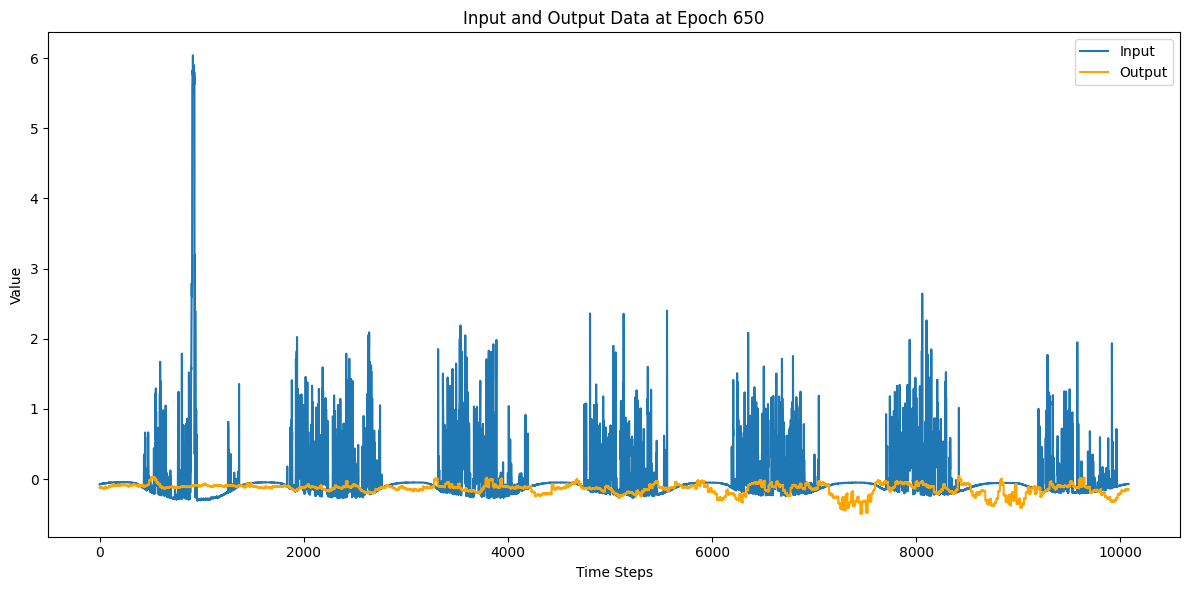

151/151 [==============================] - 8s 55ms/step - loss: 0.6343 - val_loss: 0.2586 - lr: 1.0000e-04
Epoch 651/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5294 - val_loss: 0.2680 - lr: 1.0000e-04
Epoch 652/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1700 - val_loss: 0.2659 - lr: 1.0000e-04
Epoch 653/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.2962 - val_loss: 0.2644 - lr: 1.0000e-04
Epoch 654/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3371 - val_loss: 0.2729 - lr: 1.0000e-04
Epoch 655/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.4116 - val_loss: 0.2693 - lr: 1.0000e-04
Epoch 656/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3548 - val_loss: 0.2562 - lr: 1.0000e-04
Epoch 657/10000
151/151 [==============================] - 8s 52ms/step - loss: 0.2760 - val_loss: 0.2681 - lr: 1.0000e-04
Epoch 658/10000
151/151 [=======

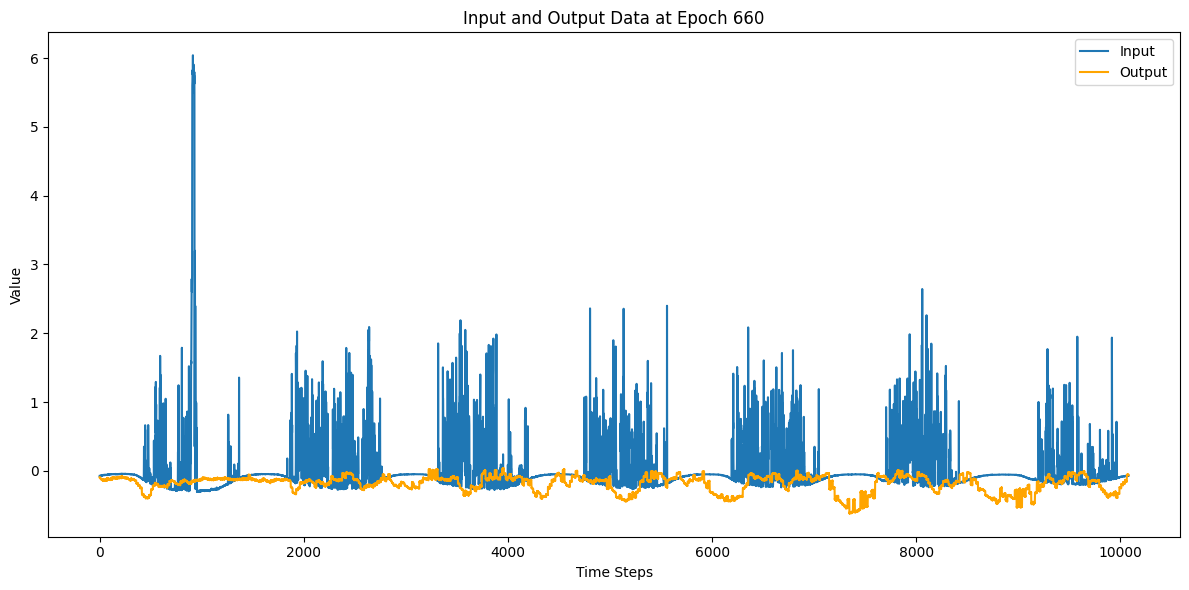

151/151 [==============================] - 8s 56ms/step - loss: 1.7512 - val_loss: 0.2390 - lr: 1.0000e-04
Epoch 661/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4378 - val_loss: 0.2698 - lr: 1.0000e-04
Epoch 662/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6113 - val_loss: 0.2463 - lr: 1.0000e-04
Epoch 663/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.1584 - val_loss: 0.2546 - lr: 1.0000e-04
Epoch 664/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4994 - val_loss: 0.2616 - lr: 1.0000e-04
Epoch 665/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0127 - val_loss: 0.2492 - lr: 1.0000e-04
Epoch 666/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6655 - val_loss: 0.2577 - lr: 1.0000e-04
Epoch 667/10000
151/151 [==============================] - 8s 51ms/step - loss: 1.3809 - val_loss: 0.2468 - lr: 1.0000e-04
Epoch 668/10000
151/151 [=======

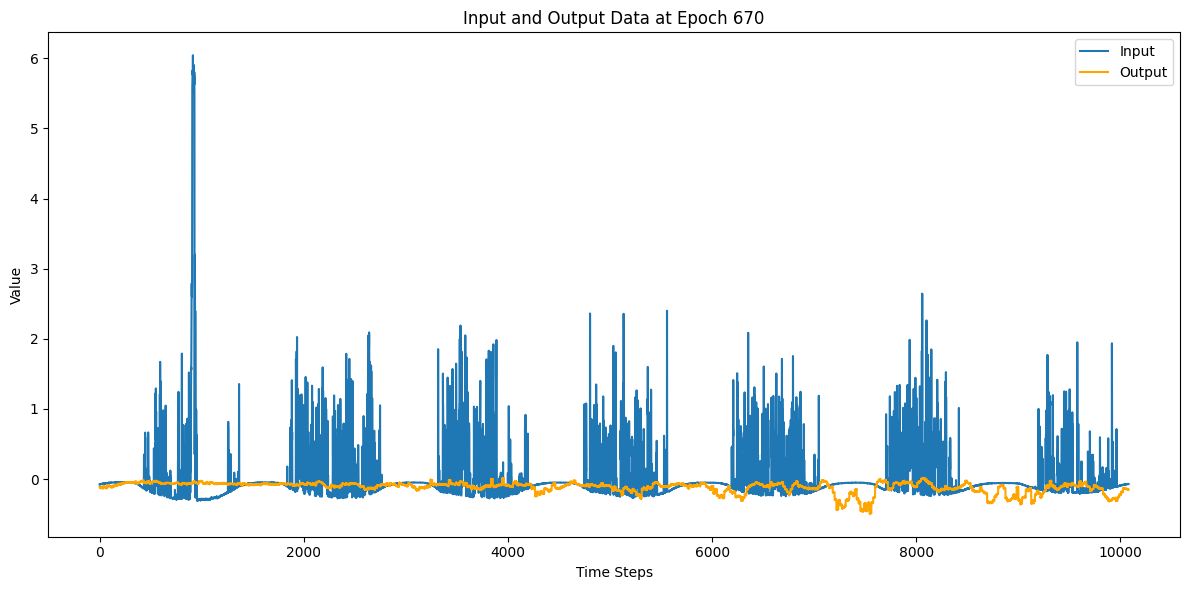

151/151 [==============================] - 9s 56ms/step - loss: 0.2822 - val_loss: 0.2703 - lr: 1.0000e-04
Epoch 671/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5354 - val_loss: 0.2644 - lr: 1.0000e-04
Epoch 672/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8237 - val_loss: 0.2599 - lr: 1.0000e-04
Epoch 673/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6327 - val_loss: 0.2506 - lr: 1.0000e-04
Epoch 674/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6579 - val_loss: 0.2398 - lr: 1.0000e-04
Epoch 675/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4795 - val_loss: 0.2551 - lr: 1.0000e-04
Epoch 676/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6895 - val_loss: 0.2395 - lr: 1.0000e-04
Epoch 677/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6172 - val_loss: 0.2382 - lr: 1.0000e-04
Epoch 678/10000
151/151 [=======

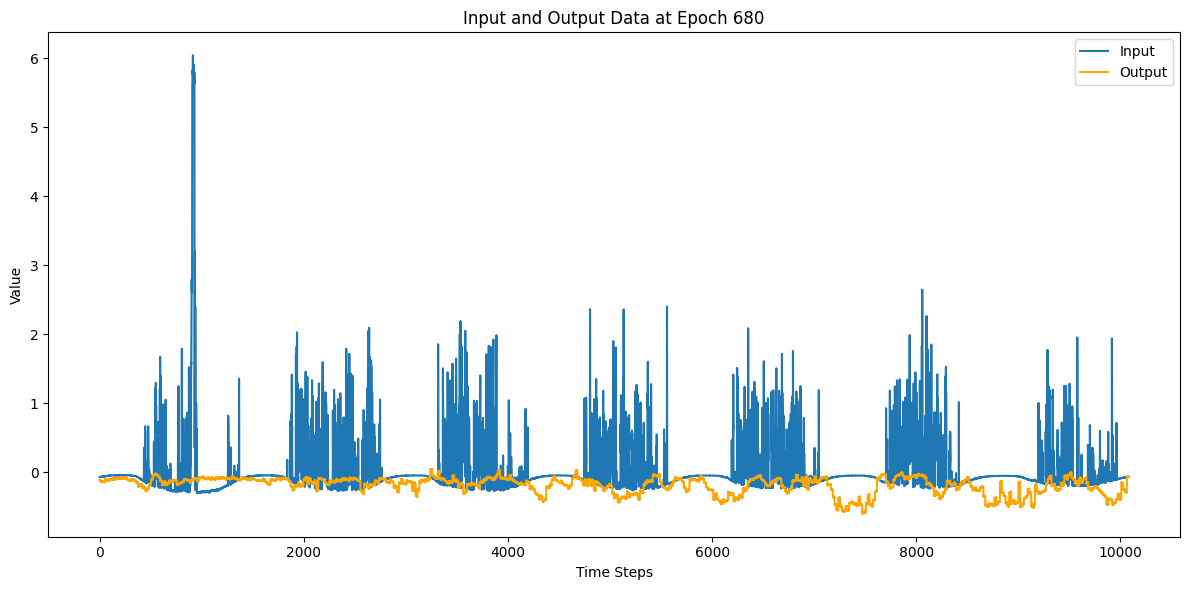

151/151 [==============================] - 8s 55ms/step - loss: 0.2797 - val_loss: 0.2555 - lr: 1.0000e-04
Epoch 681/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3619 - val_loss: 0.2583 - lr: 1.0000e-04
Epoch 682/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.5865 - val_loss: 0.2541 - lr: 1.0000e-04
Epoch 683/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.6466 - val_loss: 0.2464 - lr: 1.0000e-04
Epoch 684/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2936 - val_loss: 0.2488 - lr: 1.0000e-04
Epoch 685/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6554 - val_loss: 0.2458 - lr: 1.0000e-04
Epoch 686/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.2636 - val_loss: 0.2575 - lr: 1.0000e-04
Epoch 687/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.7646 - val_loss: 0.2632 - lr: 1.0000e-04
Epoch 688/10000
151/151 [=======

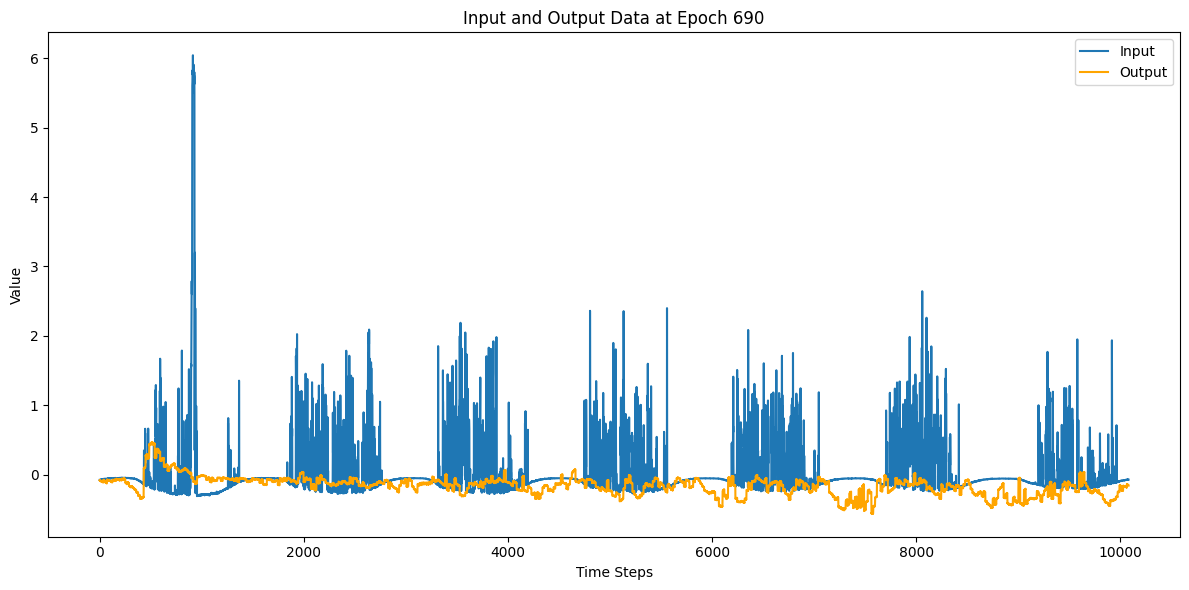

151/151 [==============================] - 9s 57ms/step - loss: 0.4253 - val_loss: 0.2599 - lr: 1.0000e-04
Epoch 691/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4635 - val_loss: 0.2457 - lr: 1.0000e-04
Epoch 692/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6680 - val_loss: 0.2397 - lr: 1.0000e-04
Epoch 693/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3343 - val_loss: 0.2554 - lr: 1.0000e-04
Epoch 694/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8204 - val_loss: 0.2422 - lr: 1.0000e-04
Epoch 695/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1785 - val_loss: 0.2541 - lr: 1.0000e-04
Epoch 696/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8149 - val_loss: 0.2439 - lr: 1.0000e-04
Epoch 697/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3583 - val_loss: 0.2349 - lr: 1.0000e-04
Epoch 698/10000
151/151 [=======

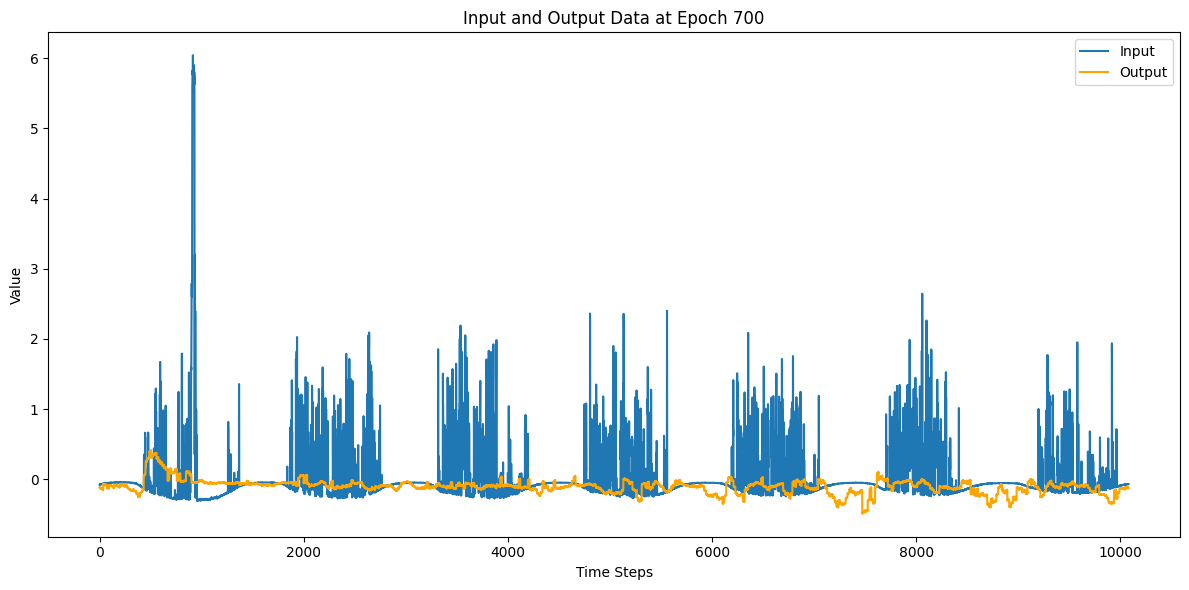

151/151 [==============================] - 8s 55ms/step - loss: 1.4053 - val_loss: 0.2597 - lr: 1.0000e-04
Epoch 701/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4605 - val_loss: 0.2472 - lr: 1.0000e-04
Epoch 702/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1477 - val_loss: 0.2473 - lr: 1.0000e-04
Epoch 703/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4530 - val_loss: 0.2422 - lr: 1.0000e-04
Epoch 704/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6782 - val_loss: 0.2579 - lr: 1.0000e-04
Epoch 705/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.2758 - val_loss: 0.2406 - lr: 1.0000e-04
Epoch 706/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7437 - val_loss: 0.2477 - lr: 1.0000e-04
Epoch 707/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0672 - val_loss: 0.2664 - lr: 1.0000e-04
Epoch 708/10000
151/151 [=======

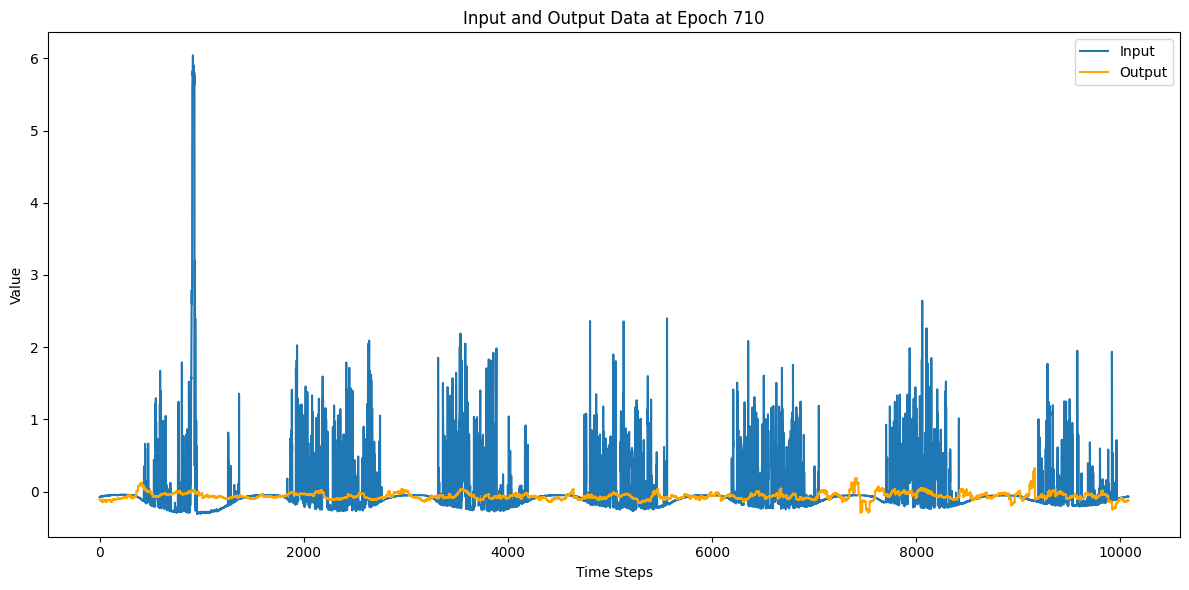

151/151 [==============================] - 8s 56ms/step - loss: 0.4620 - val_loss: 0.2577 - lr: 1.0000e-04
Epoch 711/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.9762 - val_loss: 0.2815 - lr: 1.0000e-04
Epoch 712/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.4653 - val_loss: 0.2397 - lr: 1.0000e-04
Epoch 713/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8978 - val_loss: 0.2589 - lr: 1.0000e-04
Epoch 714/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3730 - val_loss: 0.2430 - lr: 1.0000e-04
Epoch 715/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4568 - val_loss: 0.2538 - lr: 1.0000e-04
Epoch 716/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6299 - val_loss: 0.2526 - lr: 1.0000e-04
Epoch 717/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4516 - val_loss: 0.2896 - lr: 1.0000e-04
Epoch 718/10000
151/151 [=======

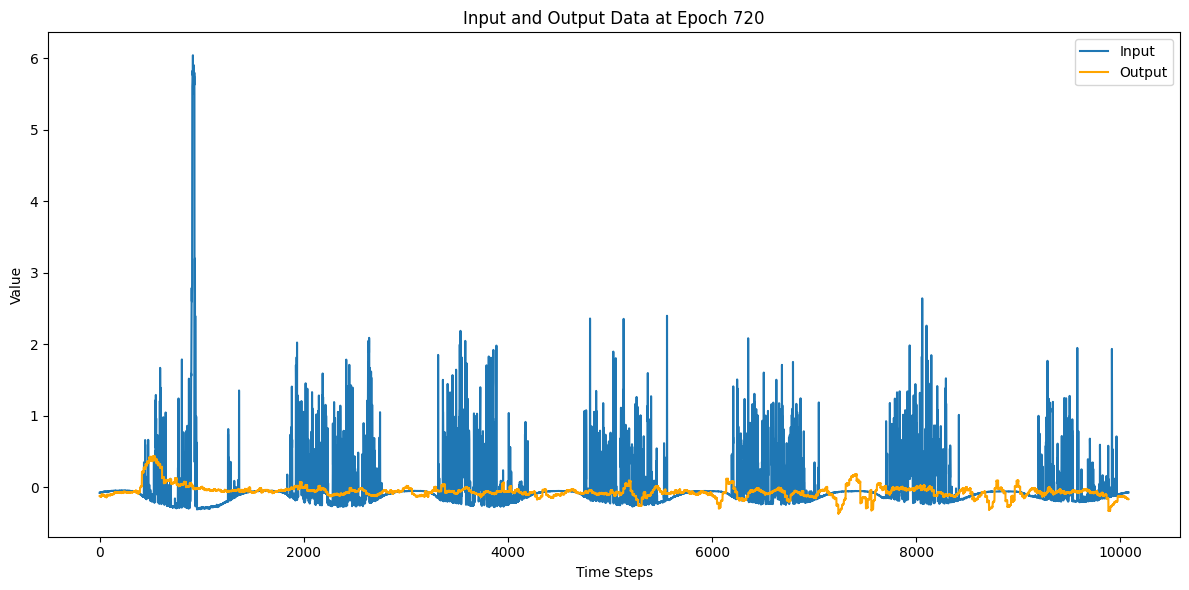

151/151 [==============================] - 8s 55ms/step - loss: 1.0555 - val_loss: 0.2680 - lr: 1.0000e-04
Epoch 721/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.2677 - val_loss: 0.2441 - lr: 1.0000e-04
Epoch 722/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1547 - val_loss: 0.2375 - lr: 1.0000e-04
Epoch 723/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3177 - val_loss: 0.2595 - lr: 1.0000e-04
Epoch 724/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4653 - val_loss: 0.2321 - lr: 1.0000e-04
Epoch 725/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2873 - val_loss: 0.2687 - lr: 1.0000e-04
Epoch 726/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.4162 - val_loss: 0.2375 - lr: 1.0000e-04
Epoch 727/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.2552 - val_loss: 0.2353 - lr: 1.0000e-04
Epoch 728/10000
151/151 [=======

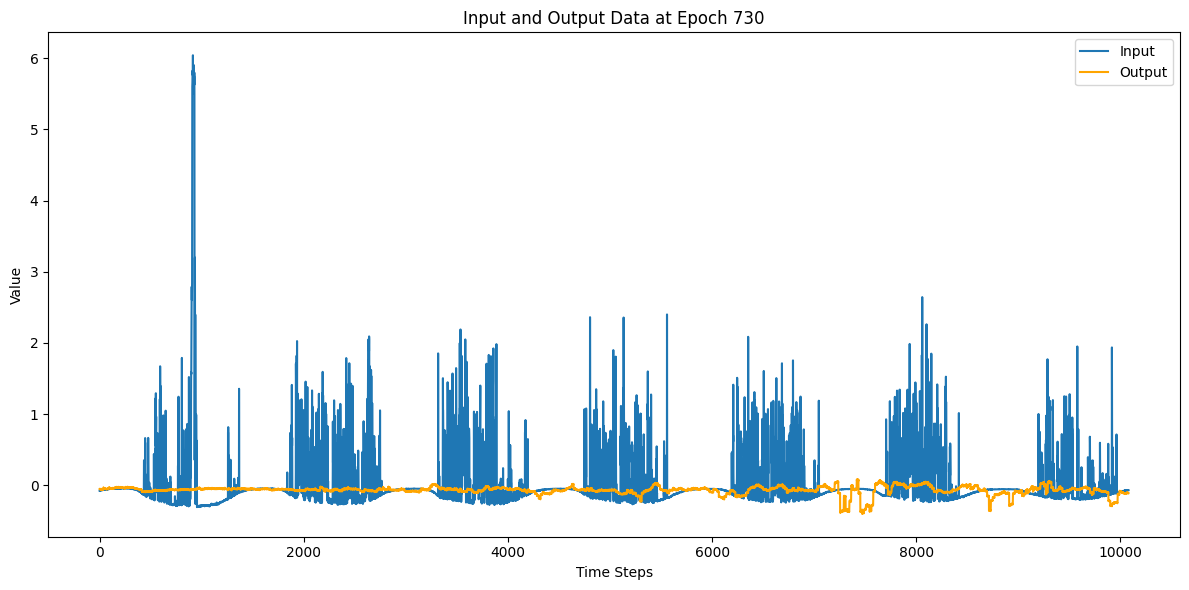

151/151 [==============================] - 8s 56ms/step - loss: 1.3471 - val_loss: 0.2501 - lr: 1.0000e-04
Epoch 731/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2833 - val_loss: 0.2434 - lr: 1.0000e-04
Epoch 732/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3217 - val_loss: 0.2697 - lr: 1.0000e-04
Epoch 733/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4794 - val_loss: 0.2365 - lr: 1.0000e-04
Epoch 734/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1677 - val_loss: 0.2590 - lr: 1.0000e-04
Epoch 735/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2780 - val_loss: 0.2651 - lr: 1.0000e-04
Epoch 736/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.9863 - val_loss: 0.2368 - lr: 1.0000e-04
Epoch 737/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9766 - val_loss: 0.2538 - lr: 1.0000e-04
Epoch 738/10000
151/151 [=======

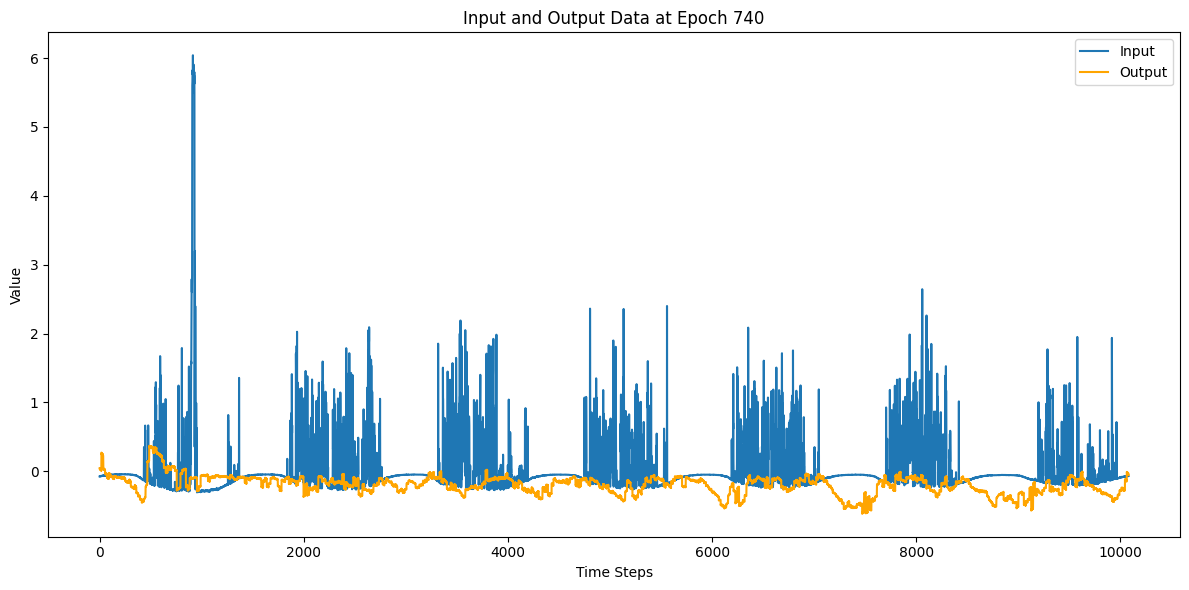

151/151 [==============================] - 8s 56ms/step - loss: 0.4075 - val_loss: 0.2700 - lr: 1.0000e-04
Epoch 741/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1800 - val_loss: 0.2457 - lr: 1.0000e-04
Epoch 742/10000
151/151 [==============================] - 8s 53ms/step - loss: 0.4903 - val_loss: 0.2486 - lr: 1.0000e-04
Epoch 743/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9129 - val_loss: 0.2460 - lr: 1.0000e-04
Epoch 744/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.3099 - val_loss: 0.2533 - lr: 1.0000e-04
Epoch 745/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0336 - val_loss: 0.2357 - lr: 1.0000e-04
Epoch 746/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2594 - val_loss: 0.2638 - lr: 1.0000e-04
Epoch 747/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.2980 - val_loss: 0.2367 - lr: 1.0000e-04
Epoch 748/10000
151/151 [=======

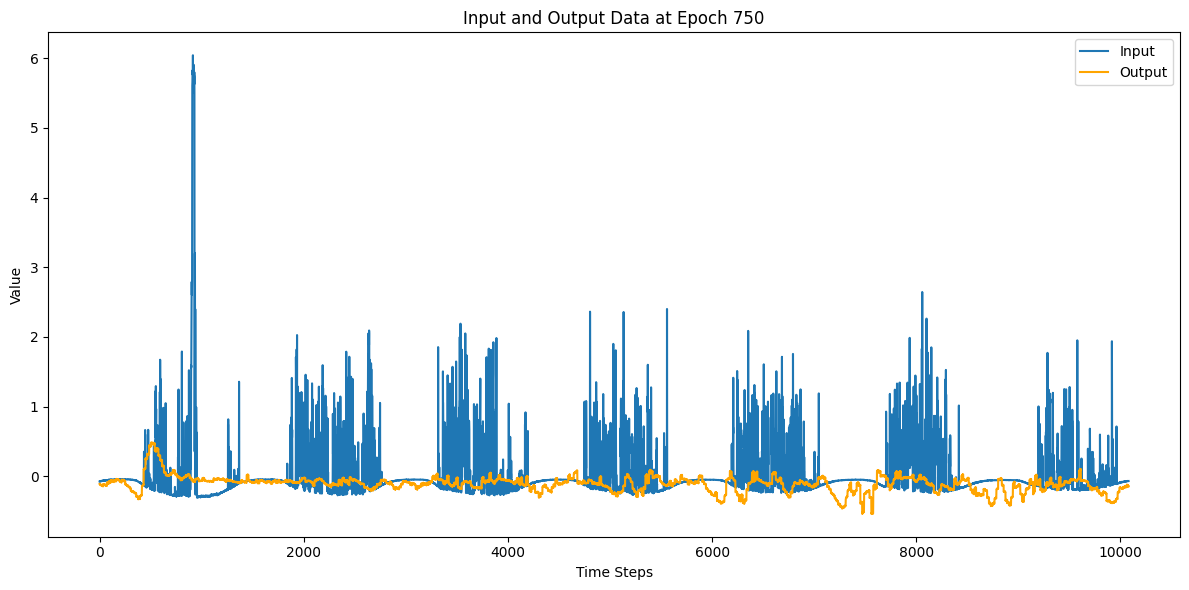

151/151 [==============================] - 9s 57ms/step - loss: 1.4548 - val_loss: 0.2507 - lr: 1.0000e-04
Epoch 751/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2145 - val_loss: 0.2318 - lr: 1.0000e-04
Epoch 752/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2960 - val_loss: 0.2511 - lr: 1.0000e-04
Epoch 753/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4279 - val_loss: 0.2516 - lr: 1.0000e-04
Epoch 754/10000
151/151 [==============================] - 7s 49ms/step - loss: 2.6711 - val_loss: 0.2595 - lr: 1.0000e-04
Epoch 755/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7052 - val_loss: 0.2371 - lr: 1.0000e-04
Epoch 756/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.3343 - val_loss: 0.2459 - lr: 1.0000e-04
Epoch 757/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4582 - val_loss: 0.2269 - lr: 1.0000e-04
Epoch 758/10000
151/151 [=======

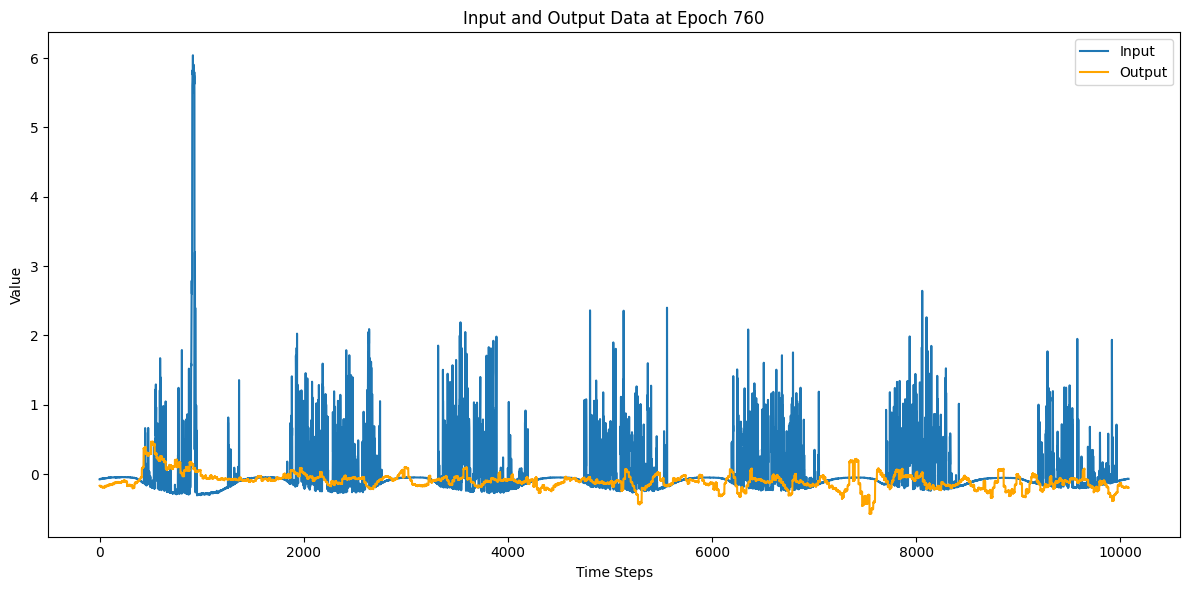

151/151 [==============================] - 8s 55ms/step - loss: 2.5153 - val_loss: 0.2458 - lr: 1.0000e-04
Epoch 761/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.8802 - val_loss: 0.2426 - lr: 1.0000e-04
Epoch 762/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4534 - val_loss: 0.2656 - lr: 1.0000e-04
Epoch 763/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7760 - val_loss: 0.2636 - lr: 1.0000e-04
Epoch 764/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.9897 - val_loss: 0.2378 - lr: 1.0000e-04
Epoch 765/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3810 - val_loss: 0.2343 - lr: 1.0000e-04
Epoch 766/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9545 - val_loss: 0.2442 - lr: 1.0000e-04
Epoch 767/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4688 - val_loss: 0.2730 - lr: 1.0000e-04
Epoch 768/10000
151/151 [=======

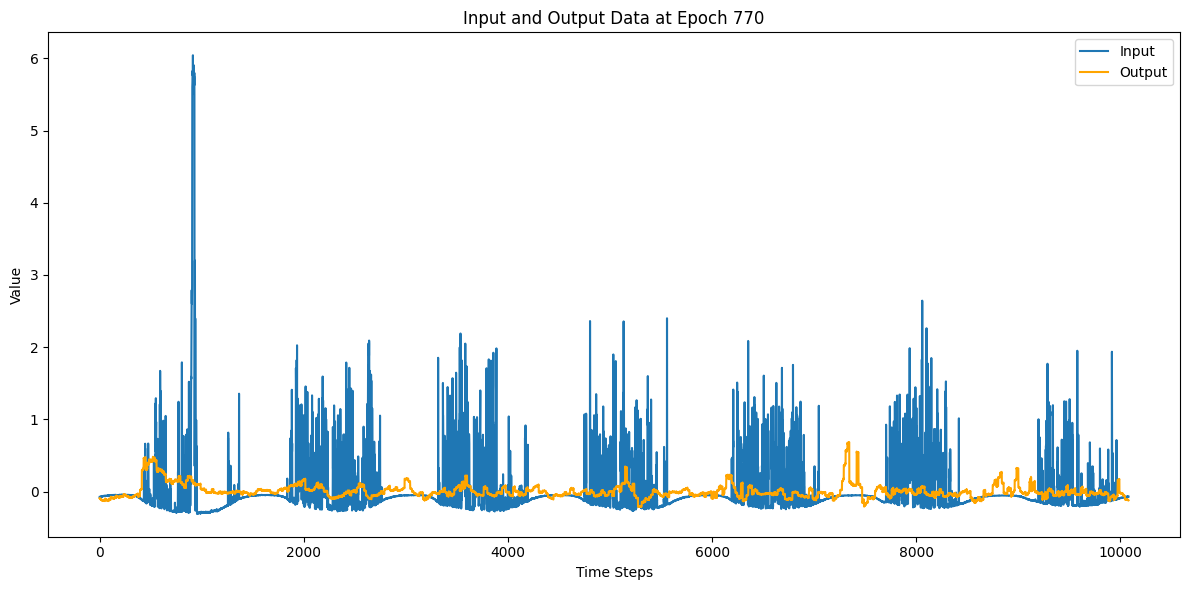

151/151 [==============================] - 8s 56ms/step - loss: 0.4624 - val_loss: 0.2379 - lr: 1.0000e-04
Epoch 771/10000
151/151 [==============================] - 8s 52ms/step - loss: 1.0281 - val_loss: 0.2674 - lr: 1.0000e-04
Epoch 772/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1671 - val_loss: 0.2275 - lr: 1.0000e-04
Epoch 773/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.0010 - val_loss: 0.2449 - lr: 1.0000e-04
Epoch 774/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.3116 - val_loss: 0.2485 - lr: 1.0000e-04
Epoch 775/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4942 - val_loss: 0.2486 - lr: 1.0000e-04
Epoch 776/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4045 - val_loss: 0.2641 - lr: 1.0000e-04
Epoch 777/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7043 - val_loss: 0.2411 - lr: 1.0000e-04
Epoch 778/10000
151/151 [=======

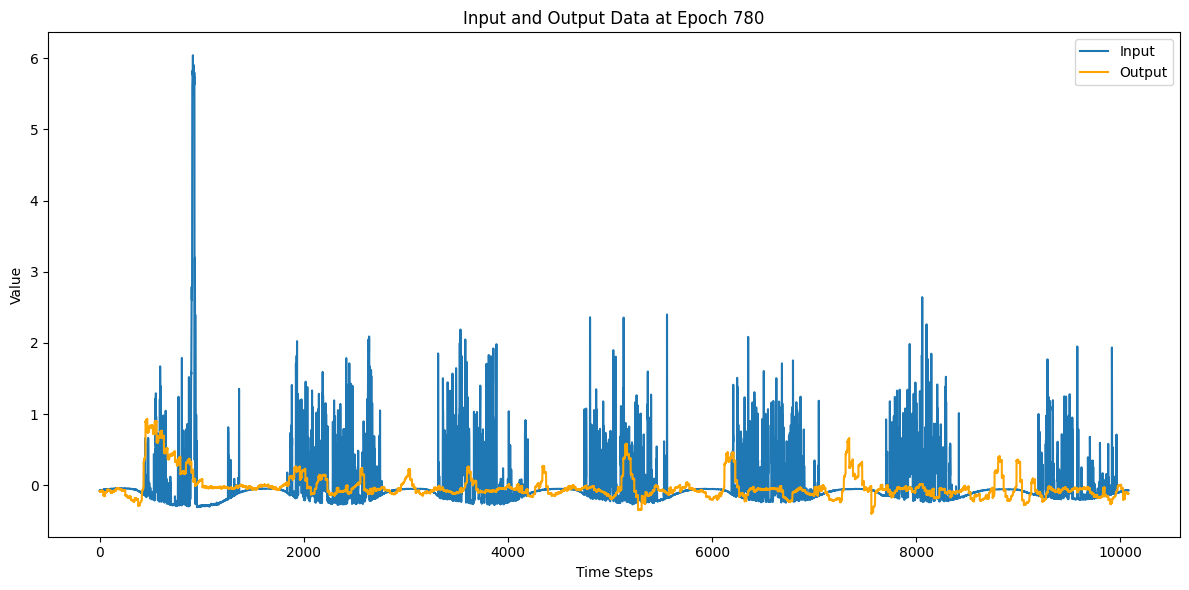

151/151 [==============================] - 8s 55ms/step - loss: 1.3998 - val_loss: 0.2386 - lr: 1.0000e-04
Epoch 781/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8576 - val_loss: 0.2520 - lr: 1.0000e-04
Epoch 782/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.1875 - val_loss: 0.2306 - lr: 1.0000e-04
Epoch 783/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9216 - val_loss: 0.2579 - lr: 1.0000e-04
Epoch 784/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4760 - val_loss: 0.2699 - lr: 1.0000e-04
Epoch 785/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8534 - val_loss: 0.2463 - lr: 1.0000e-04
Epoch 786/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8473 - val_loss: 0.2488 - lr: 1.0000e-04
Epoch 787/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.7271 - val_loss: 0.2415 - lr: 1.0000e-04
Epoch 788/10000
151/151 [=======

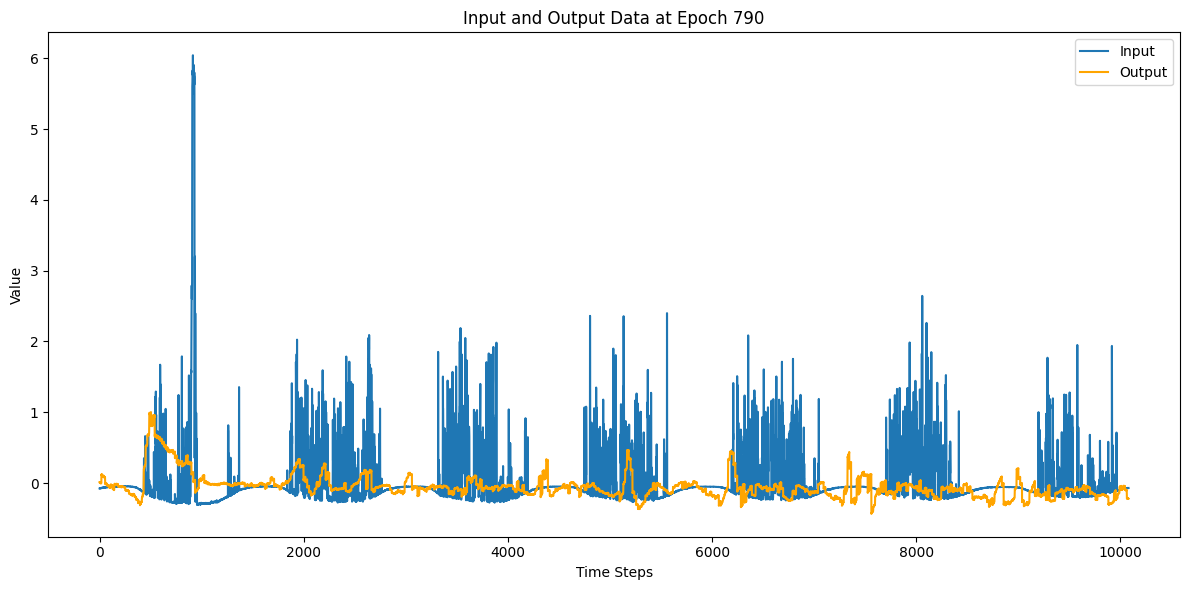

151/151 [==============================] - 8s 56ms/step - loss: 0.5699 - val_loss: 0.2452 - lr: 1.0000e-04
Epoch 791/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6905 - val_loss: 0.2482 - lr: 1.0000e-04
Epoch 792/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.2113 - val_loss: 0.2373 - lr: 1.0000e-04
Epoch 793/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2784 - val_loss: 0.2567 - lr: 1.0000e-04
Epoch 794/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.3474 - val_loss: 0.2625 - lr: 1.0000e-04
Epoch 795/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.9970 - val_loss: 0.2469 - lr: 1.0000e-04
Epoch 796/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4743 - val_loss: 0.2335 - lr: 1.0000e-04
Epoch 797/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8500 - val_loss: 0.2411 - lr: 1.0000e-04
Epoch 798/10000
151/151 [=======

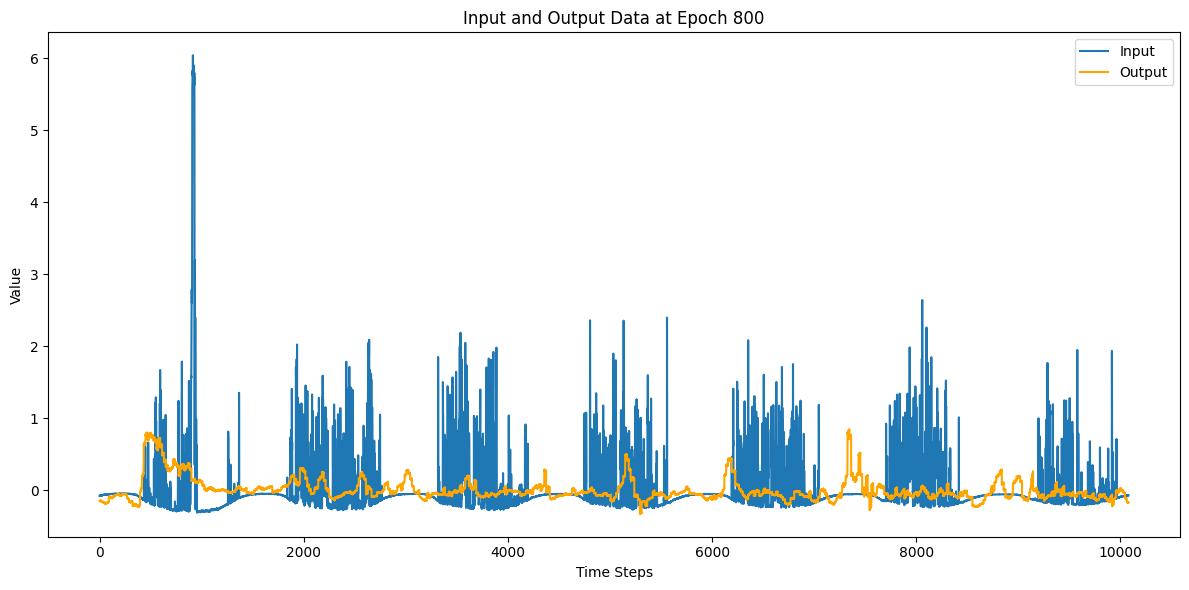

151/151 [==============================] - 9s 60ms/step - loss: 0.6108 - val_loss: 0.2319 - lr: 1.0000e-04
Epoch 801/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6501 - val_loss: 0.2362 - lr: 1.0000e-04
Epoch 802/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.8200 - val_loss: 0.2344 - lr: 1.0000e-04
Epoch 803/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4566 - val_loss: 0.2437 - lr: 1.0000e-04
Epoch 804/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4502 - val_loss: 0.2567 - lr: 1.0000e-04
Epoch 805/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.2951 - val_loss: 0.2412 - lr: 1.0000e-04
Epoch 806/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.8348 - val_loss: 0.2309 - lr: 1.0000e-04
Epoch 807/10000
151/151 [==============================] - 7s 50ms/step - loss: 0.5321 - val_loss: 0.2361 - lr: 1.0000e-04
Epoch 808/10000
151/151 [=======

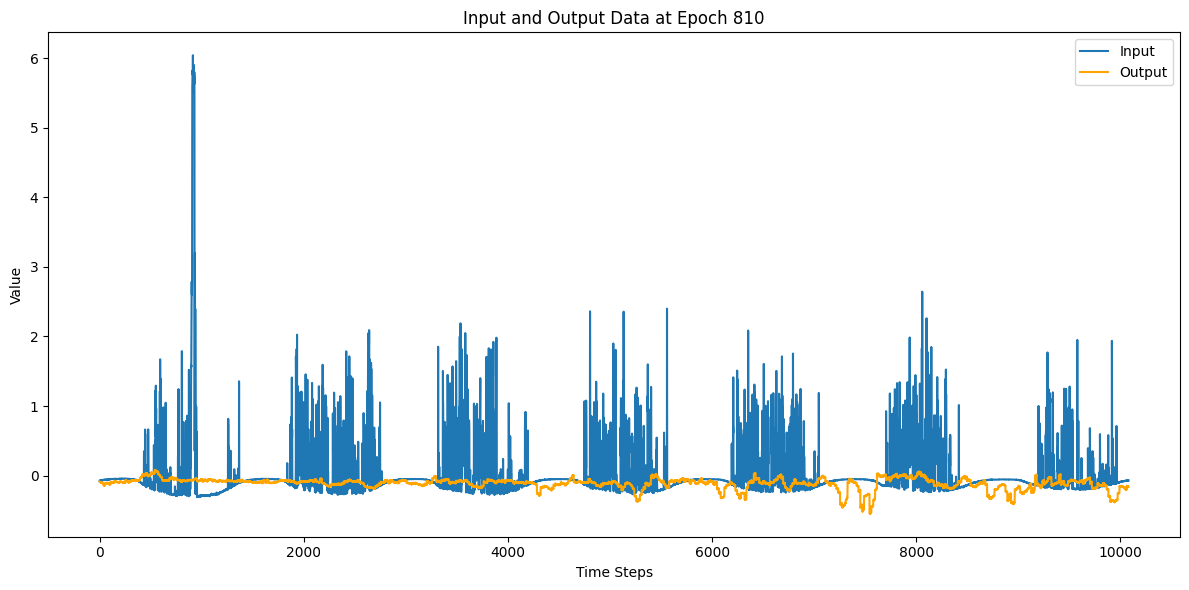

151/151 [==============================] - 8s 56ms/step - loss: 0.4550 - val_loss: 0.2552 - lr: 1.0000e-04
Epoch 811/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8399 - val_loss: 0.2664 - lr: 1.0000e-04
Epoch 812/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0749 - val_loss: 0.2706 - lr: 1.0000e-04
Epoch 813/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6207 - val_loss: 0.2621 - lr: 1.0000e-04
Epoch 814/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6590 - val_loss: 0.2695 - lr: 1.0000e-04
Epoch 815/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.3688 - val_loss: 0.2317 - lr: 1.0000e-04
Epoch 816/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.2752 - val_loss: 0.2551 - lr: 1.0000e-04
Epoch 817/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.2781 - val_loss: 0.2290 - lr: 1.0000e-04
Epoch 818/10000
151/151 [=======

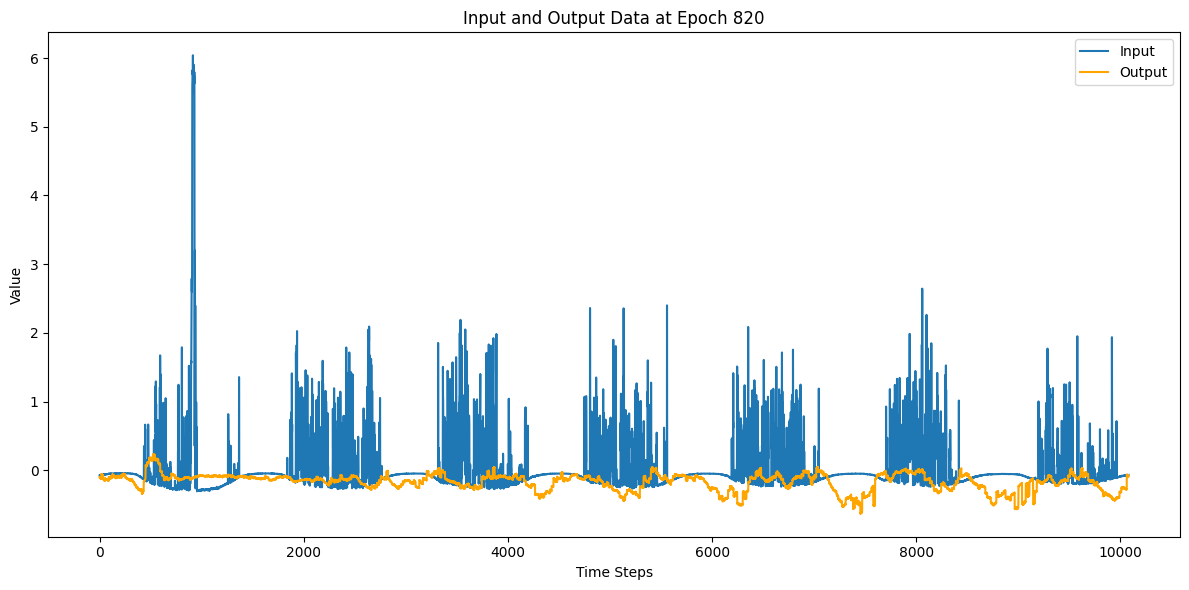

151/151 [==============================] - 8s 55ms/step - loss: 0.2640 - val_loss: 0.2559 - lr: 1.0000e-04
Epoch 821/10000
151/151 [==============================] - 7s 48ms/step - loss: 1.0214 - val_loss: 0.2400 - lr: 1.0000e-04
Epoch 822/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4608 - val_loss: 0.2546 - lr: 1.0000e-04
Epoch 823/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5564 - val_loss: 0.2667 - lr: 1.0000e-04
Epoch 824/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.5984 - val_loss: 0.2545 - lr: 1.0000e-04
Epoch 825/10000
151/151 [==============================] - 8s 50ms/step - loss: 1.1863 - val_loss: 0.2579 - lr: 1.0000e-04
Epoch 826/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.6011 - val_loss: 0.2569 - lr: 1.0000e-04
Epoch 827/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.8900 - val_loss: 0.2296 - lr: 1.0000e-04
Epoch 828/10000
151/151 [=======

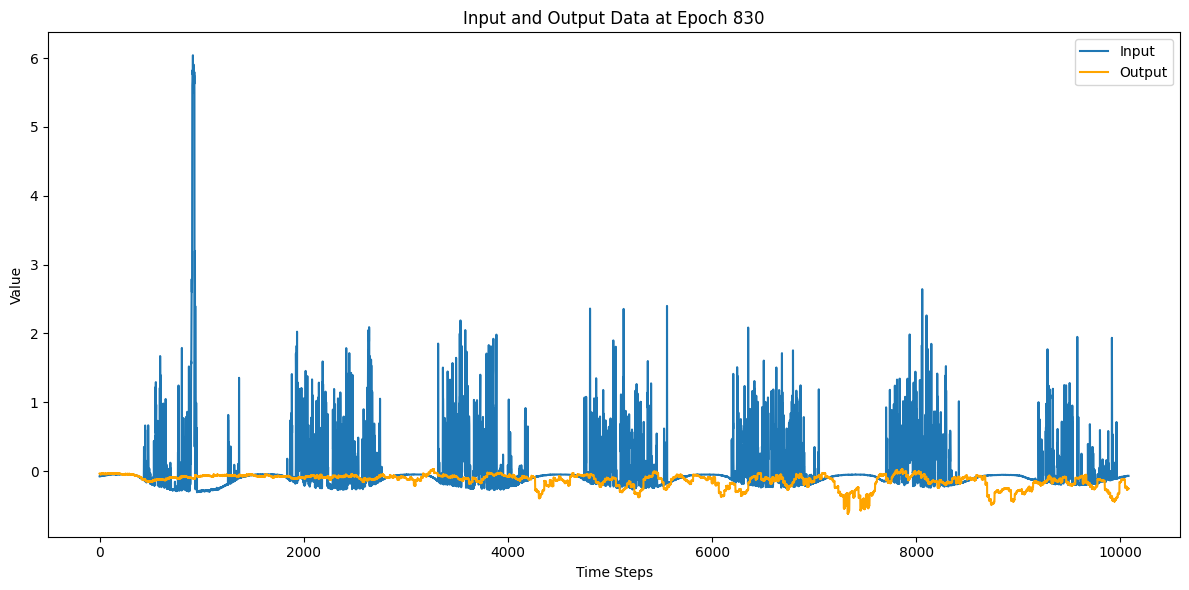

151/151 [==============================] - 9s 60ms/step - loss: 0.2594 - val_loss: 0.2354 - lr: 1.0000e-04
Epoch 831/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.5933 - val_loss: 0.2338 - lr: 1.0000e-04
Epoch 832/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.6436 - val_loss: 0.2469 - lr: 1.0000e-04
Epoch 833/10000
151/151 [==============================] - 7s 49ms/step - loss: 0.4584 - val_loss: 0.2585 - lr: 1.0000e-04
Epoch 834/10000
151/151 [==============================] - 7s 49ms/step - loss: 1.9226 - val_loss: 0.2541 - lr: 1.0000e-04
Epoch 835/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.4302 - val_loss: 0.2321 - lr: 1.0000e-04
Epoch 836/10000
151/151 [==============================] - 8s 50ms/step - loss: 0.5986 - val_loss: 0.2383 - lr: 1.0000e-04
Epoch 837/10000
151/151 [==============================] - 7s 48ms/step - loss: 0.4756 - val_loss: 0.2390 - lr: 1.0000e-04
Epoch 838/10000
151/151 [=======

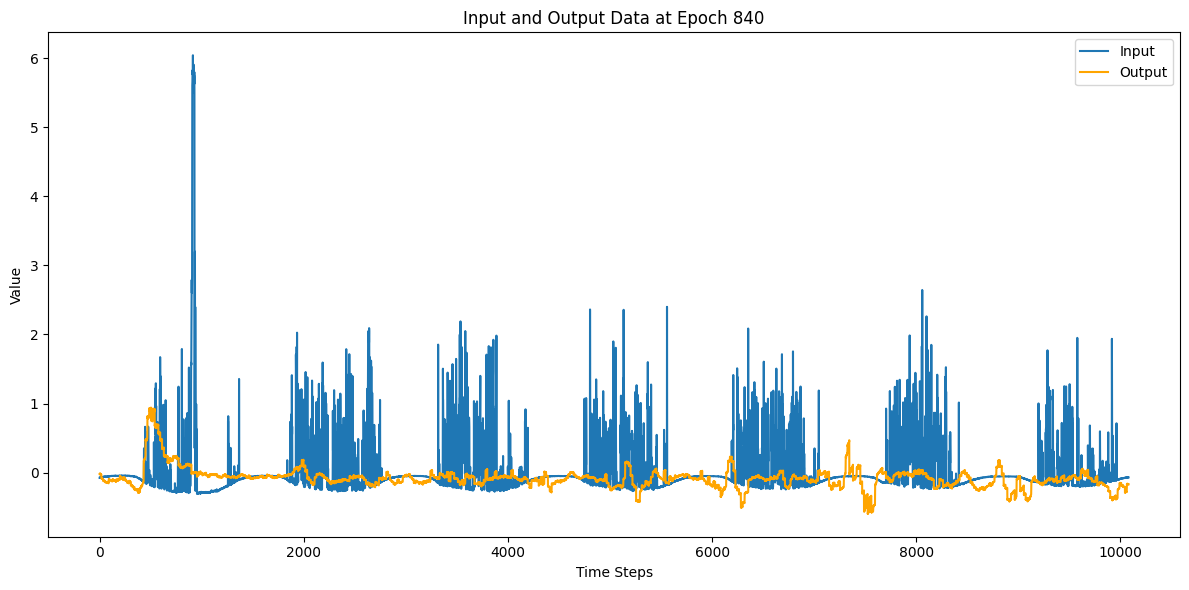

151/151 [==============================] - 8s 55ms/step - loss: 0.3739 - val_loss: 0.2677 - lr: 1.0000e-04
Epoch 841/10000
151/151 [==============================] - 10s 66ms/step - loss: 0.2552 - val_loss: 0.2554 - lr: 1.0000e-04
Epoch 841: early stopping


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Define your custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, function, frequency):
        super(CustomCallback, self).__init__()
        self.function = function
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            self.function(epoch + 1, logs)

# Define your custom function
def my_custom_function(epoch, logs):
    print(f"\n plotting.. output {epoch}")

    # Plot the input and output for X_test[0]
    input_data = X_test[0]
    output_data = model.predict(input_data.reshape(1, -1, 1)).flatten()  # Reshape to match the model input and flatten the output

    plt.figure(figsize=(12, 6))

    # Plot the input data and output data as an overlay
    plt.plot(input_data, label='Input')
    plt.plot(output_data, label='Output', color='orange')
    plt.title(f'Input and Output Data at Epoch {epoch}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()

    # Save the figure with a zero-padded filename for correct sorting
    plt.savefig(f'output_epoch_{epoch:06d}.png')
    plt.show()
    plt.close()


# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=min_lr, verbose=1)
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)
custom_callback = CustomCallback(function=my_custom_function, frequency=10)


# Fit the model with all callbacks
with strategy.scope():
    history = model.fit(
        X_train, X_train,
        epochs=10000,
        batch_size=128,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, custom_callback]
    )

# Save model

In [ ]:
# Function to save just the encoder part of the model
def save_encoder_only(model, encoder_num_layers, embed_dim, save_path=root+name):
    # Define a new input that matches the expected input shape of the encoder
    encoder_input = model.input

    # include patch embedding and reshape
    x = model.get_layer(name="dense").output  # The Dense layer after reshaping

    # give positional embedding
    num_patches = 10080 // patch_size
    positional_embeddings = get_positional_embeddings(num_patches, embed_dim)

    x = x + positional_embeddings

    attention_weights = []
    for i in range(encoder_num_layers):
        transformer_block = model.get_layer(name=f"encoder_layer_{i+1}_transformer")
        x, weights = transformer_block(x)
        attention_weights.append(weights)

    # Create the encoder model with the new input
    encoder_model = models.Model(inputs=encoder_input, outputs=[x] + attention_weights, name="encoder_model")
    encoder_model.save(save_path)
    print(f"Encoder model saved to {save_path}")

# Save the encoder model
save_encoder_only(model, encoder_num_layers, embed_dim=embed_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Encoder model saved to /content/drive/MyDrive/Extra Curricular /ActigraphyTransformer/A-NEW/ALBERT Experiments /ALBERT Pretraining/Encoders/encoder_medium_50_unsmoothed_mse_only_masked.h5


In [ ]:
encoder_model = tf.keras.models.load_model(root+name, custom_objects={'TransformerBlock': TransformerBlock, 'get_positional_embeddings': get_positional_embeddings})

In [ ]:
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10080)]           0         
                                                                 
 reshape (Reshape)           (None, 560, 18)           0         
                                                                 
 dense (Dense)               (None, 560, 96)           1824      
                                                                 
 tf.__operators__.add_8 (TF  (None, 560, 96)           0         
 OpLambda)                                                       
                                                                 
 encoder_layer_1_transforme  [(None, None, 96),        495808    
 r (Functional)               (None, 12, None, None)             
                             ]                                   
                                                     

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model

def plot_input_mask_output(model, X_test, num_samples=20, patch_size=patch_size):
    """
    Creates a separate plot for each input from X_test, showing the original input,
    the masked input that the model sees, the model's output, and a combination
    of original and output data, stacked vertically.

    Parameters:
    - model: The trained model.
    - X_test: Test data, shape should be (num_samples, input_size, 1).
    - num_samples: Number of samples to visualize.
    - patch_size: Size of the patches used by the model.
    """
    num_patches = X_test.shape[1] // patch_size

    # Create a sub-model that outputs the visible patches and model output
    intermediate_model = Model(inputs=model.input,
                               outputs=[model.get_layer('mask_layer').output, model.output])

    for i in range(num_samples):
        original_input = X_test[i].flatten()  # Flatten the original input for easy handling

        # Get the intermediate output and final output from the model
        mask_layer_output, model_output = intermediate_model.predict(X_test[i:i+1])
        visible_patches, _, _, shuffle_indices, masked_indices = mask_layer_output


        # Ensure the indices are properly interpreted as arrays
        shuffle_indices = np.array(shuffle_indices)
        masked_indices = np.array(masked_indices)

        # Calculate the visible indices
        visible_indices = np.setdiff1d(shuffle_indices, masked_indices)

        # Combine the original and output data for the fourth plot
        combined_data = original_input.copy()
        model_output = model_output.flatten()
        for idx in masked_indices:
            start = idx * patch_size
            end = start + patch_size
            combined_data[start:end] = model_output[start:end]

        # Create a new figure for each input
        fig, axes = plt.subplots(4, 1, figsize=(30, 20))

        # Plot original input
        axes[0].plot(original_input, color='blue')
        axes[0].set_title('Original Input')

        # Plot the input and overlay gray highlight on non-visible patches
        axes[1].plot(original_input, color='blue')
        for idx in masked_indices:
            start = idx * patch_size
            end = start + patch_size
            axes[1].axvspan(start, end, color='gray', zorder=10)  # Gray overlay in the foreground with high zorder
        axes[1].set_title('Input with Non-Visible Patches Covered')

        # Plot model output
        axes[2].plot(original_input, color='lightgray', linestyle='dashed')
        axes[2].plot(model_output, color='green')
        axes[2].set_title('Model Output')

        # Plot combined data with original input and light red background for masked areas
        axes[3].plot(original_input, color='lightgray', linestyle='dashed')
        for idx in masked_indices:
            start = idx * patch_size
            end = start + patch_size
            axes[3].axvspan(start, end, color='lightcoral', alpha=1, zorder=1)  # Light red background
        axes[3].plot(combined_data, color='green')
        axes[3].set_title('Combined Data with Original and Masked Highlight')

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()


In [ ]:
# Plot results
plot_input_mask_output(model, X_test, patch_size=patch_size, num_samples=50)

In [ ]:
#inspect the data rq